In [1]:
# Import relevant libraries
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import warnings
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set()

In [2]:
#pip install mlxtend

In [3]:
# Get the dataset and checking its first rows
df_train = pd.read_excel(r'Data/Train.xlsx')
df_train.head()

CITIZEN_ID                  Name          Birthday Native Continent  \
0       12486       Mr. Adam Glover       July 1,2003           Europe   
1       12487  Mr. Cameron McDonald   January 25,2006           Europe   
2       12488    Mr. Keith Davidson       May 10,2009           Europe   
3       12489    Mr. Alexander Gill     March 25,1985           Europe   
4       12490        Mr. Neil Piper       May 29,2015           Europe   

  Marital Status    Lives with  Base Area               Education Level  \
0        Married          Wife  Northbury  High School + PostGraduation   
1        Married          Wife  Northbury           Professional School   
2        Married          Wife  Northbury           Professional School   
3        Married          Wife  Northbury       High School - 2nd Cycle   
4         Single  Other Family  Northbury                           PhD   

   Years of Education           Employment Sector                    Role  \
0                  13  Private Sector - Services   Repair & constructions   
1                  12      Public Sector - Others  Repair & constructions   
2                  12  Private Sector - Services                    Sales   
3                  11  Private Sector - Services                 Security   
4                  21  Self-Employed (Individual)               Professor   

   Working Hours per week  Money Received  Ticket Price  Income  
0                      40               0          2273       1  
1                      40               0             0       1  
2                      46               0          2321       1  
3                      37            5395             0       1  
4                      45               0             0       1

## Data Exploration

In [4]:
# Checking data types and nulls in the dataset --> see there are no nulls
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [5]:
# Birthday is type object, so we're transforming it to type datetime
# For that we must first fix the problem of having February 29 for non-leap years --> turn all February 29 to February 28
df_train['Birthday']=df_train['Birthday'].map(lambda x: x.replace("February 29", "February 28"))

# Check if the replacement worked
df_train['Birthday'][df_train['Birthday'].str.contains("February 29")]

Series([], Name: Birthday, dtype: object)

In [6]:
# Change the format the date appears and the data type to datetime
df_train['Birthday']=df_train['Birthday'].map(lambda x: datetime.strptime(x, " %B %d,%Y").date())
df_train['Birthday'] = pd.to_datetime(df_train['Birthday'])

In [7]:
# Get a descriptive overview of the variables (both numeric and categorical)
df_train.describe(include="all")

<ipython-input-7-47894f873884>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_train.describe(include="all")


CITIZEN_ID              Name             Birthday Native Continent  \
count   22400.000000             22400                22400            22400   
unique           NaN             16074                11229                5   
top              NaN  Mr. Dominic Rees  2025-08-15 00:00:00           Europe   
freq             NaN                 4                    9            19111   
first            NaN               NaN  1958-01-01 00:00:00              NaN   
last             NaN               NaN  2031-10-11 00:00:00              NaN   
mean    23685.500000               NaN                  NaN              NaN   
std      6466.467351               NaN                  NaN              NaN   
min     12486.000000               NaN                  NaN              NaN   
25%     18085.750000               NaN                  NaN              NaN   
50%     23685.500000               NaN                  NaN              NaN   
75%     29285.250000               NaN                  NaN              NaN   
max     34885.000000               NaN                  NaN              NaN   

       Marital Status Lives with  Base Area      Education Level  \
count           22400      22400      22400                22400   
unique              7          6         40                   16   
top           Married       Wife  Northbury  Professional School   
freq            10219       9012      20074                 7232   
first             NaN        NaN        NaN                  NaN   
last              NaN        NaN        NaN                  NaN   
mean              NaN        NaN        NaN                  NaN   
std               NaN        NaN        NaN                  NaN   
min               NaN        NaN        NaN                  NaN   
25%               NaN        NaN        NaN                  NaN   
50%               NaN        NaN        NaN                  NaN   
75%               NaN        NaN        NaN                  NaN   
max               NaN        NaN        NaN                  NaN   

        Years of Education           Employment Sector       Role  \
count         22400.000000                       22400      22400   
unique                 NaN                           9         15   
top                    NaN  Private Sector - Services   Professor   
freq                   NaN                       15599       2849   
first                  NaN                         NaN        NaN   
last                   NaN                         NaN        NaN   
mean             13.173884                         NaN        NaN   
std               2.512451                         NaN        NaN   
min               2.000000                         NaN        NaN   
25%              12.000000                         NaN        NaN   
50%              13.000000                         NaN        NaN   
75%              15.000000                         NaN        NaN   
max              21.000000                         NaN        NaN   

        Working Hours per week  Money Received  Ticket Price        Income  
count             22400.000000    22400.000000  22400.000000  22400.000000  
unique                     NaN             NaN           NaN           NaN  
top                        NaN             NaN           NaN           NaN  
freq                       NaN             NaN           NaN           NaN  
first                      NaN             NaN           NaN           NaN  
last                       NaN             NaN           NaN           NaN  
mean                 40.483795     1324.915357    109.145313      0.237098  
std                  12.370921     9227.771813    500.208904      0.425313  
min                   1.000000        0.000000      0.000000      0.000000  
25%                  40.000000        0.000000      0.000000      0.000000  
50%                  40.000000        0.000000      0.000000      0.000000  
75%                  45.000000        0.00000

In [8]:
# Define Citizen_ID as the index
df_train.set_index("CITIZEN_ID", inplace=True)

# Define Income variable as the target and remove it from the dataframe with the independent variables
target = df_train['Income']
df_train = df_train.drop(['Income'], axis=1)

# Define metric and non-metric datasets
metric= df_train.loc[:, np.array(df_train.dtypes=="int64")]
non_metric= df_train.loc[:,np.array(df_train.dtypes=="object")]

In [9]:
# Get only the year from Birthday, so as to get a better visualization of the values
metric['Birthday']=df_train.Birthday.map(lambda x: x.year)

# Remove Name from the list of non_metric variables since that gives us no meaning or valuable information and plotting it would be useless
non_metric.drop(columns="Name", inplace=True)

<ipython-input-9-86cd2c956a35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric['Birthday']=df_train.Birthday.map(lambda x: x.year)
C:\Users\ruifi\anaconda3\envs\MLclasses\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


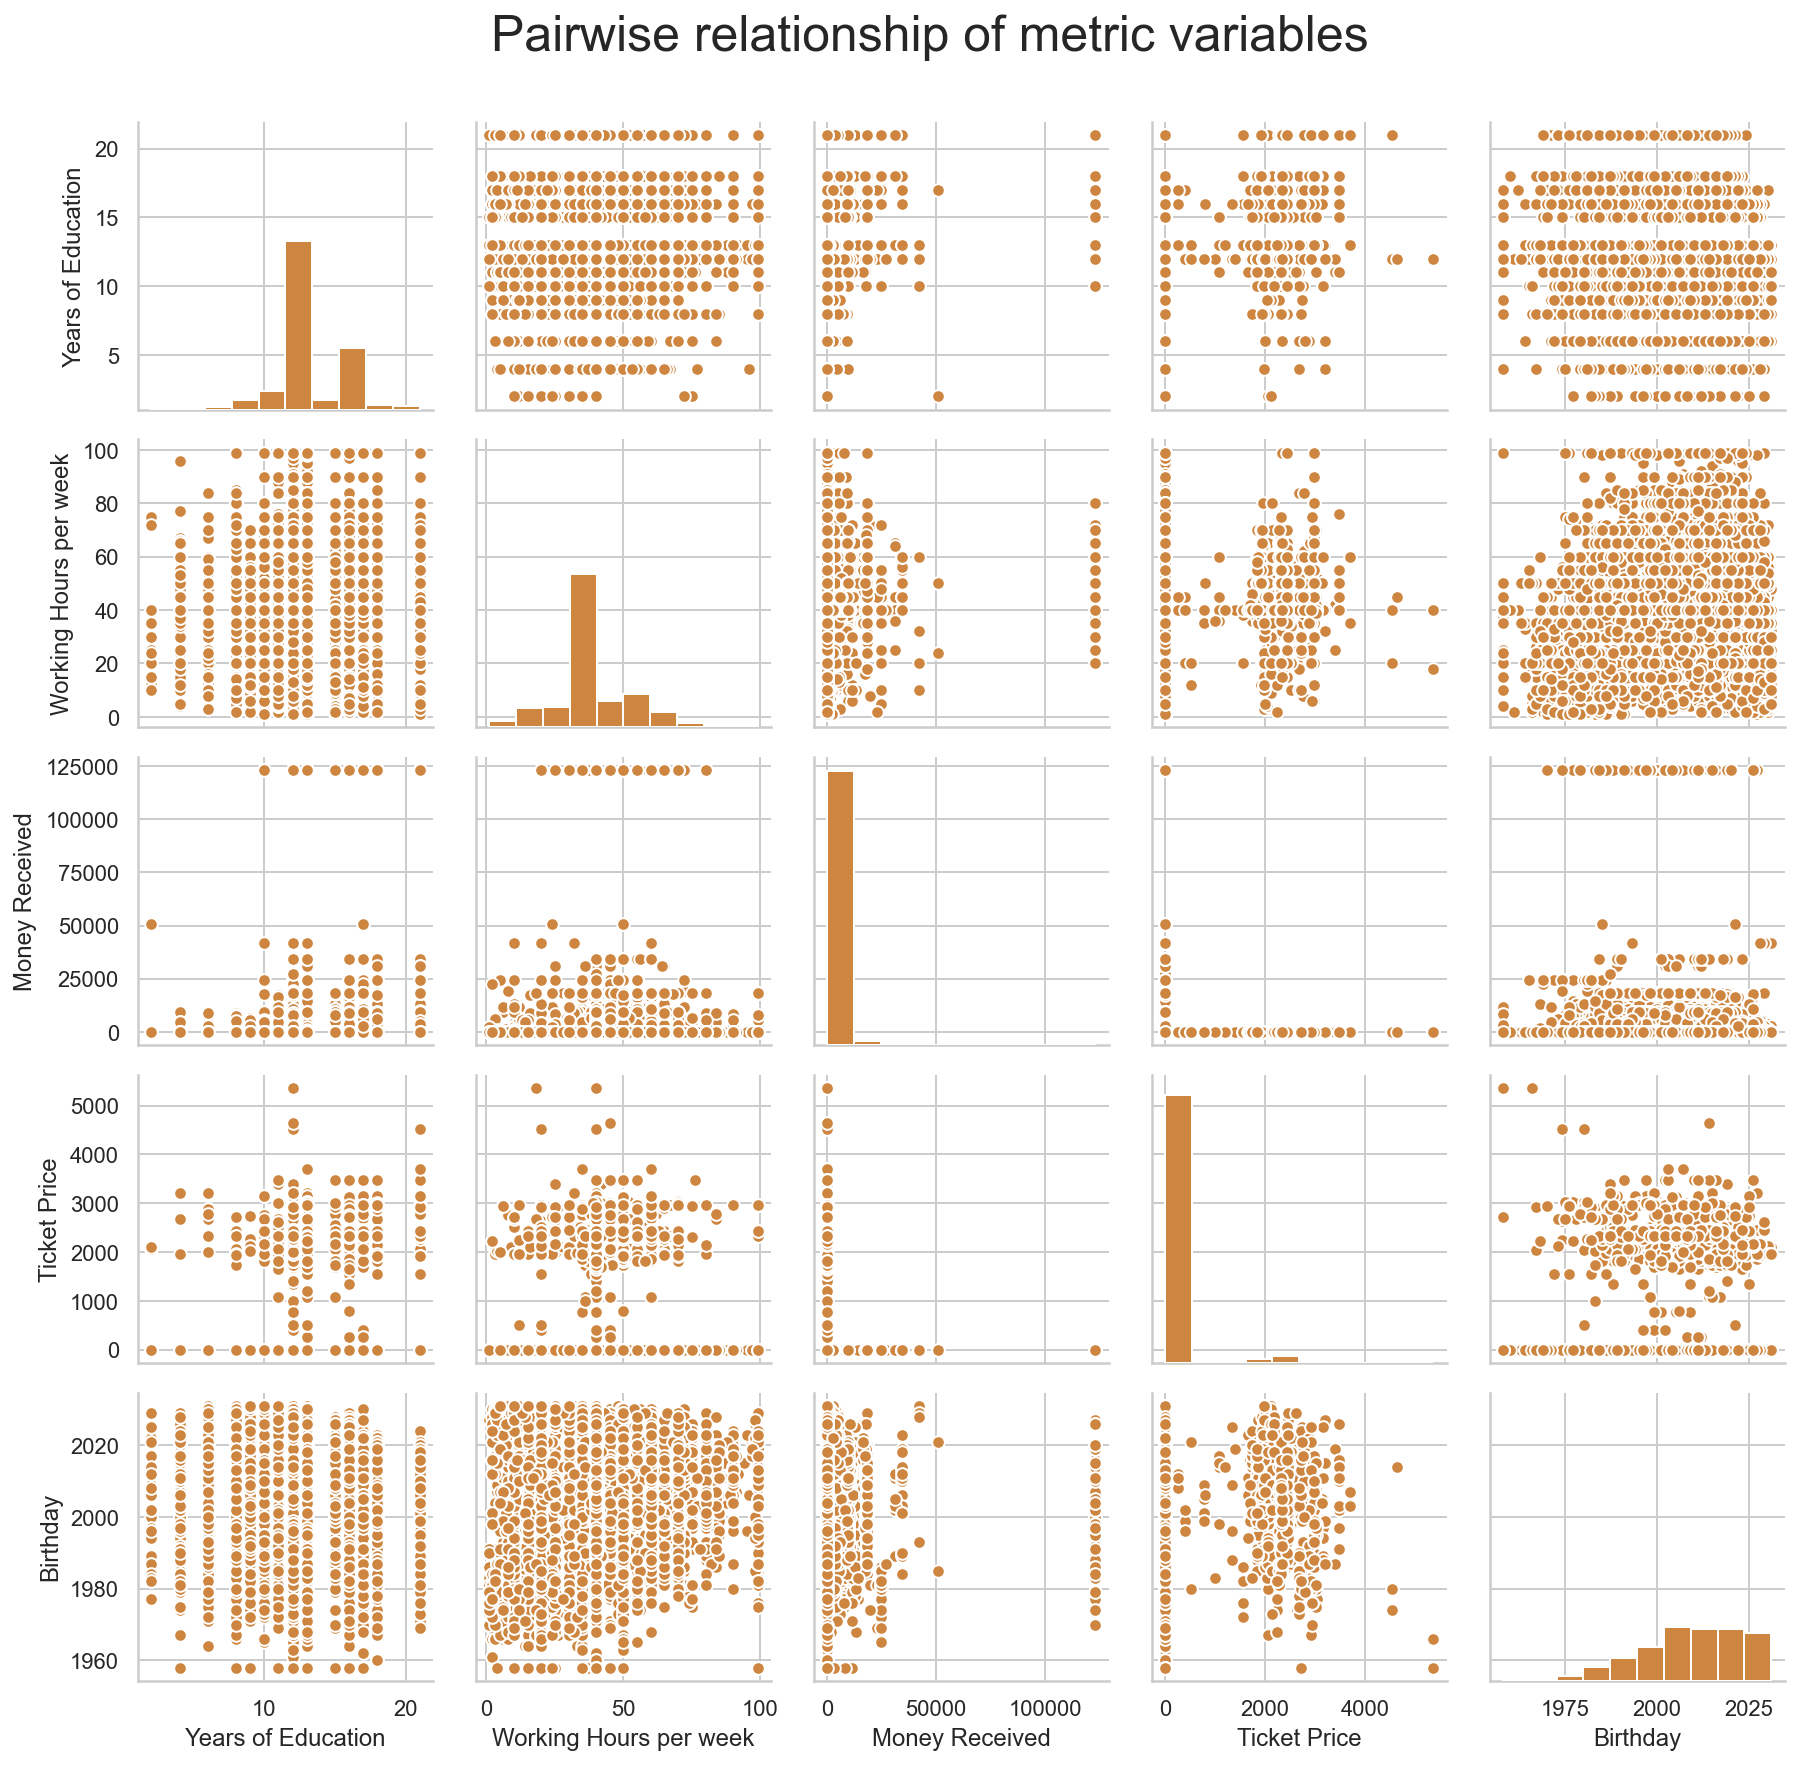

In [10]:
# Checking metrics variables' distribution and pairwise relationship
sns.set(style="whitegrid")

# Setting pairgrid
g = sns.PairGrid(metric)

# Populating pairgrid
mdg = g.map_diag(plt.hist, edgecolor="w", color="peru")
mog = g.map_offdiag(plt.scatter, edgecolor="w", color="peru", s=40)
    
# Layout
plt.subplots_adjust(top=0.92)
plt.suptitle("Pairwise relationship of metric variables", fontsize=25)

plt.show()

C:\Users\ruifi\anaconda3\envs\MLclasses\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ruifi\anaconda3\envs\MLclasses\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ruifi\anaconda3\envs\MLclasses\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

Text(0.5, 0.98, 'Distribution of non-metric variables')

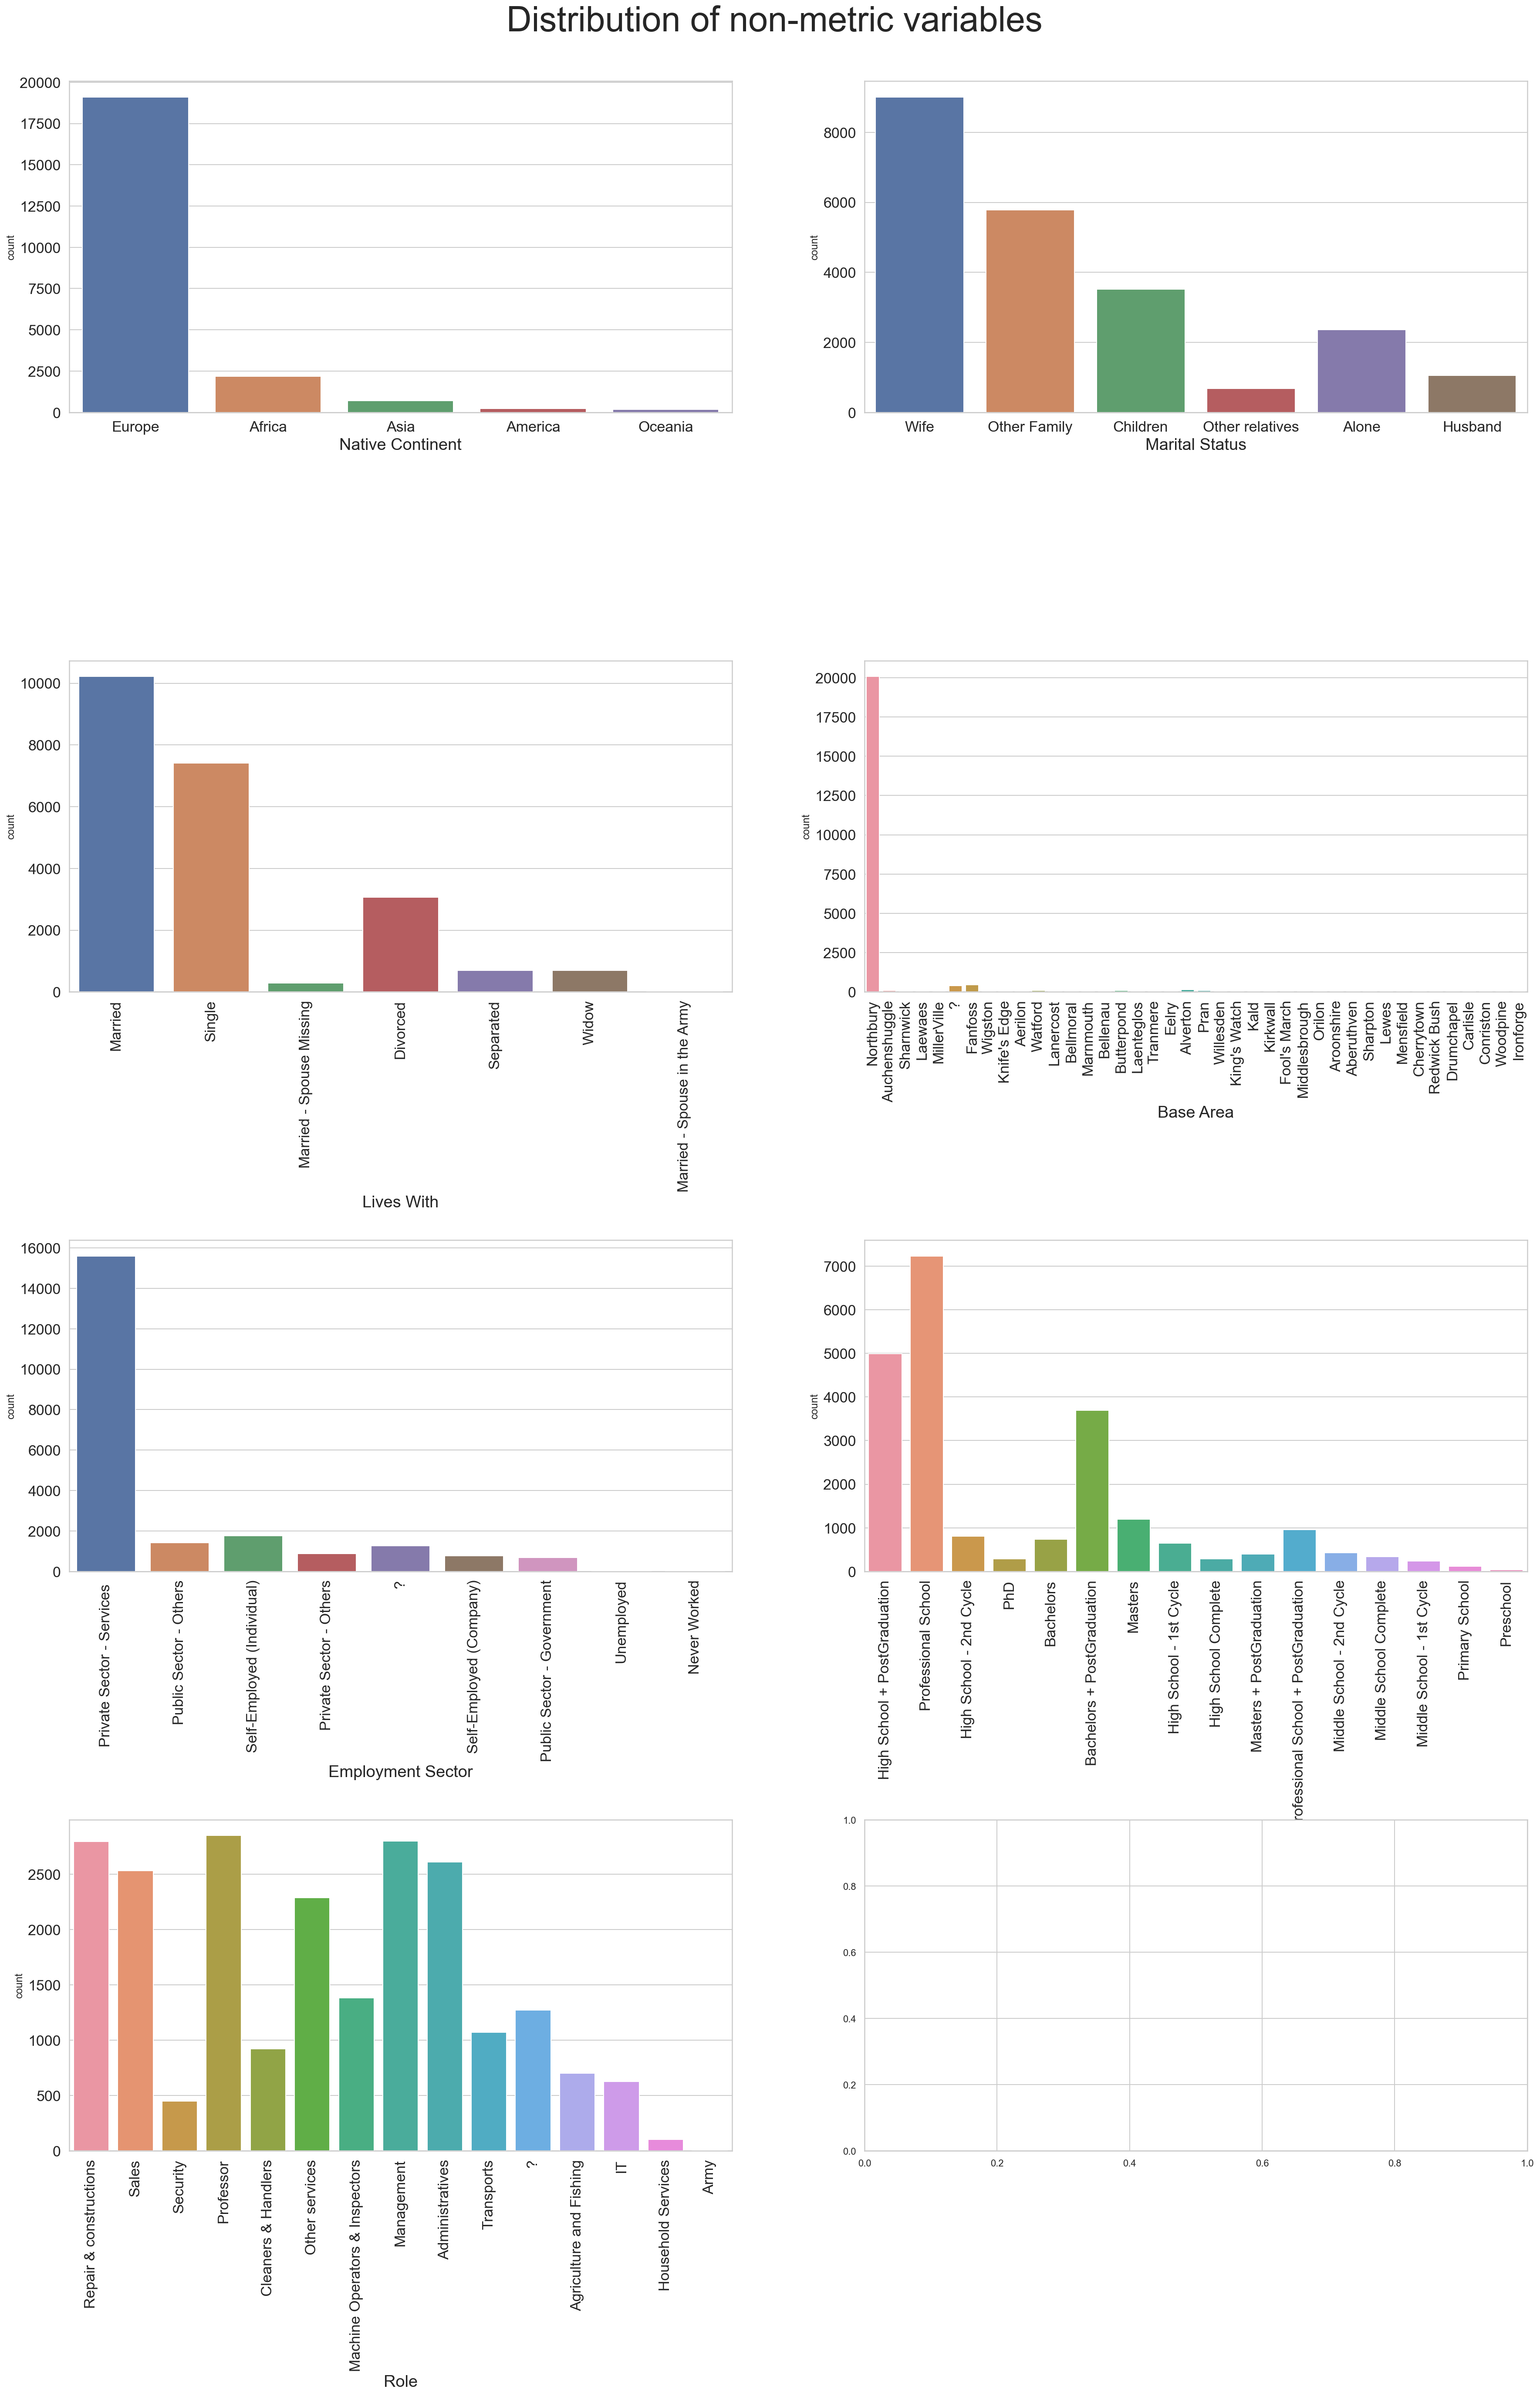

In [11]:
# Funciona
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(30,40))

ax1=sns.countplot(non_metric["Native Continent"], ax=axes[0,0])
ax2=sns.countplot(non_metric["Lives with"], ax=axes[0,1])
ax3=sns.countplot(non_metric["Marital Status"], ax=axes[1,0])
ax4=sns.countplot(non_metric["Base Area"], ax=axes[1,1])
ax5=sns.countplot(non_metric["Employment Sector"], ax=axes[2,0])
ax6=sns.countplot(non_metric["Education Level"], ax=axes[2,1])
ax7=sns.countplot(non_metric["Role"], ax=axes[3,0])
# ax8=sns.countplot(non_metric["Birthday"], ax=axes[3,1])

ax1.tick_params(labelsize=17)
ax1.set_xlabel(xlabel='Native Continent',fontsize = 19)

ax2.tick_params(labelsize=17)
ax2.set_xlabel(xlabel='Marital Status',fontsize = 19)

ax3.tick_params(labelsize=17)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
ax3.set_xlabel(xlabel='Lives With',fontsize = 19)

ax4.tick_params(labelsize=17)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
ax4.set_xlabel(xlabel='Base Area',fontsize = 19)

ax5.tick_params(labelsize=17)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
ax5.set_xlabel(xlabel='Employment Sector',fontsize = 19)

ax6.tick_params(labelsize=17)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=90)
ax6.set_xlabel(xlabel='Education Level',fontsize = 19)

ax7.tick_params(labelsize=17)
ax7.set_xticklabels(ax7.get_xticklabels(), rotation=90)
ax7.set_xlabel(xlabel='Role',fontsize = 19)

# ax8.tick_params(labelsize=17)
# ax8.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax8.set_xlabel(xlabel='Birthday',fontsize = 19)

plt.subplots_adjust(top=0.95,hspace=0.75)
plt.suptitle("Distribution of non-metric variables", fontsize=40)

In [12]:
# Looking at the plots above, we can see the distribution of the values per category, for each categorical variables.
# With this, we see that there are 3 variables containing "?" as a value, which we understand are be null values
# So, here we are replacing those ? for null values, to analyze them more efficiently
df_train=df_train.replace('?', np.nan)

In [13]:
# Now we can already see how many missing values each variable has
df_train.isna().sum()

Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
dtype: int64

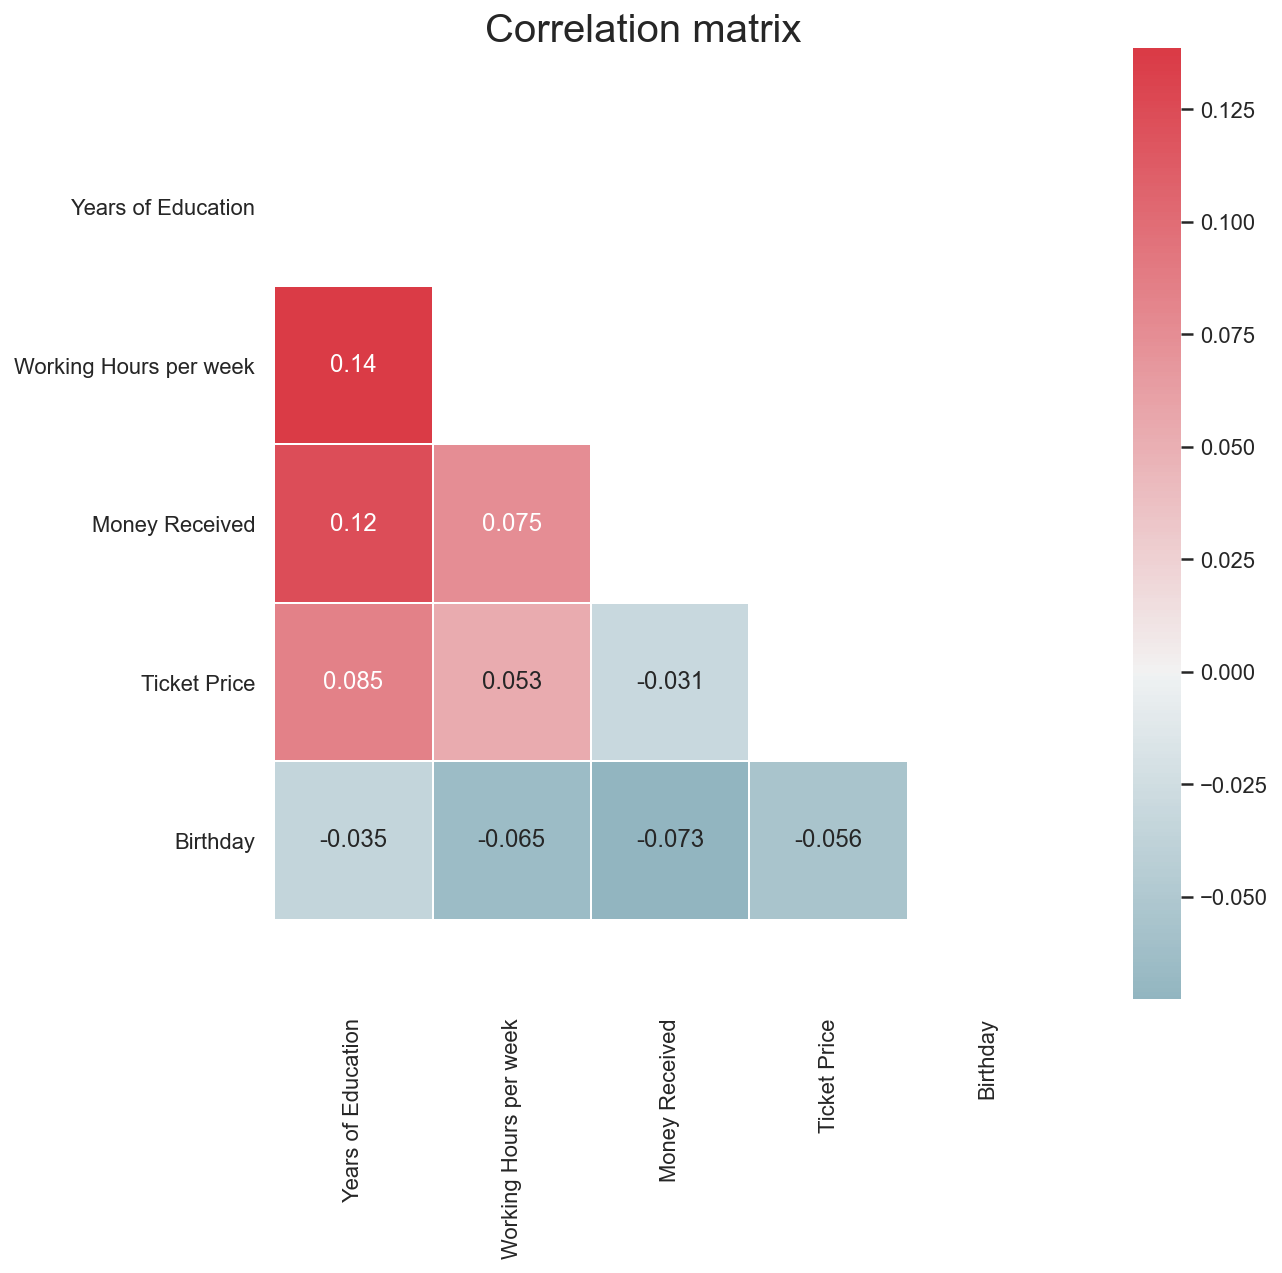

In [14]:
#inutil mas func
sns.set(style="white")

# Compute the correlation matrix
corr = metric.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax, annot=True)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
# Fixing the bug of partially cut-off bottom and top cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [15]:
pd.set_option('display.max_rows', 500)
df_train.groupby(["Base Area","Role"])["Role"].count()

Base Area      Role                          
Aberuthven     Administratives                      5
               Cleaners & Handlers                  3
               Household Services                   1
               IT                                   1
               Machine Operators & Inspectors       4
               Other services                       2
               Professor                            1
               Repair & constructions               4
               Sales                                2
Aerilon        Administratives                      2
               Agriculture and Fishing              1
               Cleaners & Handlers                  6
               Household Services                   1
               IT                                   2
               Machine Operators & Inspectors       6
               Management                           3
               Other services                       1
               Professor            

In [16]:
pd.crosstab(df_train['Base Area'], df_train['Role'],  margins = True)

Role           Administratives  Agriculture and Fishing  Army  \
Base Area                                                       
Aberuthven                   5                        0     0   
Aerilon                      2                        1     0   
Alverton                    28                        3     0   
Aroonshire                   7                        1     0   
Auchenshuggle                3                        2     0   
Bellenau                     0                        0     0   
Bellmoral                    6                        0     0   
Butterpond                  14                        0     0   
Carlisle                     4                        0     0   
Cherrytown                   3                        0     0   
Conriston                    1                        0     0   
Drumchapel                   3                        1     0   
Eelry                        7                        2     0   
Fanfoss                     25                       48     0   
Fool's March                 4                        1     0   
Ironforge                    0                        0     0   
Kald                         1                        1     0   
King's Watch                 2                        3     0   
Kirkwall                     5                        1     0   
Knife's Edge                 2                        0     0   
Laenteglos                   1                        0     0   
Laewaes                      8                        1     0   
Lanercost                   13                        0     0   
Lewes                        0                        1     0   
Marnmouth                    1                        0     0   
Mensfield                    0                        0     0   
Middlesbrough                0                        1     0   
MillerVille                  2                        1     0   
Northbury                 2384                      626     5   
Orilon                       1                        0     0   
Pran                        13                        4     0   
Redwick Bush                 1                        0     0   
Sharnwick                   10                        0     0   
Sharpton                     2                        0     0   
Tranmere                     4                        0     0   
Watford                      9                        2     0   
Wigston                      4                        0     0   
Willesden                    1                        0     0   
Woodpine                     1                        0     0   
All                       2577                      700     5   

Role           Cleaners & Handlers  Household Services   IT  \
Base Area                                                     
Aberuthven                       3                   1    1   
Aerilon                          6                   1    2   
Alverton                         4                   1    9   
Aroonshire                       3                   1    0   
Auchenshuggle                    7                   5    0   
Bellenau                         0                   0    0   
Bellmoral                        2                   1    1   
Butterpond                       4                   0    1   
Carlisle                         0                   0    2   
Cherrytown                       4                   1    0   
Conriston                        0                   0    0   
Drumchapel                       3                   0    0   
Eelry                            3                   0    0   
Fanfoss                         48                   9    1   
Fool's March                     2                   2    2   
Ironforge                        0                   0    0   
Kald                             0                   1    1   
King's Watch                     6                   8    2   
Kirkwall 

In [17]:
pd.crosstab(df_train['Marital Status'], df_train['Lives with'], margins=True)

Lives with                    Alone  Children  Husband  Other Family  \
Marital Status                                                         
Divorced                       1113       227        0          1657   
Married                           0        73     1042            12   
Married - Spouse Missing         85        33        0           141   
Married - Spouse in the Army      0         1        7             0   
Separated                       302        69        0           289   
Single                          607      3106        0          3281   
Widow                           255        10        0           397   
All                            2362      3519     1049          5777   

Lives with                    Other relatives  Wife    All  
Marital Status                                              
Divorced                                   75     0   3072  
Married                                    85  9007  10219  
Married - Spouse Missing                   25     0    284  
Married - Spouse in the Army                1     5     14  
Separated                                  39     0    699  
Single                                    422     0   7416  
Widow                                      34     0    696  
All                                       681  9012  22400

## Coherence Checks

In [18]:
#MUDAR
#Check if there is someone with more than 70 years that has Employment Sector not null
df_train[(metric.Birthday<1978)]
#& (metric["Money Received"]==0)] that did not receive money to go

Name   Birthday Native Continent  \
CITIZEN_ID                                                        
12530           Mrs. Carolyn Tucker 1976-02-03           Europe   
12535                Mr. Evan Young 1975-02-13           Europe   
12556             Mr. Jason MacLeod 1975-05-06           Europe   
12633         Mr. Brandon Henderson 1969-03-29           Europe   
12641               Mr. Joe Simpson 1974-08-10           Europe   
12706              Mr. Joe Morrison 1972-08-25           Europe   
12738              Mr. Andrew Grant 1977-02-13           Europe   
12739            Mr. Christian Knox 1965-08-08           Europe   
12783            Mr. Nathan Skinner 1958-03-14           Europe   
12813          Mrs. Felicity Bailey 1972-01-20           Europe   
12950           Mrs. Lauren Cornish 1971-08-04           Africa   
13064            Mrs. Diana Roberts 1974-06-16           Europe   
13091            Mrs. Irene McGrath 1977-04-06           Europe   
13175           Mrs. Pippa Rampling 1975-02-06           Europe   
13213                Mrs. Karen Lee 1976-05-09           Europe   
13248                 Mr. Matt Ince 1975-01-26           Europe   
13479             Mr. Dominic Allan 1968-08-31           Europe   
13480               Mrs. Emily Hill 1972-03-12           Europe   
13721               Mrs. Amy Miller 1976-01-27           Africa   
13808          Mr. Nicholas Randall 1974-10-07           Europe   
13810          Mrs. Vanessa Abraham 1975-06-21           Europe   
13883               Mr. Dylan Allan 1971-05-30           Europe   
13889                Mr. Adam Peake 1970-07-30             Asia   
13900            Mr. Dylan Hemmings 1977-05-28           Europe   
13927          Mrs. Jennifer Peters 1969-03-25           Europe   
13949             Mr. Joseph Miller 1958-04-14           Europe   
13979          Mrs. Megan Henderson 1967-03-16           Europe   
13987         Mrs. Lauren Churchill 1977-01-11           Europe   
14168             Mr. David Simpson 1974-03-22           Europe   
14346            Mr. Benjamin White 1977-01-16           Europe   
14398             Mrs. Sally Arnold 1965-09-21           Europe   
14496               Mr. Max Pullman 1977-08-25           Europe   
14551            Mrs. Rose Clarkson 1958-01-19           Europe   
15031             Mr. David Burgess 1958-08-25           Africa   
15039               Mr. Max Stewart 1977-07-13           Europe   
15063              Mr. Tim Mitchell 1958-01-20           Europe   
15066              Mrs. Molly Clark 1977-01-10           Europe   
15121             Mr. Paul Ferguson 1976-02-05           Europe   
15172              Mr. Joseph Poole 1969-08-04           Europe   
15232              Miss Lisa Gibson 1974-05-01           Europe   
15284         Mrs. Penelope Cameron 1964-08-08           Europe   
15314             Mr. Adam Metcalfe 1972-01-29           Europe   
15426          Mrs. Joanne Hamilton 1974-07-22           Africa   
15457            Mr. Nicholas Payne 1972-04-03           Europe   
15487                 Mr. Sam Grant 1977-02-28           Europe   
15513         Mr. Michael Underwood 1977-06-04          America   
15593           Mrs. Theresa Taylor 1977-06-10           Europe   
15607          Mrs. Theresa MacLeod 1973-05-20           Europe   
15616             Mr. Cameron Welch 1958-02-25           Europe   
15625               Mr. Phil Bailey 1964-04-10           Europe   
15645             Mr. Stewart Walsh 1967-09-10           Europe   
15681               Mr. Luke Mathis 1976-06-17           Europe   
15792                 Mr. Eric Reid 1974-06-06           Africa   
15826            Mrs. Sally Cameron 1975-08-29           Europe   
15902                Mr. Colin Kerr 1976-04-24           Europe   
15914                 Mr. Tim Sharp 1973-04-20           Europe   
15928               Mr. Neil Watson 1969-06-04           Europe   
15951              Mrs. Emma Greene 1958-09-09           Africa   
15963      

In [19]:
# Check if there is anyone born after the year of this experiment (2048) 
len(df_train[(metric.Birthday>2048)])

0

In [20]:
# Check the oldest year of birth and most recent one
print(metric.Birthday.min(),metric.Birthday.max())

1958 2031


In [21]:
# Check if there are negative amounts of money
df_train[(df_train["Money Received"]<0)|(df_train["Ticket Price"]<0)]

Empty DataFrame
Columns: [Name, Birthday, Native Continent, Marital Status, Lives with, Base Area, Education Level, Years of Education, Employment Sector, Role, Working Hours per week, Money Received, Ticket Price]
Index: []

In [22]:
# Check if there is anyone who paid for the ticket and at the same time received money to join the experiment
df_train[(df_train["Ticket Price"]!=0) & (df_train["Money Received"]!=0)]

Empty DataFrame
Columns: [Name, Birthday, Native Continent, Marital Status, Lives with, Base Area, Education Level, Years of Education, Employment Sector, Role, Working Hours per week, Money Received, Ticket Price]
Index: []

In [23]:
# Check if there is anyone with a certain level of education and years of education that don't match at all
df_train.groupby(["Years of Education","Education Level"])["Years of Education"].mean()

Years of Education  Education Level                     
2                   Preschool                                2
4                   Primary School                           4
6                   Middle School - 1st Cycle                6
8                   Middle School - 2nd Cycle                8
9                   Middle School Complete                   9
10                  High School - 1st Cycle                 10
11                  High School - 2nd Cycle                 11
12                  High School Complete                    12
                    Professional School                     12
13                  High School + PostGraduation            13
                    Professional School + PostGraduation    13
15                  Bachelors                               15
16                  Bachelors + PostGraduation              16
17                  Masters                                 17
18                  Masters + PostGraduation                1

In [24]:
df_train['Education Level']=df_train['Education Level'].replace('Preschool', 'No Relevant Education')

In [25]:
df_train["Education Level"].unique()

array(['High School + PostGraduation', 'Professional School',
       'High School - 2nd Cycle', 'PhD', 'Bachelors',
       'Bachelors + PostGraduation', 'Masters', 'High School - 1st Cycle',
       'High School Complete', 'Masters + PostGraduation',
       'Professional School + PostGraduation',
       'Middle School - 2nd Cycle', 'Middle School Complete',
       'Middle School - 1st Cycle', 'Primary School',
       'No Relevant Education'], dtype=object)

In [26]:
df_train['Years of Education']=df_train['Years of Education'].replace(2, 0)

In [27]:
df_train["Years of Education"].unique()


array([13, 12, 11, 21, 15, 16, 17, 10, 18,  8,  9,  6,  4,  0],
      dtype=int64)

In [28]:
# Check if there is anyone whose marital status seems incoherent with the person he/she lives with someone
df_train.groupby(["Marital Status","Lives with"] )["Lives with"].count()

Marital Status                Lives with     
Divorced                      Alone              1113
                              Children            227
                              Other Family       1657
                              Other relatives      75
Married                       Children             73
                              Husband            1042
                              Other Family         12
                              Other relatives      85
                              Wife               9007
Married - Spouse Missing      Alone                85
                              Children             33
                              Other Family        141
                              Other relatives      25
Married - Spouse in the Army  Children              1
                              Husband               7
                              Other relatives       1
                              Wife                  5
Separated                     Alone 

In [29]:
#AQUIII

ola=df_train.copy()
ola["age"]=2048-ola.Birthday.map(lambda x: x.year)
ola[ola.Birthday.map(lambda x: 2048-x.year)<(ola["Years of Education"]+5)]

Name   Birthday Native Continent Marital Status  \
CITIZEN_ID                                                                     
14941       Miss Yvonne Henderson 2029-03-25           Africa         Single   
16528             Miss Ava Glover 2028-07-15           Africa         Single   
24242         Miss Pippa Anderson 2024-02-01           Europe         Single   
24843           Mr. Gavin Thomson 2028-09-13           Europe         Single   
27833            Miss Sue Randall 2030-04-08           Europe         Single   
28849         Mr. Jonathan Oliver 2031-02-05           Europe         Single   
33939             Mr. Isaac Alsop 2027-04-20           Europe         Single   

                 Lives with     Base Area               Education Level  \
CITIZEN_ID                                                                
14941              Children     Lanercost    Bachelors + PostGraduation   
16528       Other relatives     Northbury    Bachelors + PostGraduation   
24242          Other Family  Fool's March                           PhD   
24843              Children     Northbury                       Masters   
27833              Children     Northbury                       Masters   
28849              Children     Northbury  High School + PostGraduation   
33939              Children     Northbury                       Masters   

            Years of Education           Employment Sector             Role  \
CITIZEN_ID                                                                    
14941                       16                         NaN              NaN   
16528                       16  Private Sector - Services             Sales   
24242                       21     Private Sector - Others        Professor   
24843                       17  Private Sector - Services        Management   
27833                       17      Public Sector - Others        Professor   
28849                       13  Private Sector - Services   Administratives   
33939                       17     Private Sector - Others       Transports   

            Working Hours per week  Money Received  Ticket Price  age  
CITIZEN_ID                                                             
14941                           40               0             0   19  
16528                           30               0             0   20  
24242                           99               0             0   24  
24843                           25               0             0   20  
27833                           60               0             0   18  
28849                           20               0             0   17  
33939                           15               0             0   21

In [30]:
# Check if there is anyone with more years of education than his/her age
df_train[df_train.Birthday.map(lambda x: 2048-x.year)<(df_train["Years of Education"]+5)]

Name   Birthday Native Continent Marital Status  \
CITIZEN_ID                                                                     
14941       Miss Yvonne Henderson 2029-03-25           Africa         Single   
16528             Miss Ava Glover 2028-07-15           Africa         Single   
24242         Miss Pippa Anderson 2024-02-01           Europe         Single   
24843           Mr. Gavin Thomson 2028-09-13           Europe         Single   
27833            Miss Sue Randall 2030-04-08           Europe         Single   
28849         Mr. Jonathan Oliver 2031-02-05           Europe         Single   
33939             Mr. Isaac Alsop 2027-04-20           Europe         Single   

                 Lives with     Base Area               Education Level  \
CITIZEN_ID                                                                
14941              Children     Lanercost    Bachelors + PostGraduation   
16528       Other relatives     Northbury    Bachelors + PostGraduation   
24242          Other Family  Fool's March                           PhD   
24843              Children     Northbury                       Masters   
27833              Children     Northbury                       Masters   
28849              Children     Northbury  High School + PostGraduation   
33939              Children     Northbury                       Masters   

            Years of Education           Employment Sector             Role  \
CITIZEN_ID                                                                    
14941                       16                         NaN              NaN   
16528                       16  Private Sector - Services             Sales   
24242                       21     Private Sector - Others        Professor   
24843                       17  Private Sector - Services        Management   
27833                       17      Public Sector - Others        Professor   
28849                       13  Private Sector - Services   Administratives   
33939                       17     Private Sector - Others       Transports   

            Working Hours per week  Money Received  Ticket Price  
CITIZEN_ID                                                        
14941                           40               0             0  
16528                           30               0             0  
24242                           99               0             0  
24843                           25               0             0  
27833                           60               0             0  
28849                           20               0             0  
33939                           15               0             0

In [31]:
#unemployed citizens have Role and Working Hours different than 0
df_train[["Employment Sector", "Role", "Working Hours per week"]][df_train["Employment Sector"]=="Unemployed"]

Employment Sector                     Role  Working Hours per week
CITIZEN_ID                                                                   
12567             Unemployed      Cleaners & Handlers                      40
15572             Unemployed  Agriculture and Fishing                      10
16852             Unemployed               Transports                      20
17274             Unemployed          Administratives                      12
21062             Unemployed  Agriculture and Fishing                      50
22741             Unemployed  Agriculture and Fishing                      20
27493             Unemployed   Repair & constructions                      40
29340             Unemployed  Agriculture and Fishing                      65
33010             Unemployed           Other services                      55
33412             Unemployed  Agriculture and Fishing                      50
33618             Unemployed          Administratives                      30
33720             Unemployed          Administratives                      16

In [32]:
#Never worked citizens have Role and Working Hours different than 0
df_train[["Employment Sector", "Role", "Working Hours per week"]][df_train["Employment Sector"]=="Never Worked"]

Employment Sector Role  Working Hours per week
CITIZEN_ID                                               
13792           Never Worked  NaN                      40
22674           Never Worked  NaN                      30
23583           Never Worked  NaN                      10
24701           Never Worked  NaN                      40
27002           Never Worked  NaN                       4
32390           Never Worked  NaN                      40
33185           Never Worked  NaN                      35

In [33]:
df_train["Working Hours per week"][(df_train["Employment Sector"]=="Unemployed") | (df_train["Employment Sector"]=="Never Worked")]=0

<ipython-input-33-12ba63825440>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Working Hours per week"][(df_train["Employment Sector"]=="Unemployed") | (df_train["Employment Sector"]=="Never Worked")]=0


In [34]:
df_train["Role"][(df_train["Employment Sector"]=="Never Worked")]="No Role"

<ipython-input-34-96312930b535>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Role"][(df_train["Employment Sector"]=="Never Worked")]="No Role"


In [35]:
df_train[["Employment Sector", "Role", "Working Hours per week"]][(df_train["Employment Sector"]=="Unemployed") | (df_train["Employment Sector"]=="Never Worked")]

Employment Sector                     Role  Working Hours per week
CITIZEN_ID                                                                   
12567             Unemployed      Cleaners & Handlers                       0
13792           Never Worked                  No Role                       0
15572             Unemployed  Agriculture and Fishing                       0
16852             Unemployed               Transports                       0
17274             Unemployed          Administratives                       0
21062             Unemployed  Agriculture and Fishing                       0
22674           Never Worked                  No Role                       0
22741             Unemployed  Agriculture and Fishing                       0
23583           Never Worked                  No Role                       0
24701           Never Worked                  No Role                       0
27002           Never Worked                  No Role                       0
27493             Unemployed   Repair & constructions                       0
29340             Unemployed  Agriculture and Fishing                       0
32390           Never Worked                  No Role                       0
33010             Unemployed           Other services                       0
33185           Never Worked                  No Role                       0
33412             Unemployed  Agriculture and Fishing                       0
33618             Unemployed          Administratives                       0
33720             Unemployed          Administratives                       0

## Outliers

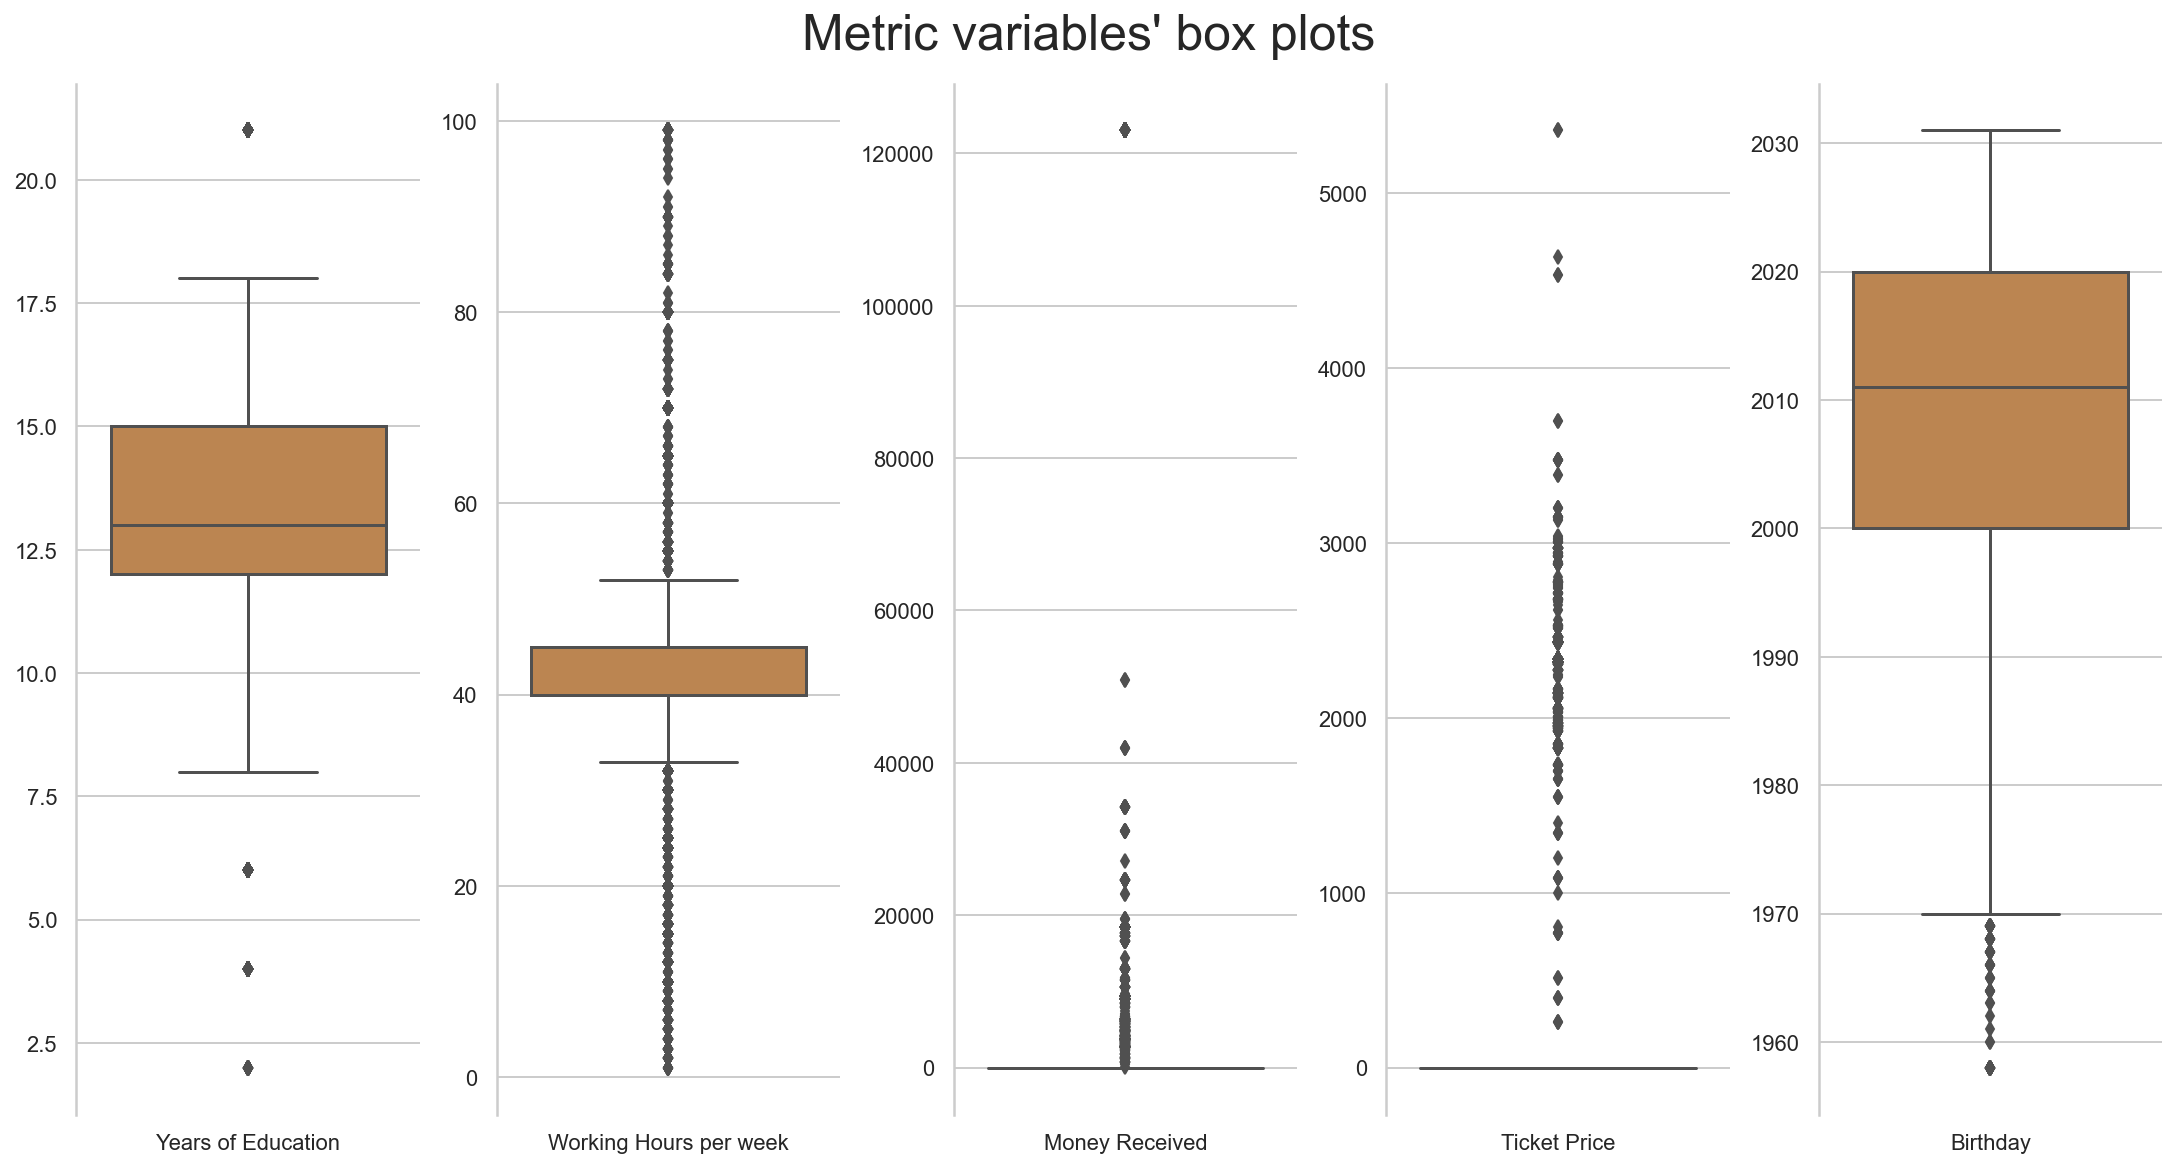

In [36]:
sns.set(style="whitegrid")

data = pd.melt(metric)
plot_features = metric.columns

#Prepare figure layout
fig, axes = plt.subplots(1, len(plot_features), figsize=(15,8), constrained_layout=True)
    
# Draw the boxplots
for i in zip(axes, plot_features):
    sns.boxplot(x="variable", y="value", data=data.loc[data["variable"]==i[1]], ax=i[0], color='peru')
    i[0].set_xlabel("")
    i[0].set_ylabel("")

# Finalize the plot
plt.suptitle("Metric variables' box plots", fontsize=25)
sns.despine(bottom=True)

plt.show()

In [37]:
#test
df_train[df_train["Money Received"]==122999] 

Name   Birthday Native Continent  \
CITIZEN_ID                                                        
12667          Mr. Alexander Duncan 1997-03-17          Oceania   
12839                 Mr. Sam Black 1985-05-26           Europe   
13363             Mr. Jason Dickens 2009-01-20           Europe   
13419                Mr. Harry Parr 1999-09-29           Europe   
13445              Mr. Jacob Wilson 2008-06-28           Europe   
13557              Mr. Liam Abraham 1995-05-17           Europe   
13759            Mrs. Lauren Morgan 2012-07-31           Africa   
13809                 Mr. Jack Kerr 2008-05-23             Asia   
14070           Mr. Joseph Buckland 1992-07-20           Europe   
14113          Mr. Michael Johnston 2011-06-23           Europe   
14545         Mrs. Bernadette Allan 1999-04-03           Europe   
15047               Mr. Peter Short 2017-01-10             Asia   
15137               Mr. Jason Short 2020-07-25           Africa   
15158             Mr. Steven Mackay 2005-05-13           Europe   
15233             Mrs. Ava Metcalfe 1992-02-22           Europe   
15487                 Mr. Sam Grant 1977-02-28           Europe   
15614         Mr. Christopher Walsh 2012-08-23           Europe   
15689              Mr. Lucas Glover 1993-02-25           Europe   
16717                 Mr. Sam Jones 1990-06-15           Europe   
16772              Mr. Connor Baker 2000-03-08           Europe   
16917            Mr. Stewart Watson 1989-05-29             Asia   
16971             Mr. Adrian Martin 1995-09-27             Asia   
16980                Mr. Liam Walsh 2007-09-07           Europe   
17299              Mr. Ryan Forsyth 2005-04-12           Europe   
17669           Mr. Brandon Jackson 2010-10-03           Europe   
18248            Mr. Jason Ferguson 2008-03-20           Europe   
18761           Mr. Thomas Ferguson 2004-01-19           Europe   
19060              Mr. Phil Cornish 2006-04-08           Europe   
19124            Mr. Michael Murray 1999-02-25           Europe   
19131            Mr. Thomas Jackson 2005-02-28           Europe   
19247              Mr. Brandon Bond 2007-07-31           Europe   
19322                Mr. Max Peters 2012-03-03           Europe   
19386            Mr. Blake Morrison 2002-05-20           Europe   
19478              Mr. Isaac Arnold 2001-04-25           Europe   
19498               Mr. Frank Avery 1993-01-16           Europe   
19509          Mr. Robert Sanderson 1996-10-07           Europe   
19663            Mr. Dominic Davies 2002-05-01           Europe   
20146             Mrs. Julia Martin 2007-08-09           Africa   
20169               Mr. Dan Stewart 1998-05-19           Europe   
20173              Mr. Ryan Vaughan 2006-01-14           Europe   
20399               Mr. Sean Hunter 2009-05-16           Europe   
20594              Mr. Adrian Kelly 2005-04-14           Europe   
21274              Mr. Alan Cameron 2018-01-04           Europe   
21310                Miss Chloe May 2027-06-24           Africa   
21858            Mr. Jacob Johnston 1974-07-26           Europe   
22203           Mr. Boris Sanderson 1999-07-24           Europe   
22407               Mr. Joseph Gray 2016-10-03           Europe   
22461        Mrs. Elizabeth Dickens 1997-07-14           Europe   
22520           Mr. Michael Wallace 2001-03-25           Europe   
23183             Mr. Brandon Vance 2002-06-12           Europe   
23199           Mr. Benjamin Wright 2001-04-24             Asia   
23236           Mrs. Stephanie Knox 1995-01-13           Europe   
23717         Mr. Christopher Poole 2007-04-19           Europe   
24230              Mr. Phil Burgess 1983-04-30           Europe   
24549               Mr. Harry Kelly 2004-10-10           Europe   
24585             Mr. Connor Newman 1998-07-14           Europe   
24603            Mr. Jonathan Baker 2010-07-07           Europe   
24684                Mr. Owen Clark 2001-02-19           Europe   
25405      

In [38]:
df_train["Working Hours per week"].describe()

count    22400.000000
mean        40.456696
std         12.414943
min          0.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Working Hours per week, dtype: float64

#RECOMENTAR

#using the IQR method to filter outliers: the scatter plot was impossible to analyze with the outliers, and there are some
#very extreme values on 'precoContratual' and, especially, on 'prazoExecucao'

#calculate the first and third quantiles:
q25 = df_train['Working Hours per week'].quantile(.25)
q75 = df_train['Working Hours per week'].quantile(.75)
#calculate the inter-quartile range:
iqr = (q75 - q25)

#calculate the lower and upper fence:
multiplicator = 6 #5 or 6 looks better; with 1.5 (the "official") or 2 you delete too much of the data
upper_lim = q75 + multiplicator * iqr
lower_lim = q25 - multiplicator * iqr

#filtering the outliers based on the IQR limits
df_train_new = df_train[(df_train['Working Hours per week'] > lower_lim) & (df_train['Working Hours per week'] < upper_lim)]
print('Percentage of data kept after removing outliers:', np.round(df_train_new.shape[0] / df_train.shape[0], 4))

We decided not to eliminate outliers on "Money Received", since when observing the value that was more distant from the rest, we concluded that there were several people with that high value (122999), all having a relatively important role and high hours of work. 

Also, we do not consider relevant the amount itself of money received or payed, but instead, if the person received or payed to go. 

sns.set(style="whitegrid")
sns.boxplot(x="Working Hours per week", data=df_train_new, color='peru')
plt.suptitle("Working Hours Without Outliers", fontsize=20)
plt.show()

In [39]:
#number of citizens that have less than 7.5 years of education to conclude if they might be outliers
len(df_train[df_train["Years of Education"]<7.5])

392

In [40]:
#NAO USAMOS

# normality test
stat, p = shapiro(df_train["Working Hours per week"])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.885, p=0.000
Sample does not look Gaussian (reject H0)


C:\Users\ruifi\anaconda3\envs\MLclasses\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Missing Values

#### 1st method - impute with the mode

In [41]:
df_train.isna().sum()

Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1264
Working Hours per week       0
Money Received               0
Ticket Price                 0
dtype: int64

In [42]:
df_train1=df_train.copy()

In [43]:
modes = non_metric.mode().loc[0]
df_train1.fillna(modes, inplace=True)

#### 2nd method - imupte with the mode of categories in common

In [44]:
# understand if certain non-numeric variables are dependent or not from the ones with missing values

In [45]:
# Create a function that performs the Chi2 test for independence, to check for association between each variable with no missing
# values and each of the ones with missings

def check_association(col1,col2):
    # contingency table
    tab=pd.crosstab(df_train[col1], df_train[col2], margins=False).values
    stat, p, dof, expected = chi2_contingency(tab)

    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    
    if abs(stat) >= critical:
        print(col1,'and',col2,'are dependent (reject H0).')
    else:
        print(col1,'and',col2,'are independent (fail to reject H0).')
        
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    
    if p <= alpha:
        print(col1,'and',col2,'are dependent (reject H0).\n')
    else:
        print(col1,'and',col2,'are independent (fail to reject H0).\n')

In [46]:
# FIRST: Marital Status

check_association('Marital Status','Base Area')
check_association('Marital Status','Employment Sector')
check_association('Marital Status','Role')

probability=0.950, critical=264.224, stat=707.714
Marital Status and Base Area are dependent (reject H0).
significance=0.050, p=0.000
Marital Status and Base Area are dependent (reject H0).

probability=0.950, critical=58.124, stat=798.754
Marital Status and Employment Sector are dependent (reject H0).
significance=0.050, p=0.000
Marital Status and Employment Sector are dependent (reject H0).

probability=0.950, critical=106.395, stat=2136.649
Marital Status and Role are dependent (reject H0).
significance=0.050, p=0.000
Marital Status and Role are dependent (reject H0).



In [47]:
# SECOND: Education Level

check_association('Education Level','Base Area')
check_association('Education Level','Employment Sector')
check_association('Education Level','Role')

probability=0.950, critical=626.650, stat=6057.678
Education Level and Base Area are dependent (reject H0).
significance=0.050, p=0.000
Education Level and Base Area are dependent (reject H0).

probability=0.950, critical=129.918, stat=1544.322
Education Level and Employment Sector are dependent (reject H0).
significance=0.050, p=0.000
Education Level and Employment Sector are dependent (reject H0).

probability=0.950, critical=244.808, stat=10712.853
Education Level and Role are dependent (reject H0).
significance=0.050, p=0.000
Education Level and Role are dependent (reject H0).



In [48]:
# Seeing both of these variables are associated with the three variables with missing values, using the similarities between people
# in these categories, might be useful to discover their characteristics in the missing variables

In [49]:
# Copy the dataframe into another to apply the changes there before
df_train2=df_train.copy()

# Create a function to impute the missing values by the mode of the records belonging to the same classes of Marital Status and Education Level
def impute_mode_by_cat(col):
    exp=df_train2[df_train2[col].isnull()].reset_index()
    gr=df_train2.groupby(["Education Level","Marital Status"])[col].agg(pd.Series.mode)
    
    # if there are null values in the group by, replace them by the overall mode of the orginal variable
    for i in range(len(gr)):
        if len(gr[i])==0:
            gr[i]=df_train2[col].mode()[0]


    # define the values of base area in the new auxiliary dataset as the mode of the base are values for the observations with the
    # same level of education and marital status, because at least to some extent, they are more similar than the others       
    for i in range(len(exp)):
        for x in range(len(gr)):
            if (exp['Education Level'][i]==gr.index[x][0]) and (exp['Marital Status'][i]==gr.index[x][1]):
                exp[col][i]=gr[x]
                
    # if it's bimodal (has more than one mode, keep only the first one provided)
    for i in range(len(exp)):
        if type(exp[col][i])!=str:
            exp[col][i]=df_train2[col].mode()[0]

    # finally, replace the null values in Base Area in the original dataset by the values acquired before
    for i in range(len(exp)):
        df_train2.loc[exp['CITIZEN_ID'][i],col]=exp[col][i]
        
    return df_train2

In [50]:
df_train2[df_train2['Base Area'].isnull()]

Name   Birthday Native Continent  \
CITIZEN_ID                                                         
12516                 Mr. Jason Gray 2024-09-26           Africa   
12583               Mr. Joseph Avery 2008-09-06           Europe   
12700               Mr. Colin Graham 2017-02-14           Europe   
12771                 Mrs. Emma Gray 2005-02-22           Europe   
12845         Mr. Alexander Rampling 2022-02-28           Africa   
12875                 Mr. Owen Scott 2027-07-20           Europe   
12891           Mr. Anthony McDonald 2020-10-06           Europe   
12895            Mrs. Bella Hemmings 1991-05-07           Europe   
12956             Mr. William Wilson 2004-05-20           Europe   
13158                Miss Wendy Nash 2020-06-16           Europe   
13213                 Mrs. Karen Lee 1976-05-09           Europe   
13267           Mr. Steven Sanderson 2010-01-28           Europe   
13369               Mr. Julian Paige 2013-04-20           Africa   
13524            Mr. Sebastian Scott 2029-06-24           Europe   
13526             Mr. Brandon Mackay 2007-01-29           Europe   
13546                   Mr. Ian Bell 2018-09-06           Africa   
13553              Mrs. Lillian Hart 2000-07-18             Asia   
13574            Mrs. Felicity Welch 2016-04-11           Europe   
13615               Mr. Jason Martin 2016-04-24             Asia   
13661               Mr. Joseph Alsop 2007-01-10           Europe   
13697              Miss Anne Dickens 2020-03-21           Europe   
13716                Mr. Ian Coleman 2014-05-24           Europe   
13809                  Mr. Jack Kerr 2008-05-23             Asia   
13850            Mr. Cameron Cornish 2006-04-23           Europe   
13852              Miss Heather Bond 2022-08-07           Europe   
13932            Mrs. Melanie Howard 2016-01-17           Africa   
13972           Miss Virginia Hodges 2024-08-13           Europe   
13978               Mrs. Lily Fisher 1978-09-07           Europe   
14008            Miss Felicity Quinn 2015-07-15           Europe   
14086             Mr. Frank Campbell 2008-04-27           Europe   
14091                Mr. Harry Poole 2001-01-07           Europe   
14307                 Mr. Liam Blake 2021-09-29           Europe   
14309                  Mr. Alan King 2012-05-10           Europe   
14450              Mr. Dominic Jones 2017-01-11           Africa   
14517          Mrs. Stephanie Hodges 2007-01-19           Europe   
14562             Mr. Thomas Parsons 2017-01-29           Africa   
14812               Mr. Isaac Bailey 2014-02-15           Africa   
14894                  Mr. Sam Welch 2003-09-28             Asia   
14905              Mr. Boris Abraham 1997-07-27           Europe   
14951                Mrs. Emily Hart 2014-02-22           Europe   
15009           Miss Andrea Springer 2020-05-04           Europe   
15054           Miss Hannah Ferguson 2024-04-27           Europe   
15060              Mr. Robert Tucker 2017-01-05             Asia   
15090               Mr. John Pullman 1980-02-18           Europe   
15100           Mr. Warren Mackenzie 2009-09-09           Europe   
15135            Mr. William Manning 1995-03-03           Europe   
15161               Mr. Brian Glover 2009-09-15           Europe   
15300                Mr. Evan Hodges 1988-04-26           Europe   
15310                  Mr. Joe Brown 1986-05-18           Europe   
15316                Mr. Sean Fisher 2022-09-16           Europe   
15317           Mr. Steven Henderson 2009-05-14           Europe   
15333              Mr. Jason Stewart 2010-02-04           Europe   
15370           Mr. Benjamin Russell 1985-06-21           Europe   
15397            Mr. Thomas Campbell 2013-01-14             Asia   
15455          Mrs. Katherine Wright 2013-09-22           Europe   
15506                Mr. Jake Tucker 2006-09-11           Africa   
15562             Mr. Thomas Russell 2016-03-22             Asia   
15652             Mr

In [51]:
df_train2=impute_mode_by_cat('Base Area')

<ipython-input-49-79cd64ba2945>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=gr[x]
<ipython-input-49-79cd64ba2945>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=df_train2[col].mode()[0]


In [52]:
df_train2[df_train2['Employment Sector'].isnull()]

Name   Birthday Native Continent  \
CITIZEN_ID                                                       
12508       Miss Gabrielle Cameron 2028-02-09           Europe   
12511           Miss Amy Churchill 2029-02-10           Europe   
12523        Mr. William Sanderson 1997-10-08           Europe   
12529           Miss Deirdre Lyman 2018-03-28             Asia   
12530          Mrs. Carolyn Tucker 1976-02-03           Europe   
...                            ...        ...              ...   
34795               Mr. Luke Smith 1985-03-05           Europe   
34814           Mr. Stewart Newman 1990-01-23          America   
34823          Mr. Jonathan Slater 2006-05-27           Europe   
34825           Mr. Steven Vaughan 1995-06-27           Europe   
34856              Mr. Neil Butler 2031-05-21           Europe   

                      Marital Status       Lives with     Base Area  \
CITIZEN_ID                                                            
12508                         Single  Other relatives     Northbury   
12511                         Single         Children     Northbury   
12523                        Married             Wife     Northbury   
12529                         Single     Other Family  Knife's Edge   
12530                          Widow     Other Family     Northbury   
...                              ...              ...           ...   
34795                        Married             Wife     Northbury   
34814       Married - Spouse Missing            Alone     Northbury   
34823                        Married             Wife     Northbury   
34825                        Married             Wife     Northbury   
34856                         Single         Children     Northbury   

                         Education Level  Years of Education  \
CITIZEN_ID                                                     
12508                Professional School                  12   
12511       High School + PostGraduation                  13   
12523                            Masters                  17   
12529         Bachelors + PostGraduation                  16   
12530            High School - 2nd Cycle                  11   
...                                  ...                 ...   
34795                Professional School                  12   
34814                     Primary School                   4   
34823       High School + PostGraduation                  13   
34825                Professional School                  12   
34856            High School - 1st Cycle                  10   

           Employment Sector Role  Working Hours per week  Money Received  \
CITIZEN_ID                                                                  
12508                    NaN  NaN                      35               0   
12511                    NaN  NaN                      40               0   
12523                    NaN  NaN                      40               0   
12529                    NaN  NaN                      50               0   
12530                    NaN  NaN                      24               0   
...                      ...  ...                     ...             ...   
34795                    NaN  NaN                      20               0   
34814                    NaN  NaN                      40               0   
34823                    NaN  NaN                      60               0   
34825                    NaN  NaN                      40               0   
34856                    NaN  NaN                      30               0   

            Ticket Price  
CITIZEN_ID                
12508                  0  
12511                  0  
12523                  0  
12529                  0  
12530                  0  
...                  ...  
34795                  0  
34814                  0  
34823                  0  
34825                  0  
34856                  0  

[1264 rows x 13 columns]

In [53]:
df_train2=impute_mode_by_cat('Employment Sector')

<ipython-input-49-79cd64ba2945>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=gr[x]
<ipython-input-49-79cd64ba2945>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=df_train2[col].mode()[0]


In [54]:
df_train2[df_train2['Role'].isnull()]

Name   Birthday Native Continent  \
CITIZEN_ID                                                       
12508       Miss Gabrielle Cameron 2028-02-09           Europe   
12511           Miss Amy Churchill 2029-02-10           Europe   
12523        Mr. William Sanderson 1997-10-08           Europe   
12529           Miss Deirdre Lyman 2018-03-28             Asia   
12530          Mrs. Carolyn Tucker 1976-02-03           Europe   
...                            ...        ...              ...   
34795               Mr. Luke Smith 1985-03-05           Europe   
34814           Mr. Stewart Newman 1990-01-23          America   
34823          Mr. Jonathan Slater 2006-05-27           Europe   
34825           Mr. Steven Vaughan 1995-06-27           Europe   
34856              Mr. Neil Butler 2031-05-21           Europe   

                      Marital Status       Lives with     Base Area  \
CITIZEN_ID                                                            
12508                         Single  Other relatives     Northbury   
12511                         Single         Children     Northbury   
12523                        Married             Wife     Northbury   
12529                         Single     Other Family  Knife's Edge   
12530                          Widow     Other Family     Northbury   
...                              ...              ...           ...   
34795                        Married             Wife     Northbury   
34814       Married - Spouse Missing            Alone     Northbury   
34823                        Married             Wife     Northbury   
34825                        Married             Wife     Northbury   
34856                         Single         Children     Northbury   

                         Education Level  Years of Education  \
CITIZEN_ID                                                     
12508                Professional School                  12   
12511       High School + PostGraduation                  13   
12523                            Masters                  17   
12529         Bachelors + PostGraduation                  16   
12530            High School - 2nd Cycle                  11   
...                                  ...                 ...   
34795                Professional School                  12   
34814                     Primary School                   4   
34823       High School + PostGraduation                  13   
34825                Professional School                  12   
34856            High School - 1st Cycle                  10   

                     Employment Sector Role  Working Hours per week  \
CITIZEN_ID                                                            
12508       Private Sector - Services   NaN                      35   
12511       Private Sector - Services   NaN                      40   
12523       Private Sector - Services   NaN                      40   
12529       Private Sector - Services   NaN                      50   
12530       Private Sector - Services   NaN                      24   
...                                ...  ...                     ...   
34795       Private Sector - Services   NaN                      20   
34814       Private Sector - Services   NaN                      40   
34823       Private Sector - Services   NaN                      60   
34825       Private Sector - Services   NaN                      40   
34856       Private Sector - Services   NaN                      30   

            Money Received  Ticket Price  
CITIZEN_ID                                
12508                    0             0  
12511                    0             0  
12523                    0             0  
12529                    0             0  
12530                    0             0  
...                    ...           ...  
34795                    0             0  
34814                    0             0  
34823                    0             0  
34825            

In [55]:
df_train2=impute_mode_by_cat('Role')

<ipython-input-49-79cd64ba2945>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=gr[x]
<ipython-input-49-79cd64ba2945>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp[col][i]=df_train2[col].mode()[0]


In [56]:
df_train2.isna().sum()

Name                      0
Birthday                  0
Native Continent          0
Marital Status            0
Lives with                0
Base Area                 0
Education Level           0
Years of Education        0
Employment Sector         0
Role                      0
Working Hours per week    0
Money Received            0
Ticket Price              0
dtype: int64

C:\Users\ruifi\anaconda3\envs\MLclasses\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ruifi\anaconda3\envs\MLclasses\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ruifi\anaconda3\envs\MLclasses\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

Text(0.5, 0.98, 'Distribution of variables with and without missing values')

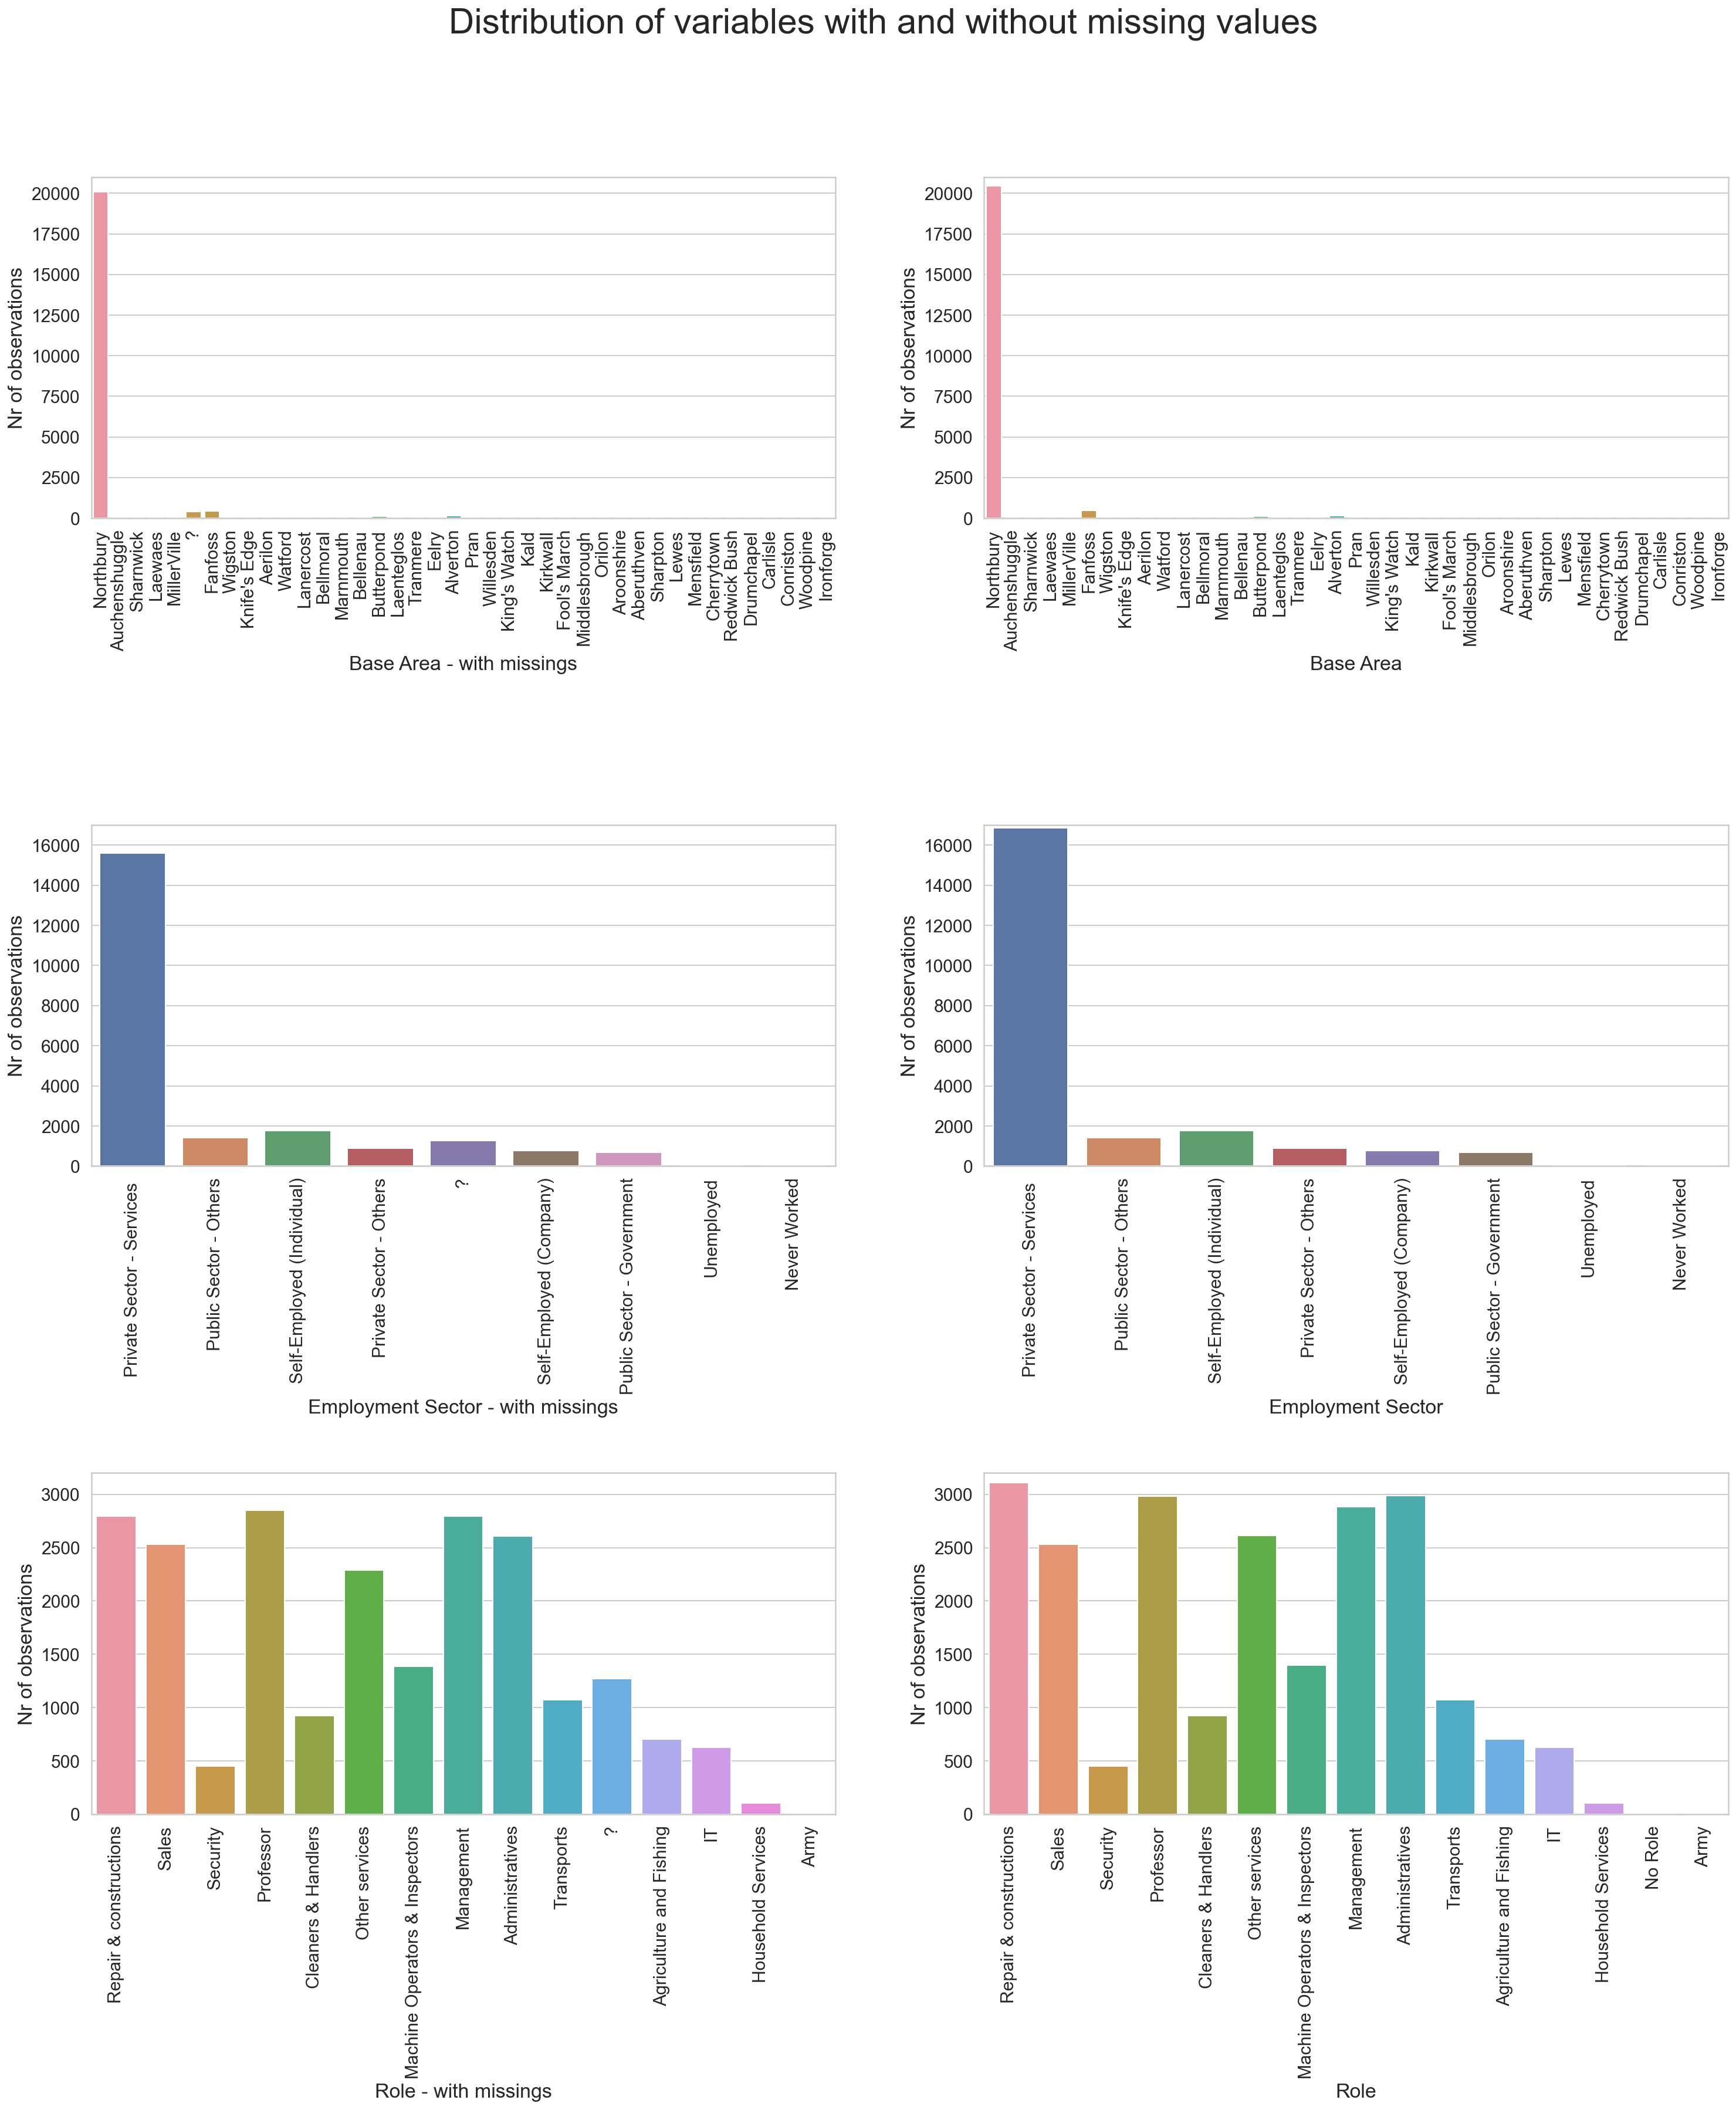

In [57]:
# Funciona
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25,25))


axa=sns.countplot(df_train2["Base Area"], ax=axes[0,1])
axb=sns.countplot(df_train2["Employment Sector"], ax=axes[1,1])
axc=sns.countplot(df_train2["Role"], ax=axes[2,1])

ax4=sns.countplot(non_metric["Base Area"], ax=axes[0,0])
ax5=sns.countplot(non_metric["Employment Sector"], ax=axes[1,0])
ax7=sns.countplot(non_metric["Role"], ax=axes[2, 0])


axa.tick_params(labelsize=15)
axa.set_xticklabels(axa.get_xticklabels(), rotation=90)
axa.set_xlabel(xlabel='Base Area',fontsize = 17)
axa.set_ylabel(ylabel='Nr of observations',fontsize = 17)
axa.set(ylim=(0, 21000))

ax4.tick_params(labelsize=15)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
ax4.set_xlabel(xlabel='Base Area - with missings',fontsize = 17)
ax4.set_ylabel(ylabel='Nr of observations',fontsize = 17)
ax4.set(ylim=(0, 21000))

axb.tick_params(labelsize=15)
axb.set_xticklabels(axb.get_xticklabels(), rotation=90)
axb.set_xlabel(xlabel='Employment Sector',fontsize = 17)
axb.set_ylabel(ylabel='Nr of observations',fontsize = 17)
axb.set(ylim=(0, 17000))

ax5.tick_params(labelsize=15)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)
ax5.set_xlabel(xlabel='Employment Sector - with missings',fontsize = 17)
ax5.set_ylabel(ylabel='Nr of observations',fontsize = 17)
ax5.set(ylim=(0, 17000))

axc.tick_params(labelsize=15)
axc.set_xticklabels(axc.get_xticklabels(), rotation=90)
axc.set_xlabel(xlabel='Role',fontsize = 17)
axc.set_ylabel(ylabel='Nr of observations',fontsize = 17)
axc.set(ylim=(0, 3200))

ax7.tick_params(labelsize=15)
ax7.set_xticklabels(ax7.get_xticklabels(), rotation=90)
ax7.set_xlabel(xlabel='Role - with missings',fontsize = 17)
ax7.set_ylabel(ylabel='Nr of observations',fontsize = 17)
ax7.set(ylim=(0, 3200))

plt.subplots_adjust(top=0.9,hspace=0.9)
plt.suptitle("Distribution of variables with and without missing values", fontsize=30)

## Feature Engineering

In [58]:
#EXPLICARRR

# New variable for Age
df_train2["Age"]=df_train2.Birthday.map(lambda x: datetime.now().year+28-x.year)

In [59]:
df_train2[["Birthday","Age"]]

Birthday  Age
CITIZEN_ID                
12486      2003-07-01   45
12487      2006-01-25   42
12488      2009-05-10   39
12489      1985-03-25   63
12490      2015-05-29   33
...               ...  ...
34881      2023-03-15   25
34882      2025-03-07   23
34883      2022-07-20   26
34884      2011-06-11   37
34885      2026-10-02   22

[22400 rows x 2 columns]

In [60]:
# New variable for Gender - binary if it's a male or not
df_train2['Male'] = np.where(df_train2.Name.str.contains('Mrs|Miss'), '0', '1')

In [61]:
# Check the values for variable Marital Status
df_train2["Marital Status"].unique()

array(['Married', 'Single', 'Married - Spouse Missing', 'Divorced',
       'Separated', 'Widow', 'Married - Spouse in the Army'], dtype=object)

In [62]:
#In column Marital Status, join "Married" with 'Married - Spouse Missing' and 'Married - Spouse in the Army' since we do not consider this distintion relevant
df_train2["Marital Status_new"]=df_train2["Marital Status"]
df_train2["Marital Status_new"][(df_train2["Marital Status"].str.contains("Married")==True) & (df_train2["Marital Status"]!="Married")]="Married"

#In column Marital Status, join "Divorced" with 'Separated' in "Divorced or Separated"
df_train2["Marital Status_new"][(df_train2["Marital Status"]=="Separated") | (df_train2["Marital Status"]=="Divorced")]="Divorced or Separated"

df_train2["Marital Status_new"][(df_train2["Marital Status"]=="Married")]

<ipython-input-62-d3808c6b0aad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Marital Status_new"][(df_train2["Marital Status"].str.contains("Married")==True) & (df_train2["Marital Status"]!="Married")]="Married"
<ipython-input-62-d3808c6b0aad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Marital Status_new"][(df_train2["Marital Status"]=="Separated") | (df_train2["Marital Status"]=="Divorced")]="Divorced or Separated"


CITIZEN_ID
12486    Married
12487    Married
12488    Married
12489    Married
12492    Married
          ...   
34876    Married
34877    Married
34878    Married
34879    Married
34880    Married
Name: Marital Status_new, Length: 10219, dtype: object

In [63]:
# New binary variable to determine whether the person is married
df_train2["Is Married"]='0'
df_train2["Is Married"][(df_train2["Marital Status_new"]=="Married")]='1'

<ipython-input-63-f3da02dbb23c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Is Married"][(df_train2["Marital Status_new"]=="Married")]='1'


In [64]:
df_train2["Marital Status_new"].unique()

array(['Married', 'Single', 'Divorced or Separated', 'Widow'],
      dtype=object)

In [65]:
df_train2["Is Married"]

CITIZEN_ID
12486    1
12487    1
12488    1
12489    1
12490    0
        ..
34881    0
34882    0
34883    0
34884    0
34885    0
Name: Is Married, Length: 22400, dtype: object

In [66]:
# Check the values for variable Education Level
df_train2["Education Level"].unique()

array(['High School + PostGraduation', 'Professional School',
       'High School - 2nd Cycle', 'PhD', 'Bachelors',
       'Bachelors + PostGraduation', 'Masters', 'High School - 1st Cycle',
       'High School Complete', 'Masters + PostGraduation',
       'Professional School + PostGraduation',
       'Middle School - 2nd Cycle', 'Middle School Complete',
       'Middle School - 1st Cycle', 'Primary School',
       'No Relevant Education'], dtype=object)

In [67]:
#In column Education Level, join all equal periods of education level

df_train2["Education Level_new"]=df_train2["Education Level"]

df_train2["Education Level_new"][(df_train2["Education Level"]=="Middle School - 1st Cycle") |
                    (df_train2["Education Level"]=="Middle School - 2nd Cycle")|
                    (df_train2["Education Level"]=="Middle School Complete")]="Middle School"

df_train2["Education Level_new"][(df_train2["Education Level"]=="High School - 1st Cycle") | 
                    (df_train2["Education Level"]=="High School - 2nd Cycle") | 
                    (df_train2["Education Level"]=="High School Complete")]="High School"

<ipython-input-67-949cf134105c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Education Level_new"][(df_train2["Education Level"]=="Middle School - 1st Cycle") |
<ipython-input-67-949cf134105c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Education Level_new"][(df_train2["Education Level"]=="High School - 1st Cycle") |


In [68]:
df_train2["Education Level_new"].unique()

array(['High School + PostGraduation', 'Professional School',
       'High School', 'PhD', 'Bachelors', 'Bachelors + PostGraduation',
       'Masters', 'Masters + PostGraduation',
       'Professional School + PostGraduation', 'Middle School',
       'Primary School', 'No Relevant Education'], dtype=object)

In [69]:
df_train2["Years of Education"][df_train2["Education Level_new"]=='Professional School'].unique()

array([12], dtype=int64)

In [70]:
df_train2["Years of Education"][df_train2["Education Level_new"]=='High School']

CITIZEN_ID
12489    11
12493    11
12505    10
12512    12
12524    11
         ..
34847    11
34856    10
34857    12
34858    10
34865    11
Name: Years of Education, Length: 1745, dtype: int64

In [71]:
#Join all without considering Post Graduation

df_train2["Education Level_new2"]=df_train2["Education Level_new"].copy()
df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="High School + PostGraduation")]="High School"
df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="Bachelors + PostGraduation")]="Bachelors"
df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="Professional School + PostGraduation")]="Professional School"
df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="Masters + PostGraduation")]="Masters"
df_train2[["Education Level_new", "Education Level_new2"]]

<ipython-input-71-4d90ae3416be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="High School + PostGraduation")]="High School"
<ipython-input-71-4d90ae3416be>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2["Education Level_new2"][(df_train2["Education Level_new2"]=="Bachelors + PostGraduation")]="Bachelors"
<ipython-input-71-4d90ae3416be>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

Education Level_new Education Level_new2
CITIZEN_ID                                                   
12486       High School + PostGraduation          High School
12487                Professional School  Professional School
12488                Professional School  Professional School
12489                        High School          High School
12490                                PhD                  PhD
...                                  ...                  ...
34881                Professional School  Professional School
34882                Professional School  Professional School
34883                            Masters              Masters
34884         Bachelors + PostGraduation            Bachelors
34885       High School + PostGraduation          High School

[22400 rows x 2 columns]

In [72]:
#Binary that says if the citizen has Post Graduation or not

df_train2["PostGraduation"]=df_train2["Education Level_new"].map(lambda x: '1' if "+" in x else '0')
df_train2["PostGraduation"]

CITIZEN_ID
12486    1
12487    0
12488    0
12489    0
12490    0
        ..
34881    0
34882    0
34883    0
34884    1
34885    1
Name: PostGraduation, Length: 22400, dtype: object

In [73]:
# New binary variable related to Higher Education
# (includes at least one of the following: Post Graduation, Bachelors, Masters, PhD)

df_train2['Higher Education']=np.where(df_train2['Years of Education']>12, '1', '0')

In [74]:
# New binary variable that tells us if each person lives in the capital city or not
df_train2['Capital']= np.where(df_train2['Base Area']=='Northbury', '1', '0')

In [75]:
# New binary variable to determine whether the person belongs to Group B (people who were payed to participate in the mission)
df_train2['Group B']=np.where(df_train2['Money Received']!=0, '1', '0')

In [76]:
# New binary variable to determine whether the person belongs to Group C (people who payed to participate in the mission)
df_train2['Group C']=np.where(df_train2['Ticket Price']!=0, '1', '0')

In [77]:
df_train2.head()

Name   Birthday Native Continent Marital Status  \
CITIZEN_ID                                                                    
12486            Mr. Adam Glover 2003-07-01           Europe        Married   
12487       Mr. Cameron McDonald 2006-01-25           Europe        Married   
12488         Mr. Keith Davidson 2009-05-10           Europe        Married   
12489         Mr. Alexander Gill 1985-03-25           Europe        Married   
12490             Mr. Neil Piper 2015-05-29           Europe         Single   

              Lives with  Base Area               Education Level  \
CITIZEN_ID                                                          
12486               Wife  Northbury  High School + PostGraduation   
12487               Wife  Northbury           Professional School   
12488               Wife  Northbury           Professional School   
12489               Wife  Northbury       High School - 2nd Cycle   
12490       Other Family  Northbury                           PhD   

            Years of Education           Employment Sector  \
CITIZEN_ID                                                   
12486                       13  Private Sector - Services    
12487                       12      Public Sector - Others   
12488                       12  Private Sector - Services    
12489                       11  Private Sector - Services    
12490                       21  Self-Employed (Individual)   

                              Role  ...  Male  Marital Status_new  Is Married  \
CITIZEN_ID                          ...                                         
12486       Repair & constructions  ...     1             Married           1   
12487       Repair & constructions  ...     1             Married           1   
12488                        Sales  ...     1             Married           1   
12489                     Security  ...     1             Married           1   
12490                    Professor  ...     1              Single           0   

                     Education Level_new Education Level_new2 PostGraduation  \
CITIZEN_ID                                                                     
12486       High School + PostGraduation          High School              1   
12487                Professional School  Professional School              0   
12488                Professional School  Professional School              0   
12489                        High School          High School              0   
12490                                PhD                  PhD              0   

           Higher Education Capital Group B Group C  
CITIZEN_ID                                           
12486                     1       1       0       1  
12487                     0       1       0       0  
12488                     0       1       0       1  
12489                     0       1       1       0  
12490                     1       1       0       0  

[5 rows x 24 columns]

In [78]:
# publico ou privado ou self ou uneployed empl. sector
def sectors(a):
    if 'Private Sector' in a:
        return 'Private Sector'
    elif 'Public Sector' in a:
        return 'Public Sector'
    #we don't join the Self-Employeds bc the 'Company' ones have much more 1s on the target than the 'Individual'
    elif 'Self-Employed (Individual)' in a:
        return a
    elif 'Self-Employed (Company)' in a:
        return a
    else:
        return 'Unemployed / Never Worked'
    
df_train2['Employment Sector (simplified)'] = df_train2['Employment Sector'].map(sectors)

In [79]:
# binaria governo ou n empl. sector
df_train2['Government'] = df_train2['Employment Sector'].map(lambda x: '1' if 'Government' in x else '0')

In [80]:
df_train2.columns

Index(['Name', 'Birthday', 'Native Continent', 'Marital Status', 'Lives with',
       'Base Area', 'Education Level', 'Years of Education',
       'Employment Sector', 'Role', 'Working Hours per week', 'Money Received',
       'Ticket Price', 'Age', 'Male', 'Marital Status_new', 'Is Married',
       'Education Level_new', 'Education Level_new2', 'PostGraduation',
       'Higher Education', 'Capital', 'Group B', 'Group C',
       'Employment Sector (simplified)', 'Government'],
      dtype='object')

In [81]:
x = df_train2[["Ticket Price", "Money Received"]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df= pd.DataFrame(x_scaled)

In [82]:
# sns.histplot(df[0][df[0]!=0]) why???

In [83]:
# sns.histplot(df[1][df[1]!=0]) why???

In [84]:
Median_Money_Received=df_train2["Money Received"][df_train2["Money Received"]>0].median()
Median_Ticket_Price=df_train2["Ticket Price"][df_train2["Ticket Price"]>0].median()

df_train2['Money Relevance']='0'
df_train2['Money Relevance'][df_train2["Money Received"]> Median_Money_Received] ='1'
df_train2['Money Relevance'][(df_train2["Money Received"]<= Median_Money_Received) & (df_train2["Money Received"]>0)]='2'

df_train2['Money Relevance'][df_train2["Ticket Price"]> Median_Ticket_Price] ='5'
df_train2['Money Relevance'][(df_train2["Ticket Price"]<= Median_Ticket_Price) & (df_train2["Ticket Price"]>0)] ='4'

df_train2['Money Relevance'][(df_train2["Ticket Price"]== 0) & (df_train2["Money Received"]==0)] ='3'

<ipython-input-84-10f994c97333>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2['Money Relevance'][df_train2["Money Received"]> Median_Money_Received] ='1'
<ipython-input-84-10f994c97333>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2['Money Relevance'][(df_train2["Money Received"]<= Median_Money_Received) & (df_train2["Money Received"]>0)]='2'
<ipython-input-84-10f994c97333>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [85]:
df_train2[["Ticket Price", "Money Received", "Money Relevance"]]

Ticket Price  Money Received Money Relevance
CITIZEN_ID                                              
12486               2273               0               4
12487                  0               0               3
12488               2321               0               4
12489                  0            5395               2
12490                  0               0               3
...                  ...             ...             ...
34881                  0               0               3
34882                  0               0               3
34883                  0            2674               2
34884                  0               0               3
34885                  0               0               3

[22400 rows x 3 columns]

In [86]:
#df_train2.drop(columns=["Ticket Price", "Money Received"]), inplace=True)

In [87]:
#interaction between these two: working more hours, has more impact on income with more year of education?
df_train2["Working hours * Years of Education"] = df_train["Working Hours per week"] * df_train["Years of Education"]

In [88]:
#Money received per year of education
df_train2['Money / YE']=0
df_train2['Money / YE'][df_train2["Years of Education"]!=0]=round(df_train["Money Received"] / df_train["Years of Education"], 2)

<ipython-input-88-72969f3df92f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2['Money / YE'][df_train2["Years of Education"]!=0]=round(df_train["Money Received"] / df_train["Years of Education"], 2)


In [89]:
import math
df_train2['Log 10 of Money Received']=df_train2['Money Received'].map(lambda x: math.log10(x) if x!=0 else 0)
df_train2['Log 10 of Ticket Price']=df_train2['Ticket Price'].map(lambda x: math.log10(x) if x!=0 else 0)

## Feature Selection

In [90]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22400 entries, 12486 to 34885
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Name                                22400 non-null  object        
 1   Birthday                            22400 non-null  datetime64[ns]
 2   Native Continent                    22400 non-null  object        
 3   Marital Status                      22400 non-null  object        
 4   Lives with                          22400 non-null  object        
 5   Base Area                           22400 non-null  object        
 6   Education Level                     22400 non-null  object        
 7   Years of Education                  22400 non-null  int64         
 8   Employment Sector                   22400 non-null  object        
 9   Role                                22400 non-null  object        
 10  Working Hours per 

In [91]:
metric= df_train2.loc[:,(np.array(df_train2.dtypes=="int64")) | (np.array(df_train2.dtypes=="float64"))]

In [92]:
#Standardize
x = metric.values #returns a numpy array

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
stand_metric= pd.DataFrame(x_scaled, columns=metric.columns, index=metric.index)

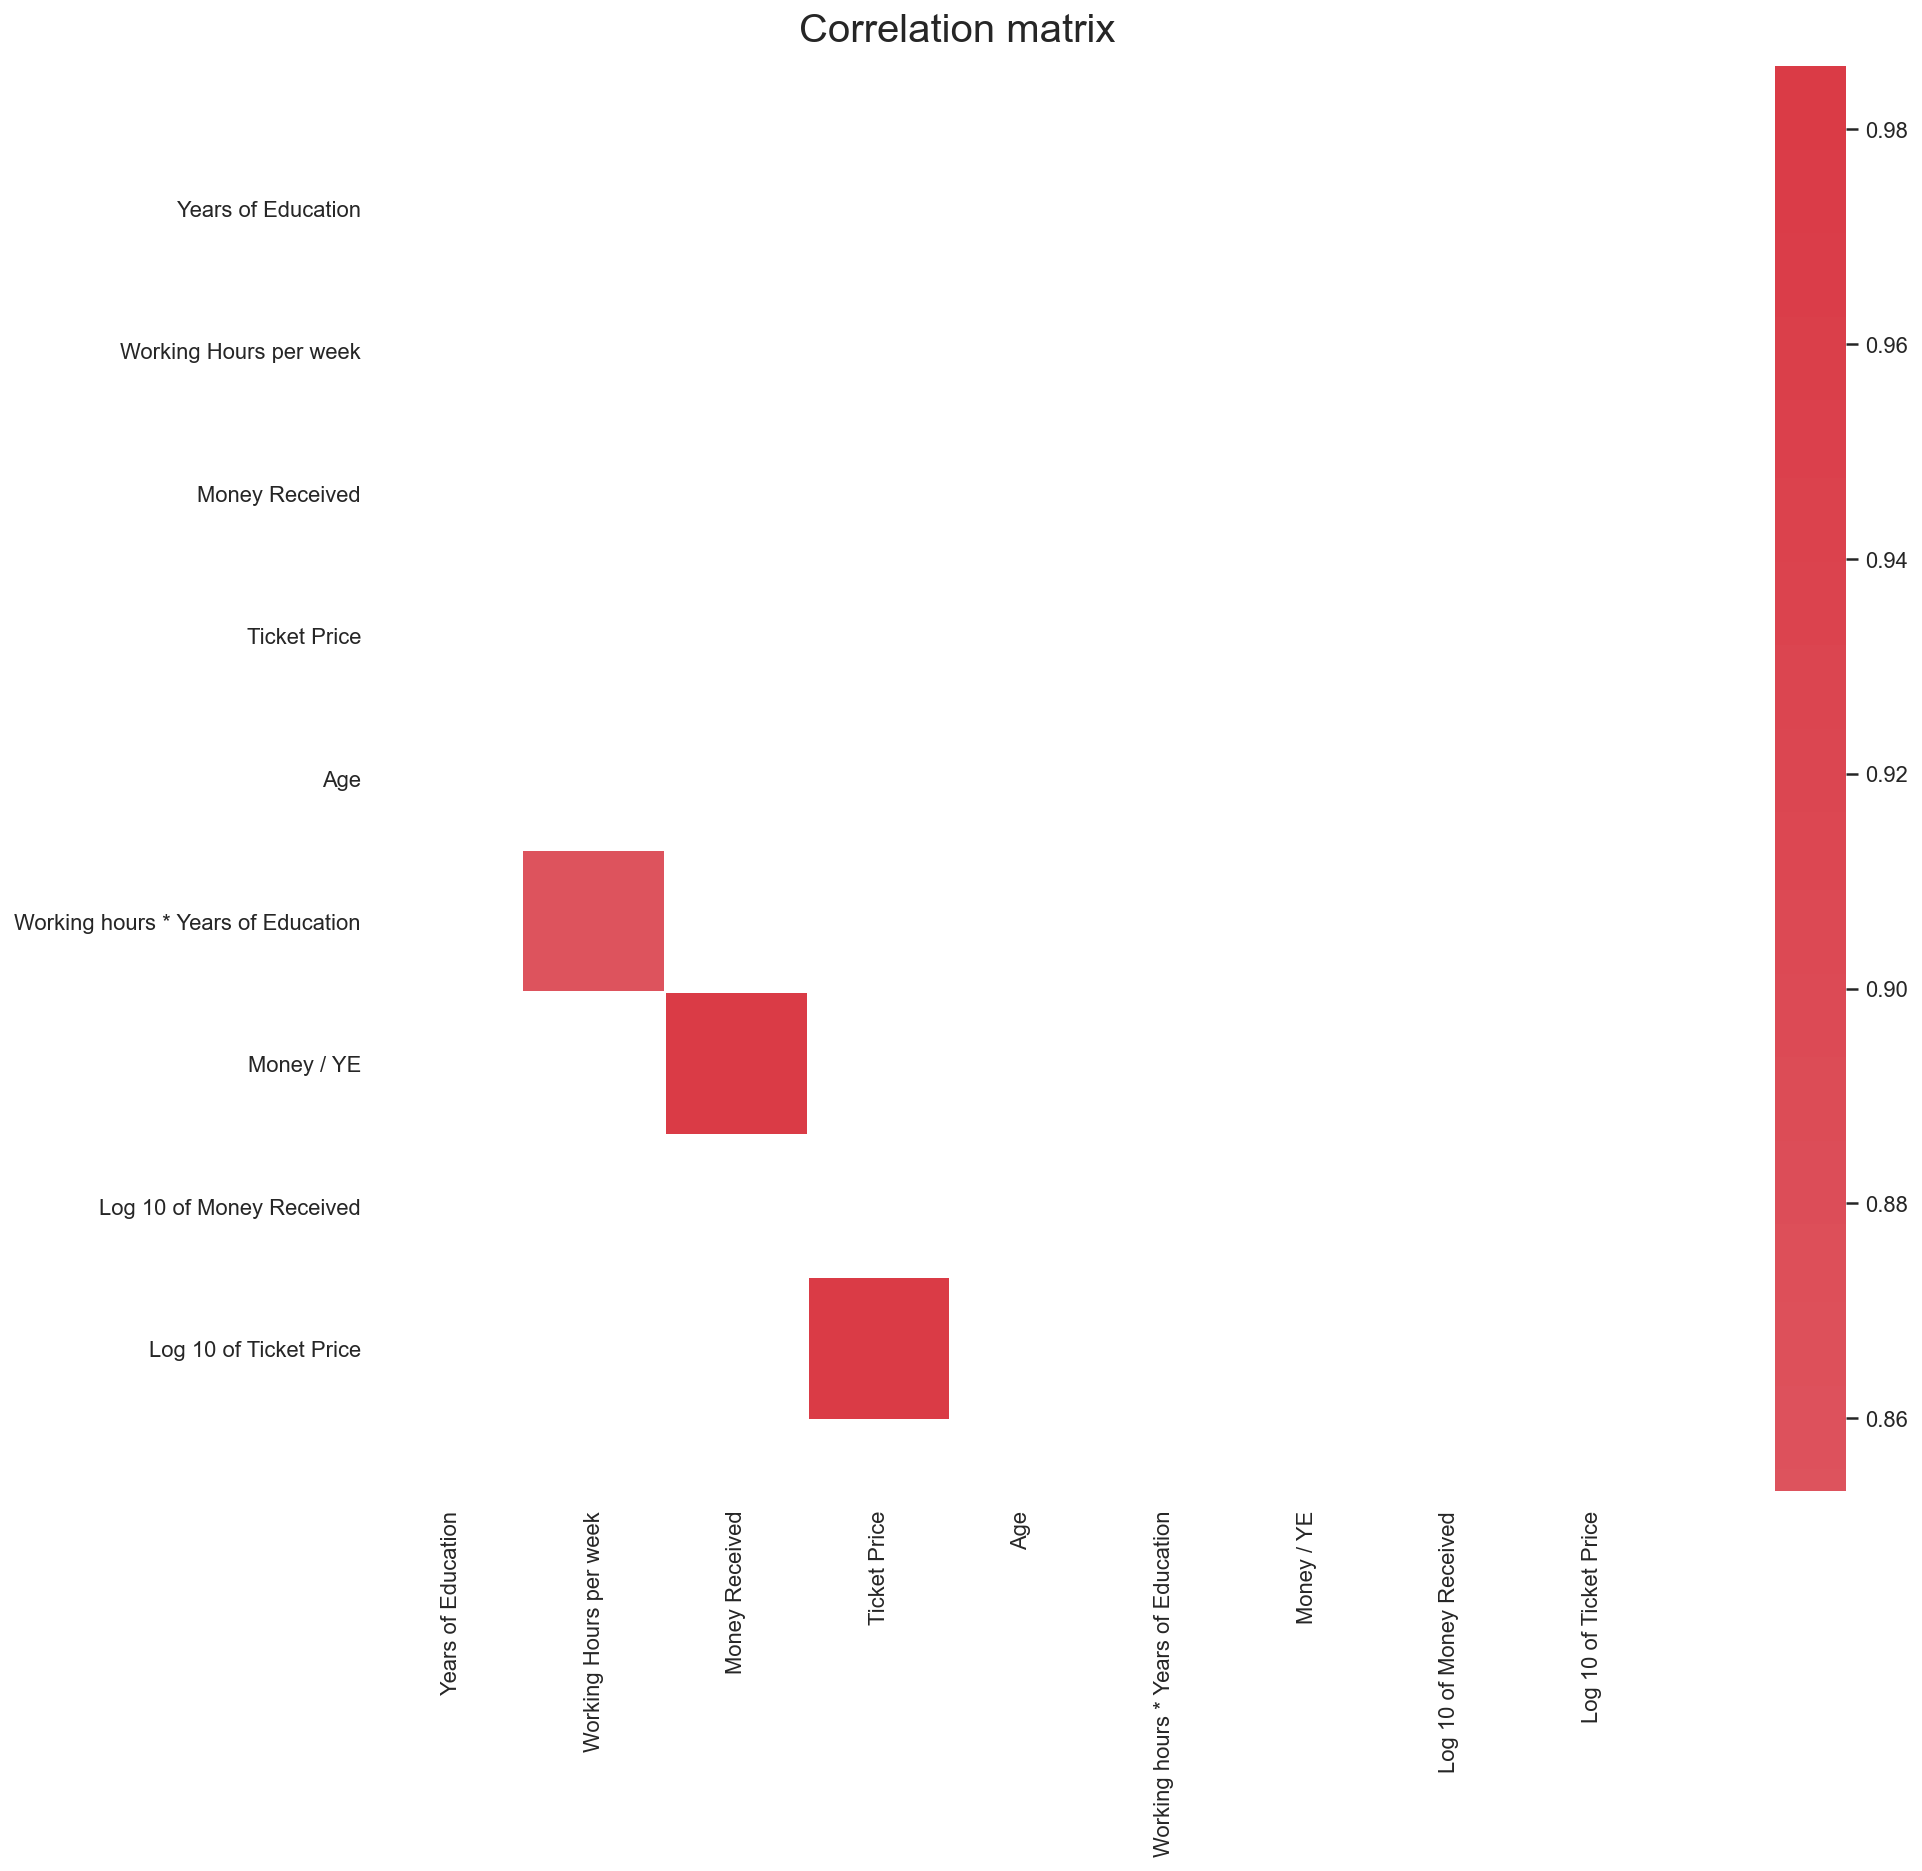

In [93]:
sns.set(style="white")

# Compute the correlation matrix
corr = stand_metric.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
#show only corr bigger than 0.6 in absolute value
sns.heatmap(corr[(corr>=.7) | (corr<=-.7)], mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
# Fixing the bug of partially cut-off bottom and top cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [94]:
#correlation between Money Received and Log 10 of Money Received
round(corr['Money Received']['Log 10 of Money Received'], 3)

0.561

In [95]:
warnings.filterwarnings('ignore')

#no of features
nof_list=np.arange(1,len(stand_metric.columns)+1)  
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    # we are going to see in the next class this "train_test_split()"...
    X_train, X_test, y_train, y_test = train_test_split(stand_metric,target, test_size = 0.3, random_state = 0)
    
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 7
Score with 7 features: 0.811607


In [96]:
rfe = RFE(estimator = model, n_features_to_select = 7)
X_rfe = rfe.fit_transform(X = stand_metric, y = target)
model = LogisticRegression().fit(X = X_rfe,y = target)
selected_features = pd.Series(rfe.support_, index = stand_metric.columns)
selected_features

Years of Education                     True
Working Hours per week                 True
Money Received                         True
Ticket Price                           True
Age                                    True
Working hours * Years of Education     True
Money / YE                             True
Log 10 of Money Received              False
Log 10 of Ticket Price                False
dtype: bool

Best alpha using built-in LassoCV: 0.000026
Best score using built-in LassoCV: 0.254031
Lasso picked 9 variables and eliminated the other 0 variables


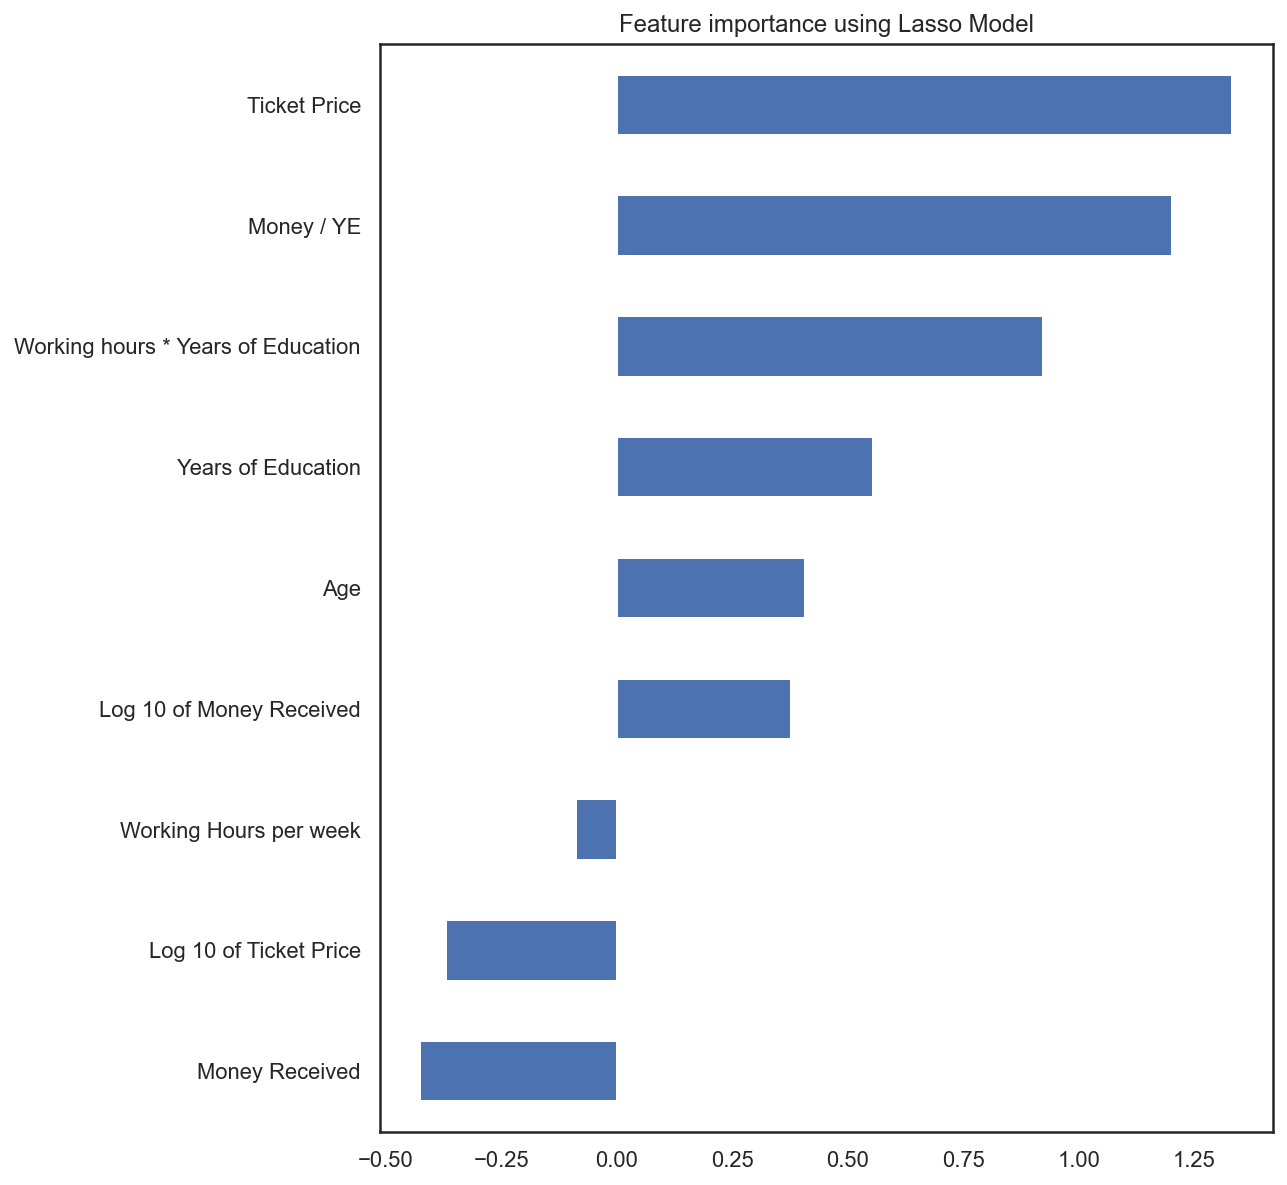

In [97]:
#Lasso
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
    
reg = LassoCV()

reg.fit(X=stand_metric, y=target)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X = stand_metric,y = target))
coef = pd.Series(reg.coef_, index = stand_metric.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
plot_importance(coef,'Lasso')

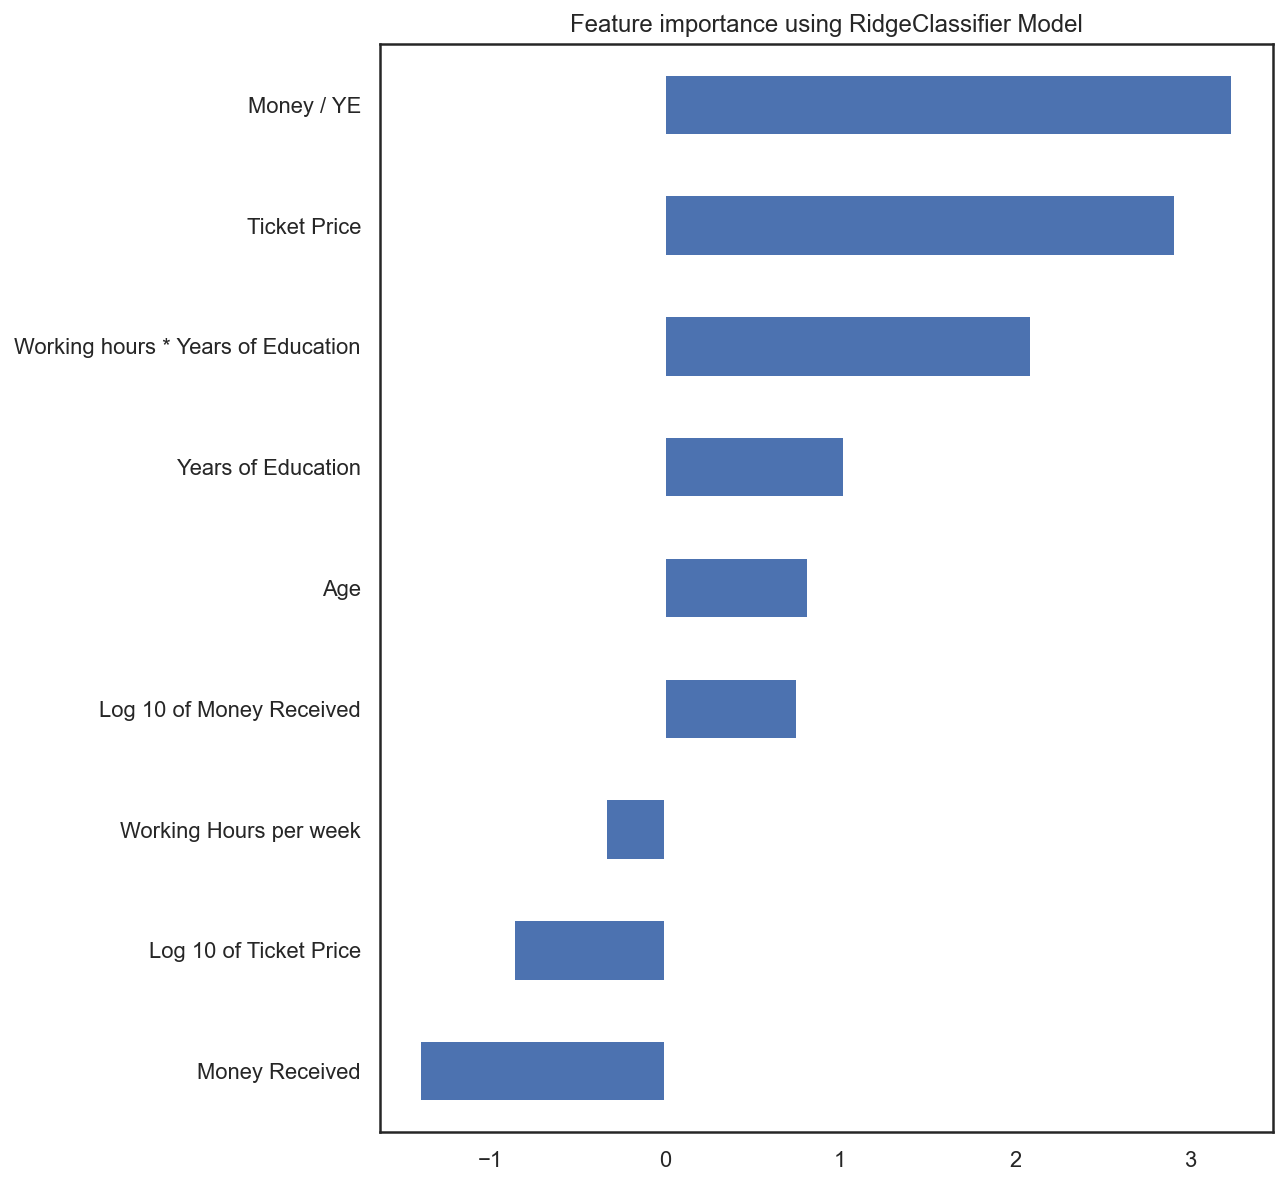

In [98]:
ridge = RidgeClassifierCV().fit(X = stand_metric,y = target)
coef_ridge = pd.Series(ridge.coef_[0], index = stand_metric.columns)

def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
    
plot_importance(coef_ridge,'RidgeClassifier')

### Forward, backward

In [99]:
#from sklearn import tree
#from sklearn.model_selection import KFold
#import sklearn

In [100]:
model = LogisticRegression()

In [101]:
forward = SFS(model, k_features=9, forward=True, scoring="accuracy", cv = None) #floating=False

forward.fit(stand_metric, target)

SequentialFeatureSelector(cv=None, estimator=LogisticRegression(), k_features=9,
                          scoring='accuracy')

In [102]:
forward_table = pd.DataFrame.from_dict(forward.get_metric_dict()).T.drop(columns=['cv_scores', 'ci_bound', 'std_dev', 'std_err'])
forward_table

feature_idx avg_score  \
1                         (2,)  0.803259   
2                       (2, 3)  0.816741   
3                    (2, 3, 8)  0.816696   
4                 (2, 3, 6, 8)  0.815312   
5              (2, 3, 6, 7, 8)  0.814063   
6           (0, 2, 3, 6, 7, 8)  0.810848   
7        (0, 2, 3, 5, 6, 7, 8)  0.811786   
8     (0, 2, 3, 4, 5, 6, 7, 8)  0.814688   
9  (0, 1, 2, 3, 4, 5, 6, 7, 8)  0.813616   

                                       feature_names  
1                                  (Money Received,)  
2                     (Money Received, Ticket Price)  
3  (Money Received, Ticket Price, Log 10 of Ticke...  
4  (Money Received, Ticket Price, Money / YE, Log...  
5  (Money Received, Ticket Price, Money / YE, Log...  
6  (Years of Education, Money Received, Ticket Pr...  
7  (Years of Education, Money Received, Ticket Pr...  
8  (Years of Education, Money Received, Ticket Pr...  
9  (Years of Education, Working Hours per week, M...

In [103]:
forward_table_max = forward_table['avg_score'].max()
forward_table_max

0.8167410714285714

In [104]:
forward_table[forward_table['avg_score']==forward_table_max]['feature_names'].values

array([('Money Received', 'Ticket Price')], dtype=object)

In [105]:
backward = SFS(model, k_features=1, forward=False, scoring="accuracy", cv = None) #floating=False

backward.fit(stand_metric, target)

SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          forward=False, scoring='accuracy')

In [106]:
backward_table = pd.DataFrame.from_dict(backward.get_metric_dict()).T.drop(columns=['cv_scores', 'ci_bound', 'std_dev', 'std_err'])
backward_table

feature_idx avg_score  \
9  (0, 1, 2, 3, 4, 5, 6, 7, 8)  0.813616   
8     (0, 1, 2, 3, 4, 5, 6, 8)  0.815134   
7        (0, 2, 3, 4, 5, 6, 8)  0.816116   
6           (0, 2, 3, 4, 5, 6)  0.816161   
5              (0, 2, 3, 4, 5)  0.814107   
4                 (0, 2, 4, 5)  0.808438   
3                    (0, 2, 5)  0.804241   
2                       (0, 2)  0.801741   
1                         (2,)  0.803259   

                                       feature_names  
9  (Years of Education, Working Hours per week, M...  
8  (Years of Education, Working Hours per week, M...  
7  (Years of Education, Money Received, Ticket Pr...  
6  (Years of Education, Money Received, Ticket Pr...  
5  (Years of Education, Money Received, Ticket Pr...  
4  (Years of Education, Money Received, Age, Work...  
3  (Years of Education, Money Received, Working h...  
2               (Years of Education, Money Received)  
1                                  (Money Received,)

In [107]:
backward_table_max = backward_table['avg_score'].max()
backward_table_max

0.8161607142857142

In [108]:
backward_table[backward_table['avg_score']==backward_table_max]['feature_names'].values

array([('Years of Education', 'Money Received', 'Ticket Price', 'Age', 'Working hours * Years of Education', 'Money / YE')],
      dtype=object)

In [109]:
#not useful vars
initial_categorical_vars = df_train2.loc[:, np.array(df_train2.dtypes=="object")]
initial_categorical_vars.drop(columns='Name', inplace=True)
initial_categorical_vars.head()

Native Continent Marital Status    Lives with  Base Area  \
CITIZEN_ID                                                            
12486                Europe        Married          Wife  Northbury   
12487                Europe        Married          Wife  Northbury   
12488                Europe        Married          Wife  Northbury   
12489                Europe        Married          Wife  Northbury   
12490                Europe         Single  Other Family  Northbury   

                         Education Level           Employment Sector  \
CITIZEN_ID                                                             
12486       High School + PostGraduation  Private Sector - Services    
12487                Professional School      Public Sector - Others   
12488                Professional School  Private Sector - Services    
12489            High School - 2nd Cycle  Private Sector - Services    
12490                                PhD  Self-Employed (Individual)   

                              Role Male Marital Status_new Is Married  \
CITIZEN_ID                                                              
12486       Repair & constructions    1            Married          1   
12487       Repair & constructions    1            Married          1   
12488                        Sales    1            Married          1   
12489                     Security    1            Married          1   
12490                    Professor    1             Single          0   

                     Education Level_new Education Level_new2 PostGraduation  \
CITIZEN_ID                                                                     
12486       High School + PostGraduation          High School              1   
12487                Professional School  Professional School              0   
12488                Professional School  Professional School              0   
12489                        High School          High School              0   
12490                                PhD                  PhD              0   

           Higher Education Capital Group B Group C  \
CITIZEN_ID                                            
12486                     1       1       0       1   
12487                     0       1       0       0   
12488                     0       1       0       1   
12489                     0       1       1       0   
12490                     1       1       0       0   

           Employment Sector (simplified) Government Money Relevance  
CITIZEN_ID                                                            
12486                      Private Sector          0               4  
12487                       Public Sector          0               3  
12488                      Private Sector          0               4  
12489                      Private Sector          0               2  
12490          Self-Employed (Individual)          0               3

In [110]:
def bar_charts_categorical(df, feature, dep_var):
    cont_tab = pd.crosstab(df[feature], dep_var, margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")
    #mantemos assim com os 90 graus? ou doutra forma?
    plt.xticks(rotation=90)

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    #de novo, mantemos assim com os 90 graus? ou doutra forma?
    plt.xticks(rotation=90)

    plt.show()

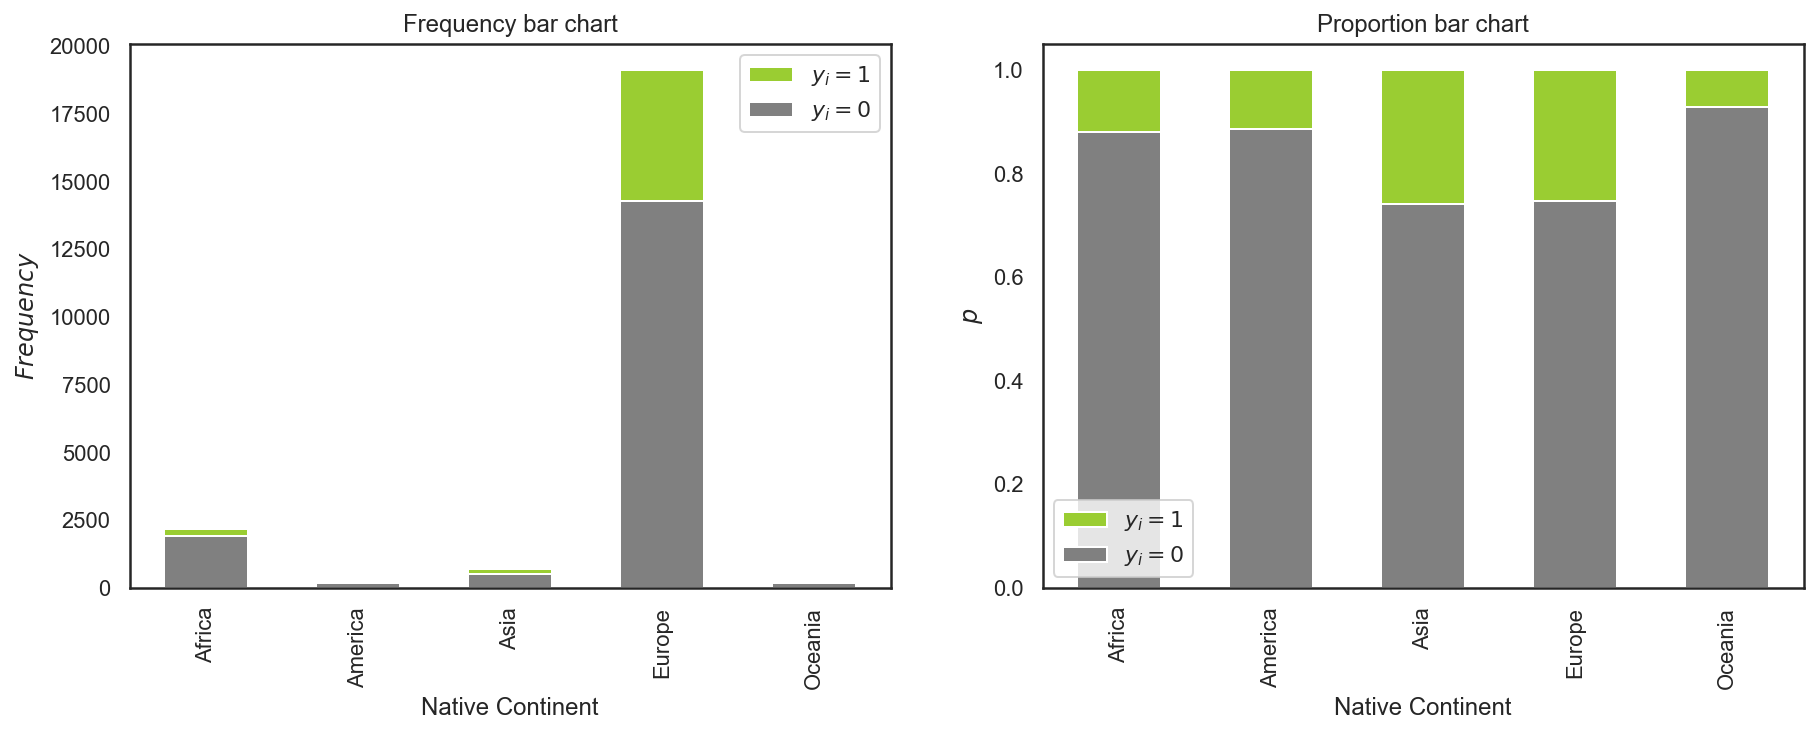

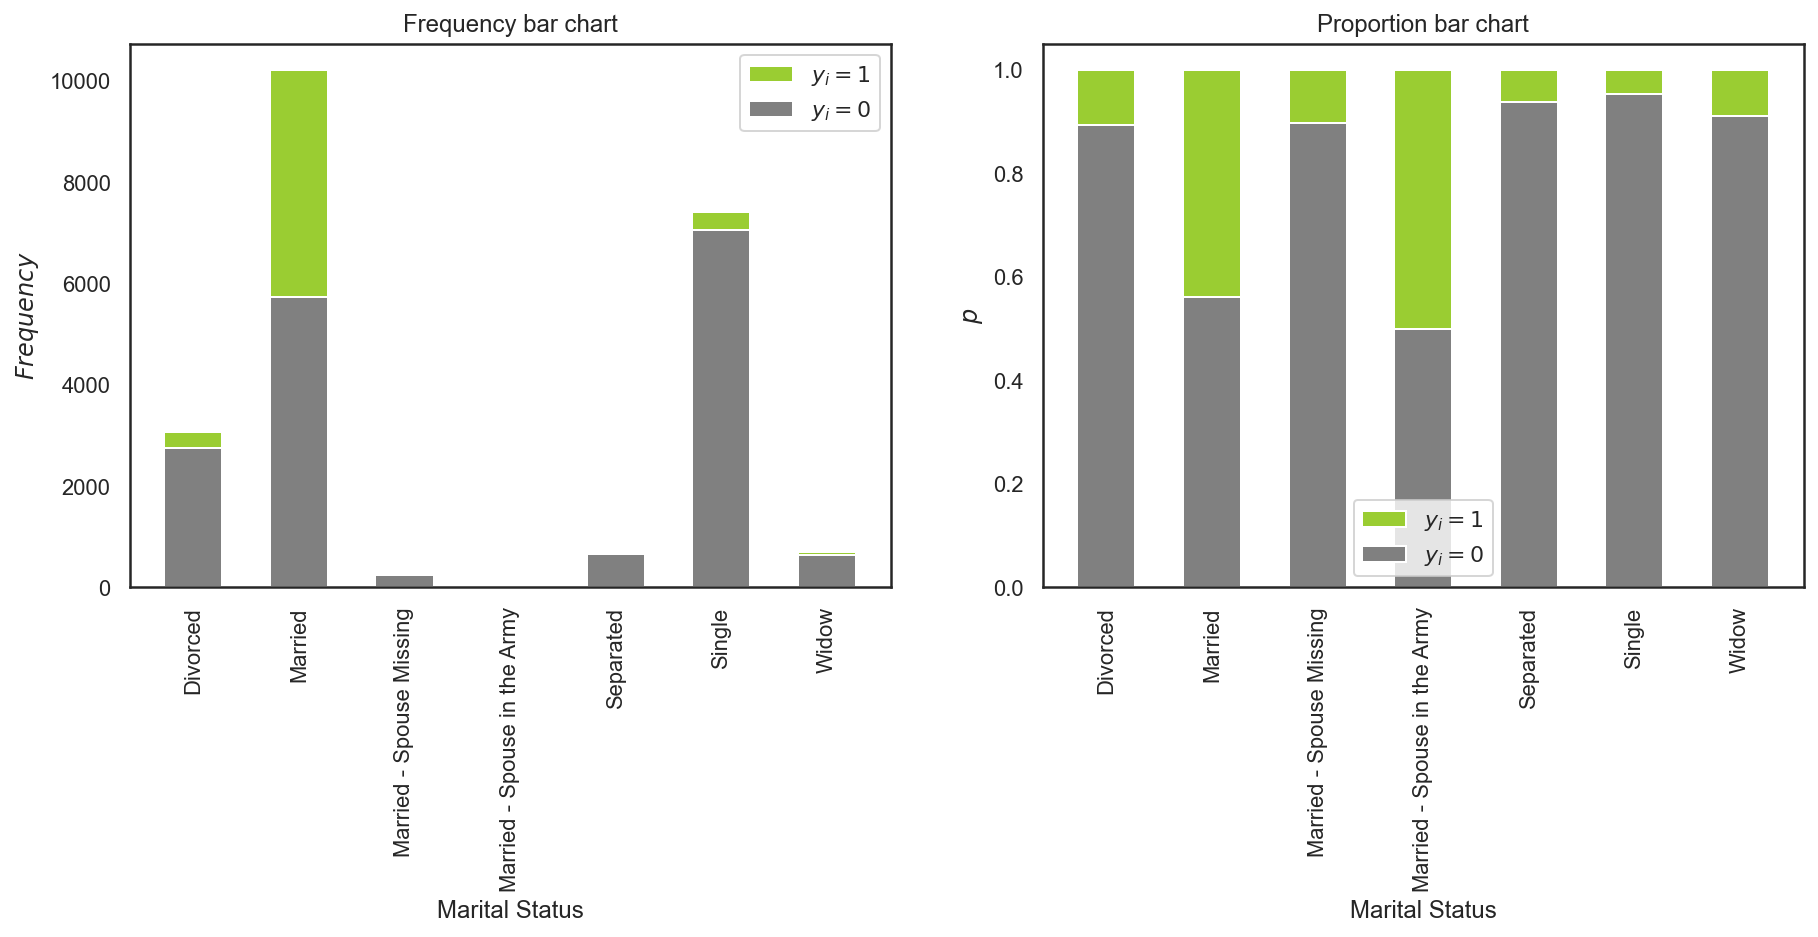

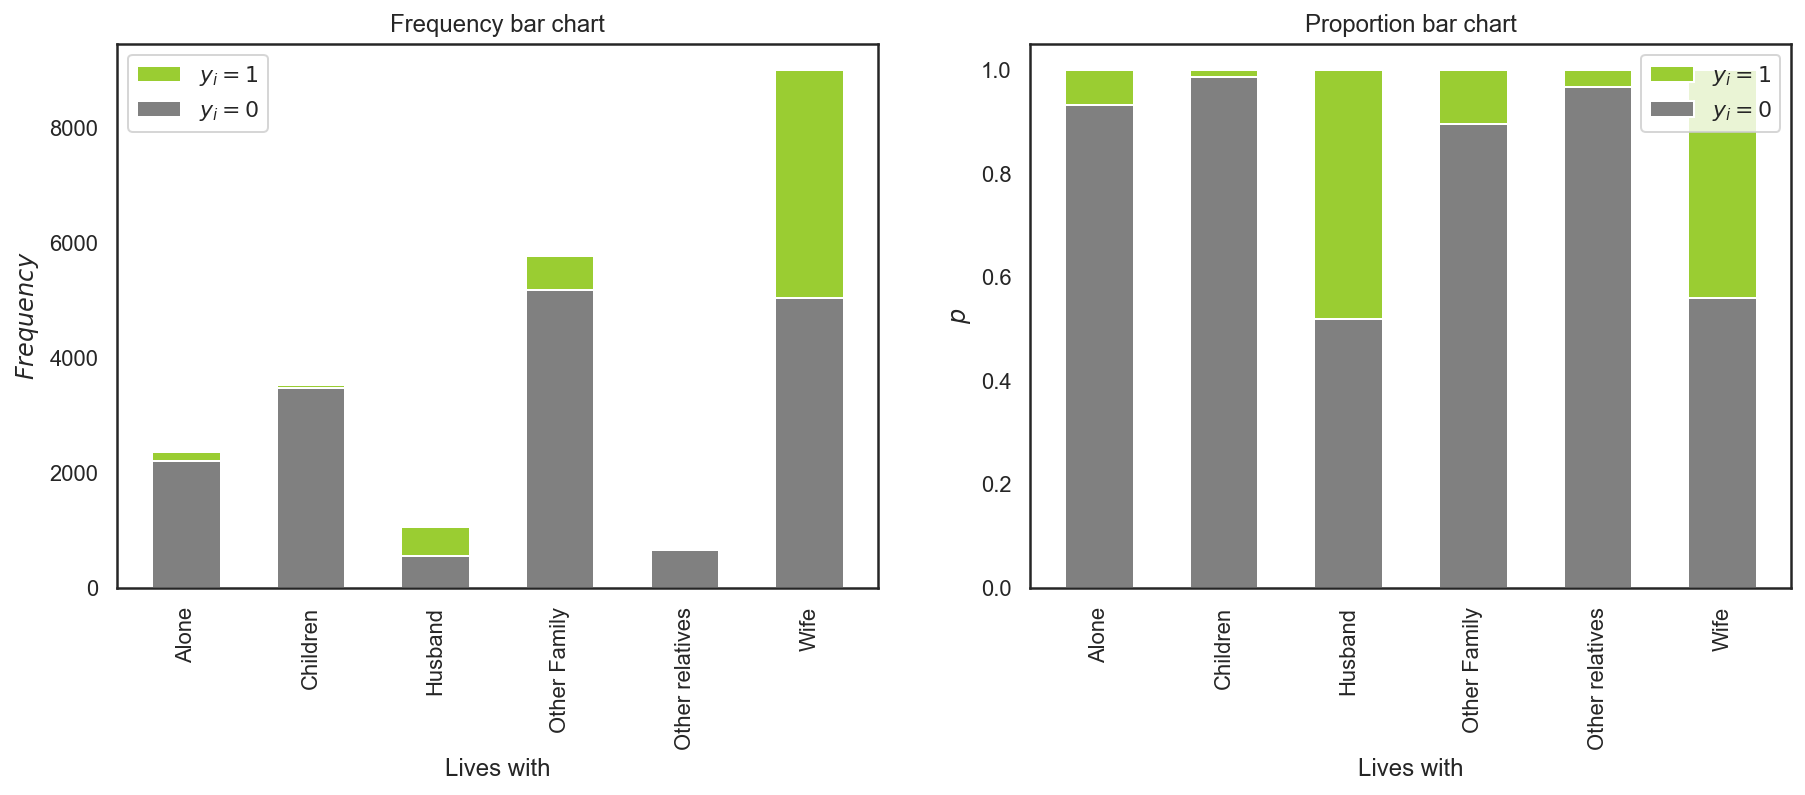

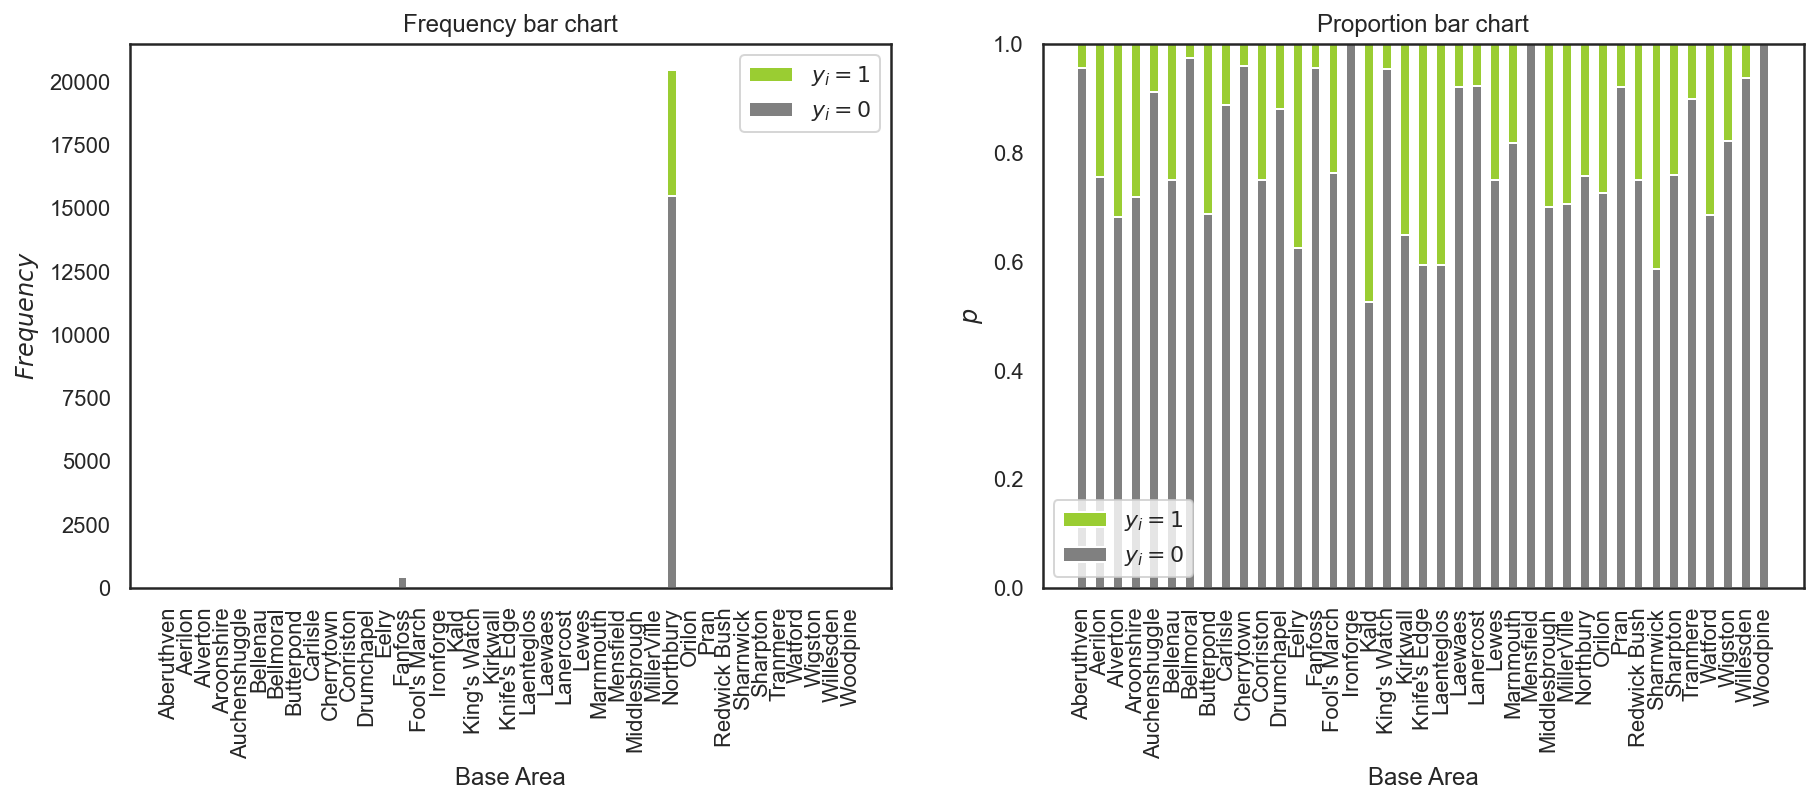

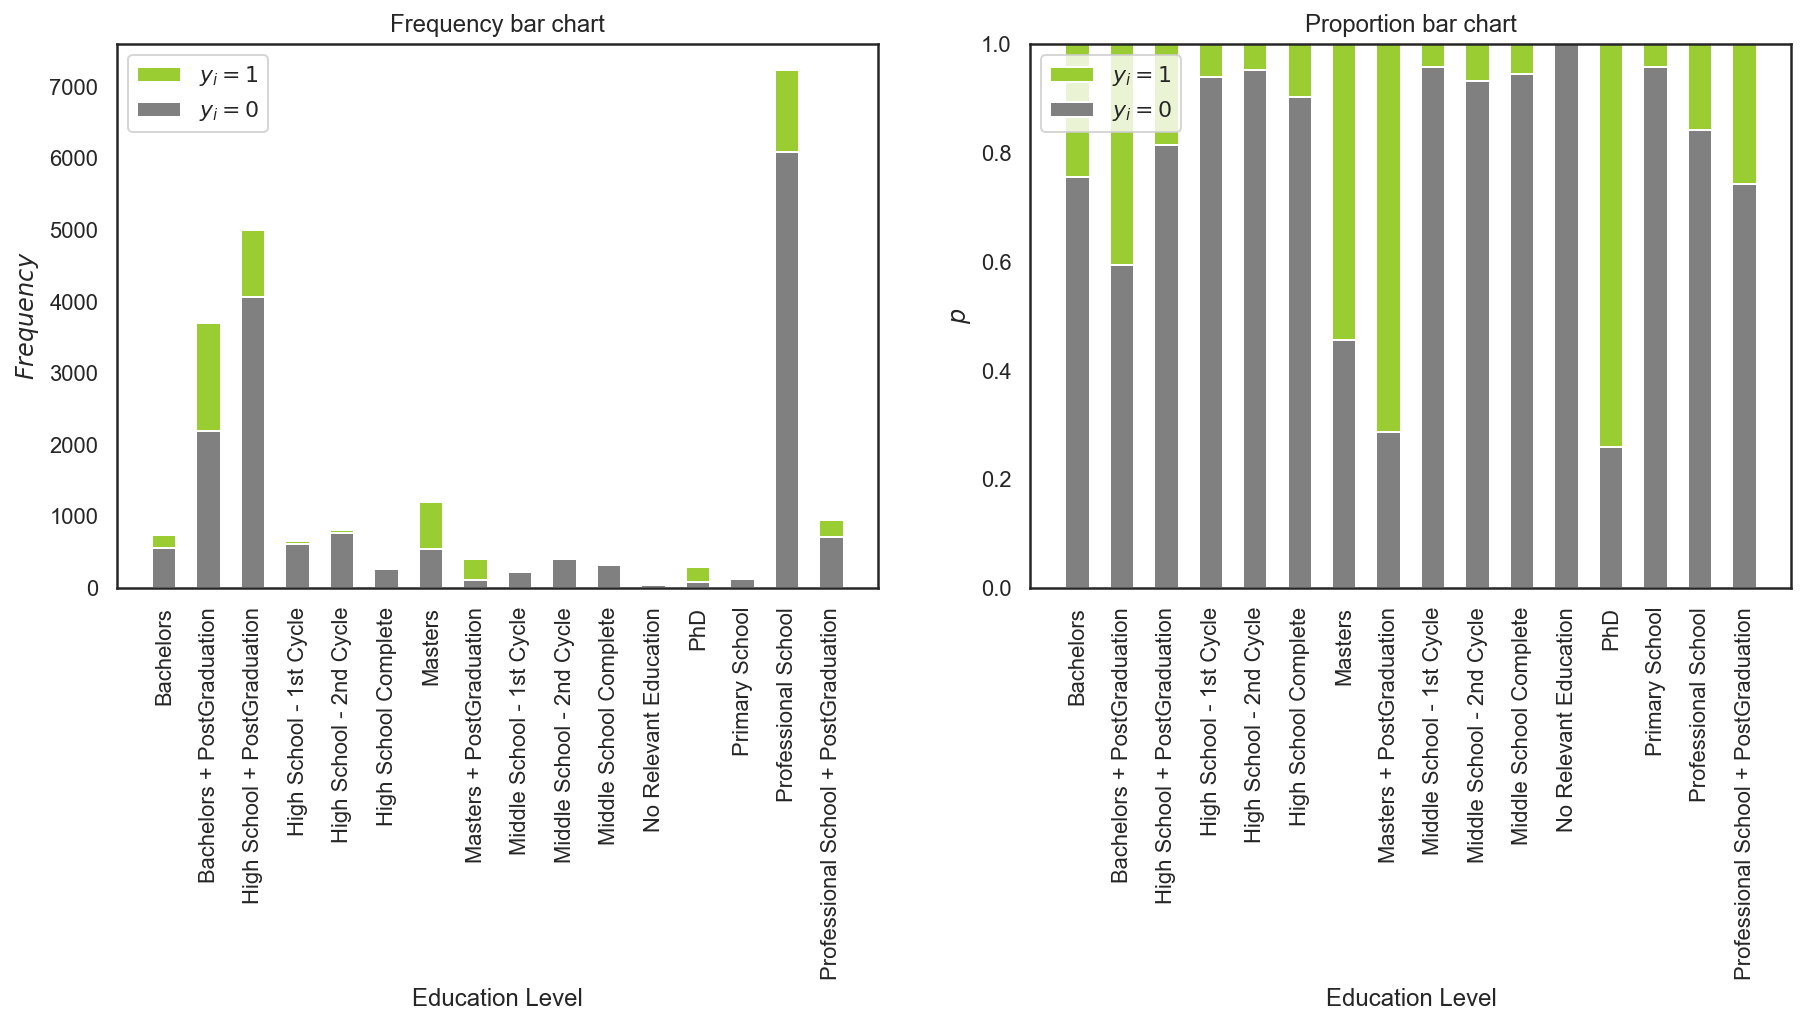

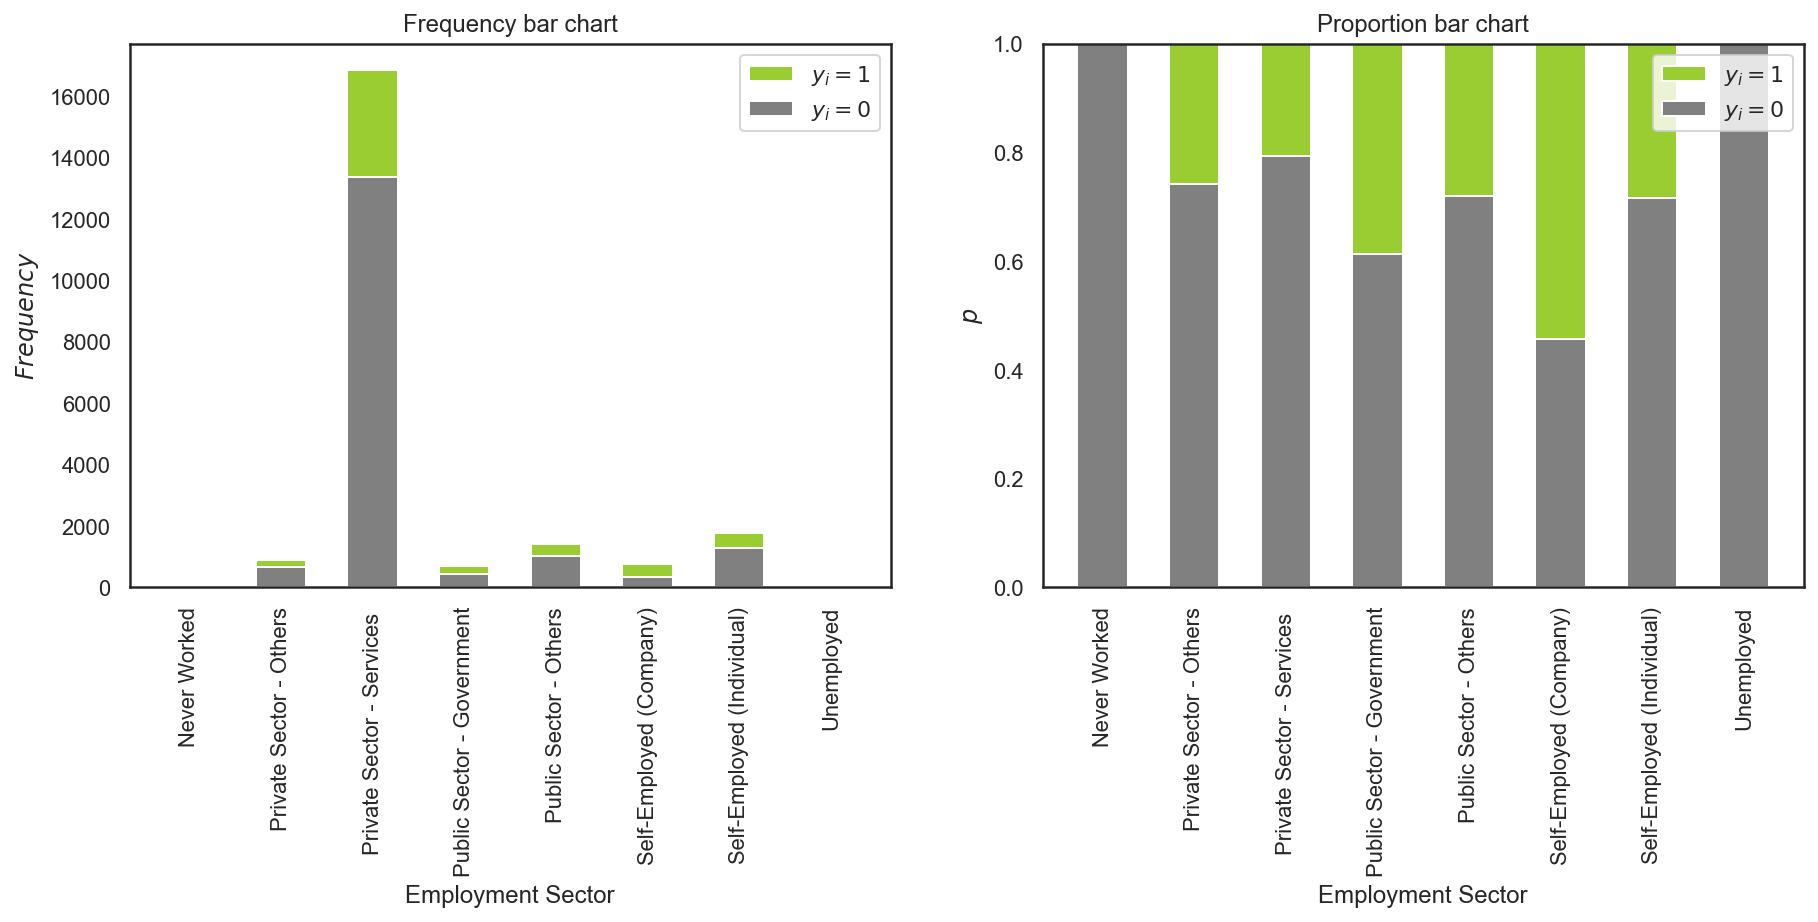

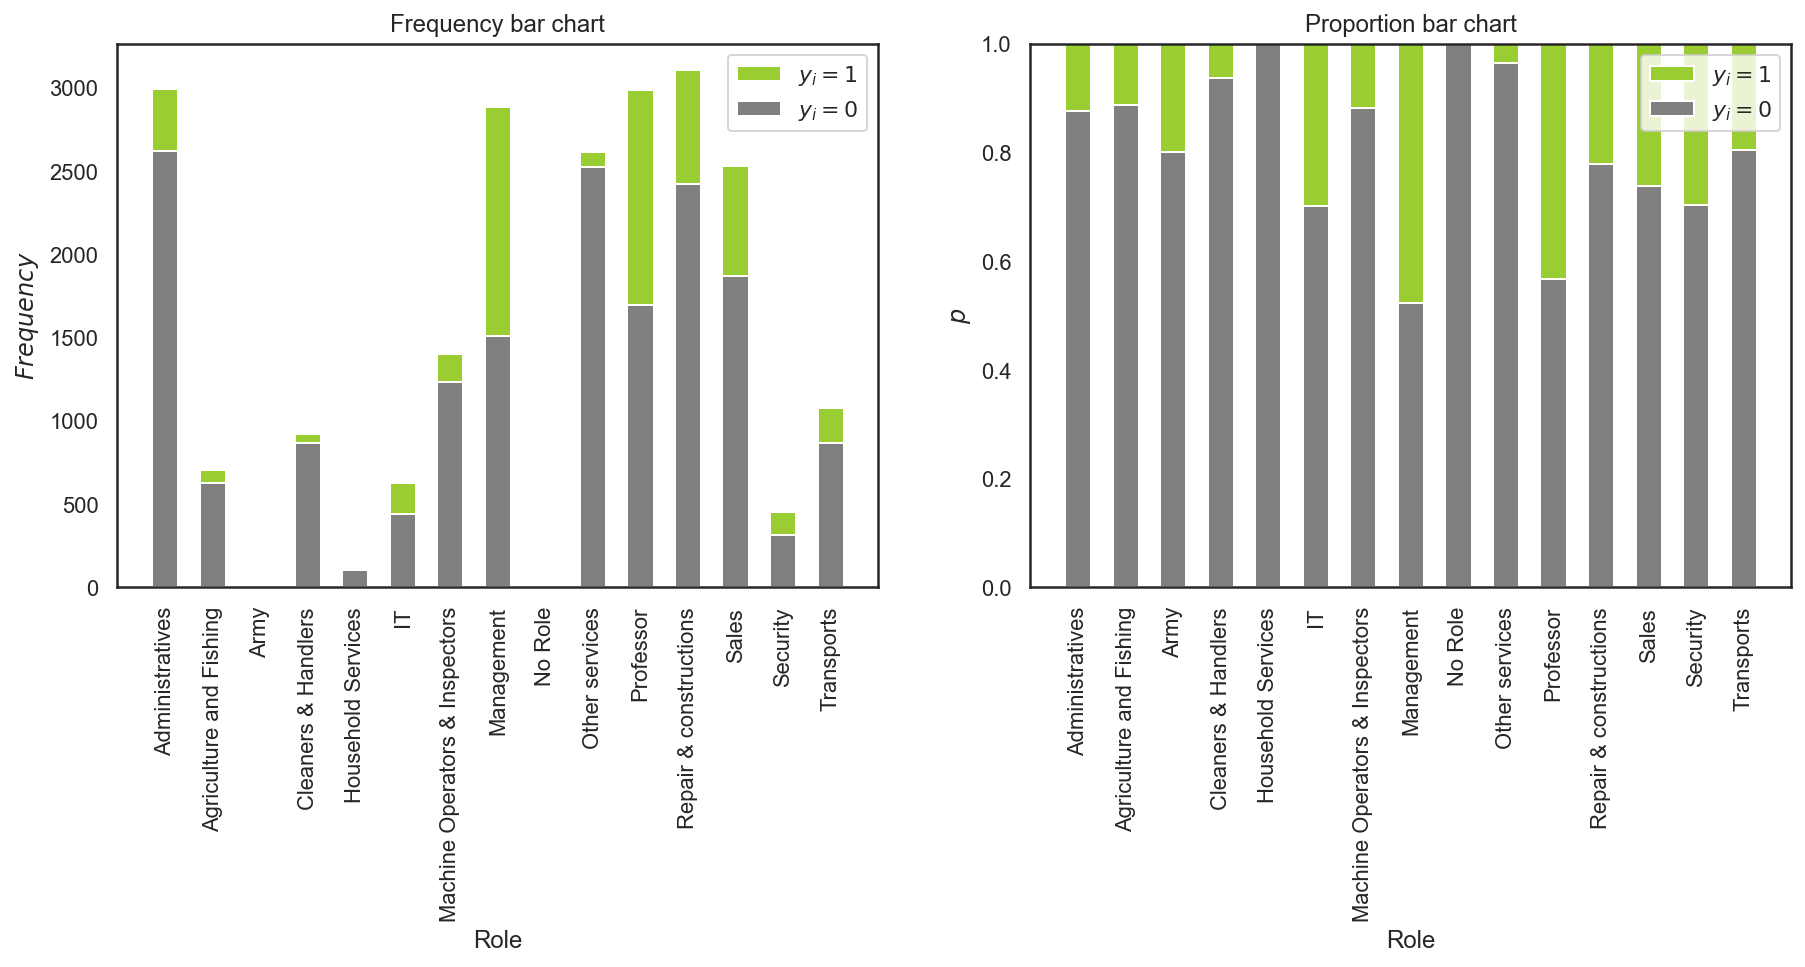

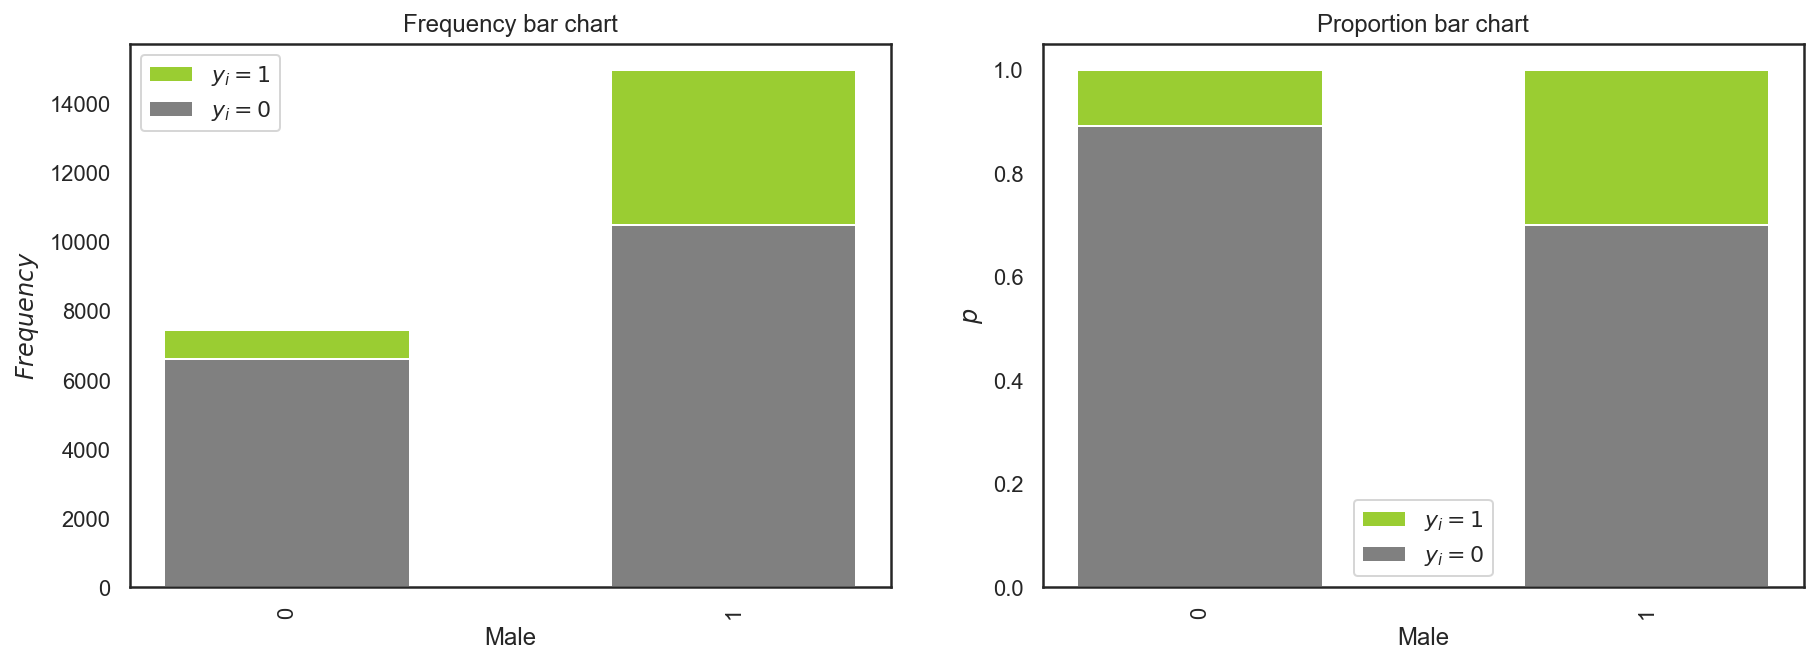

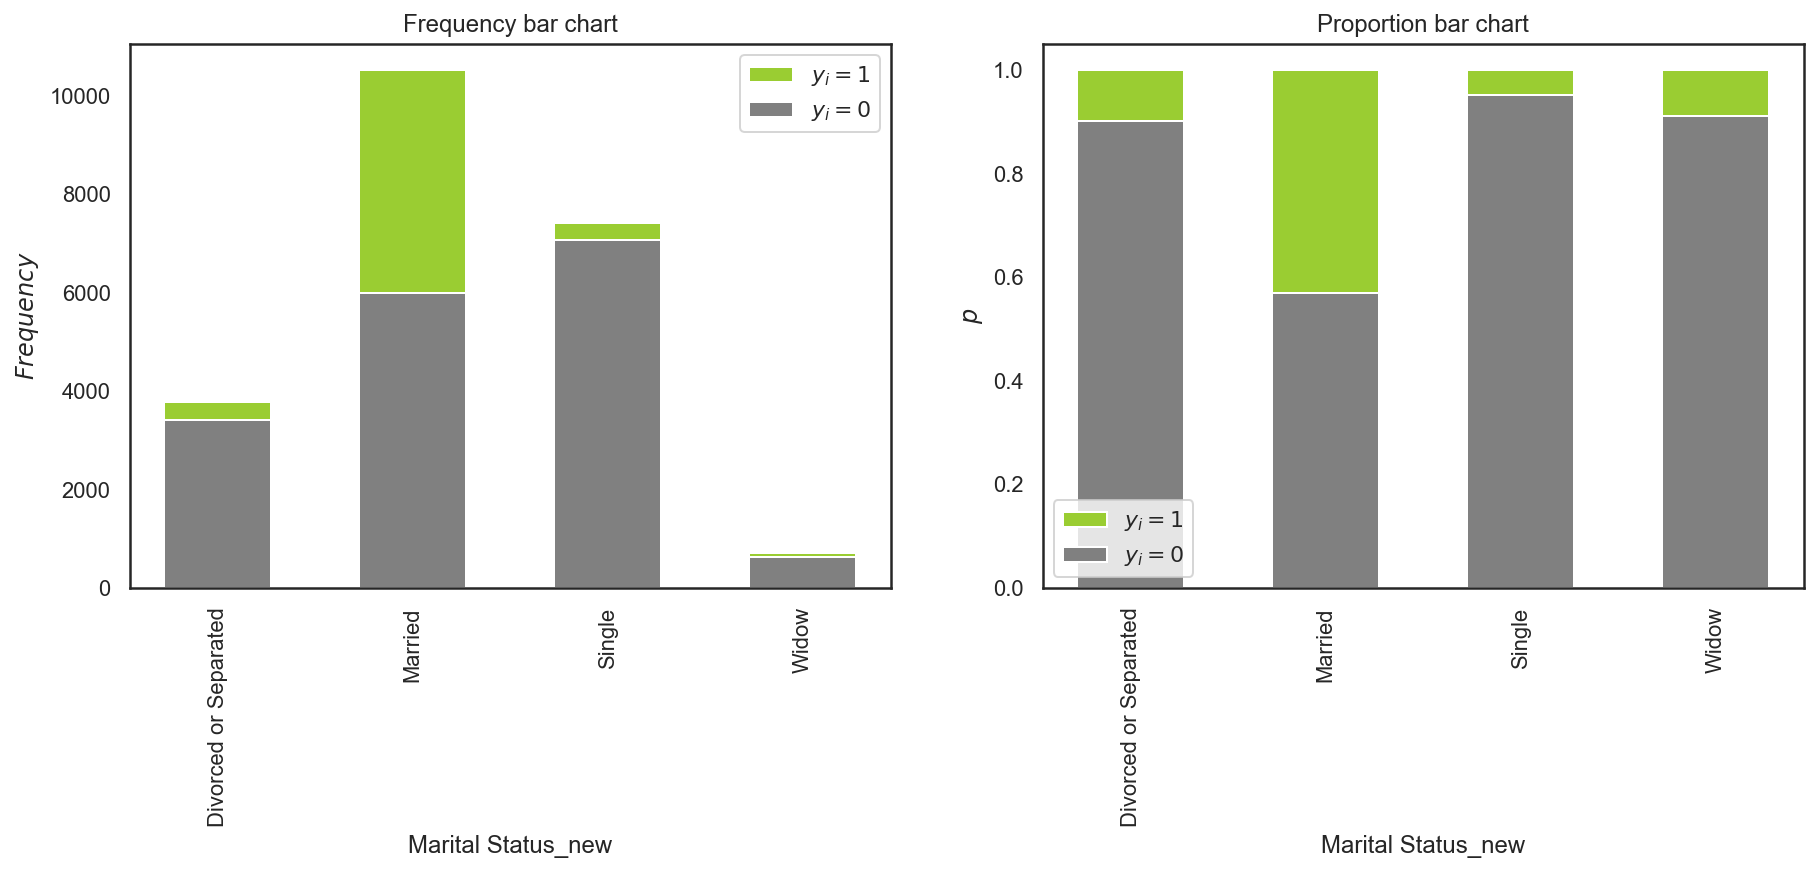

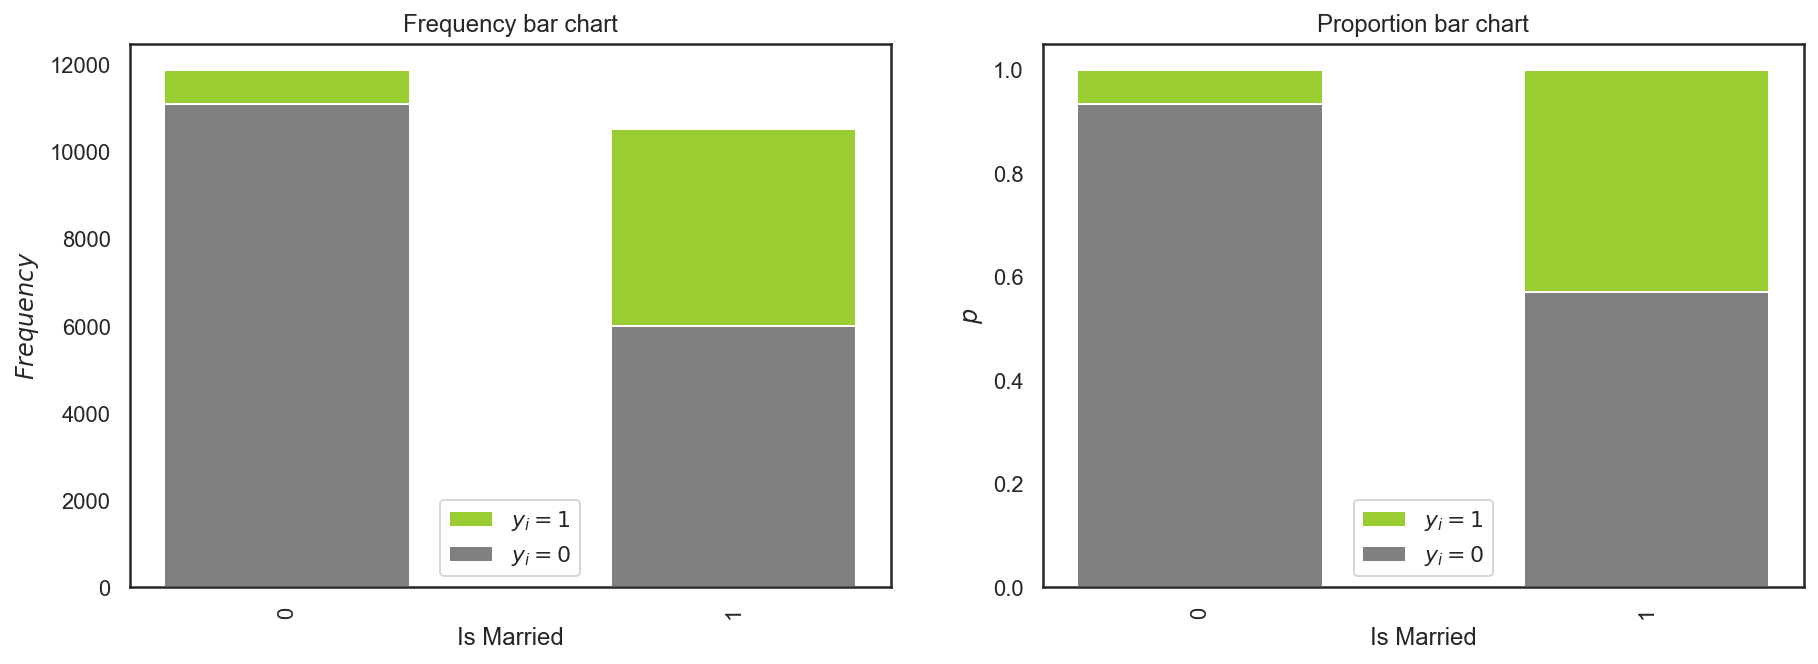

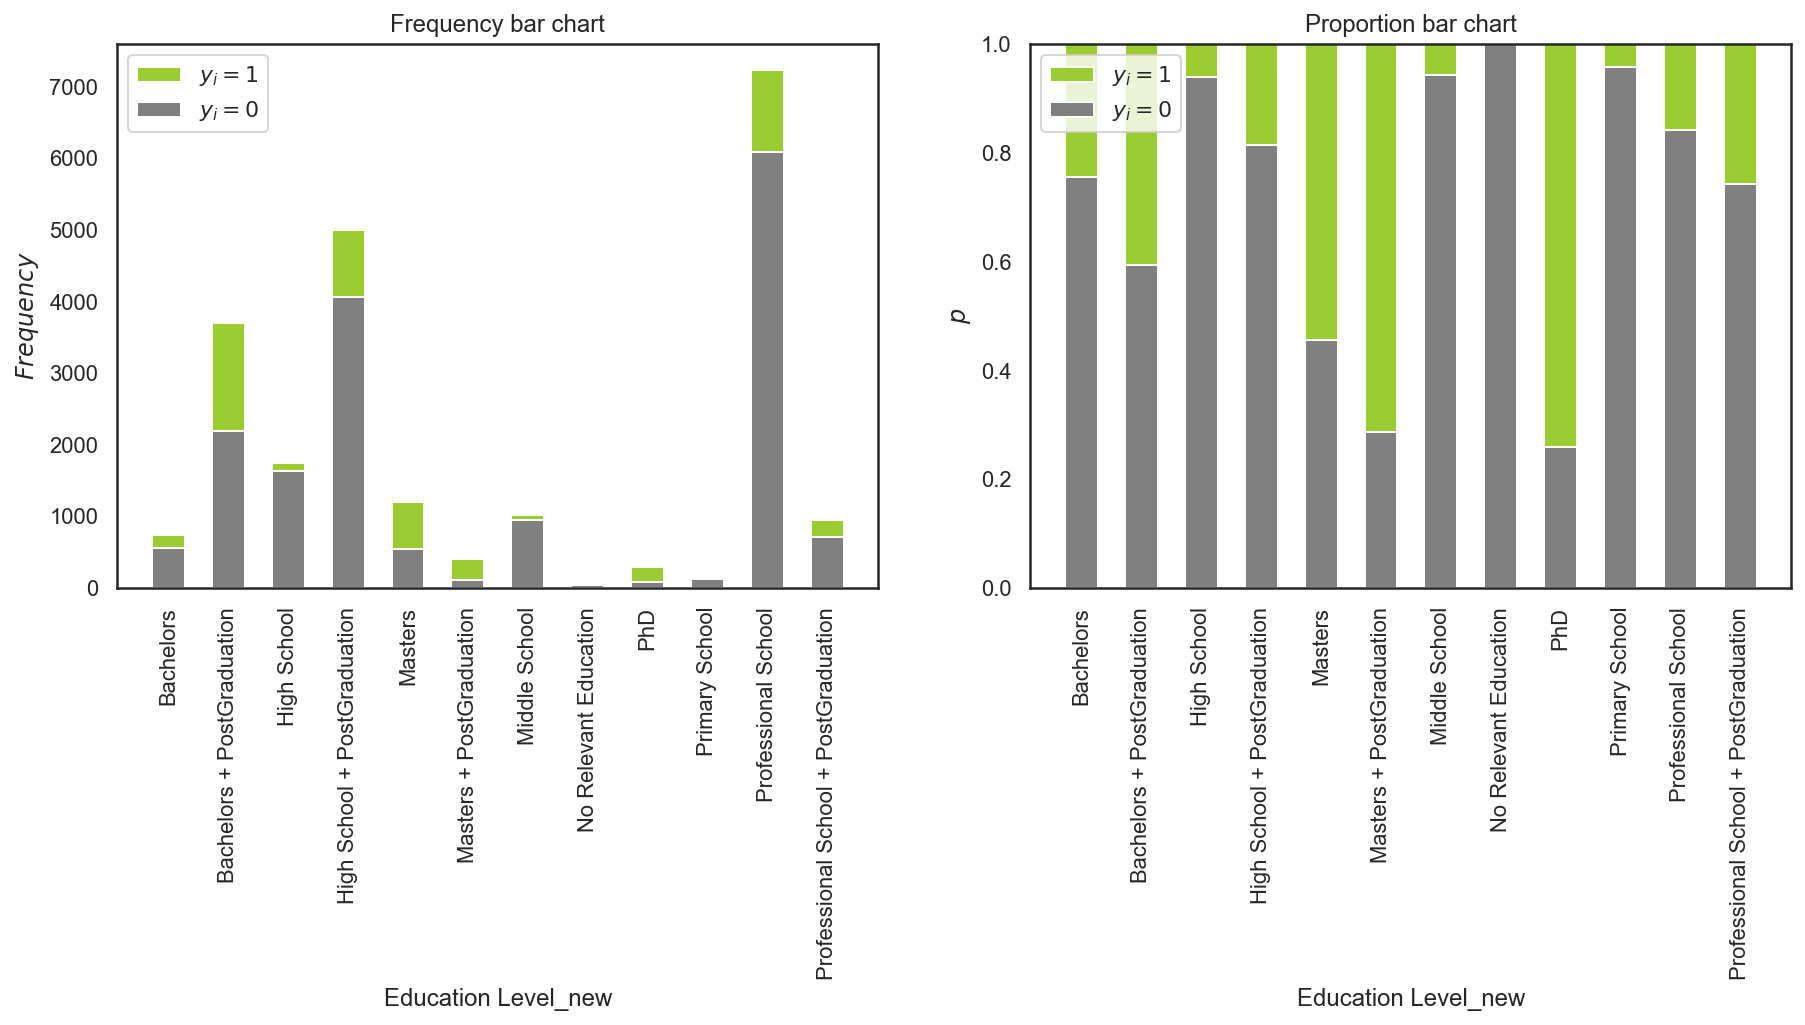

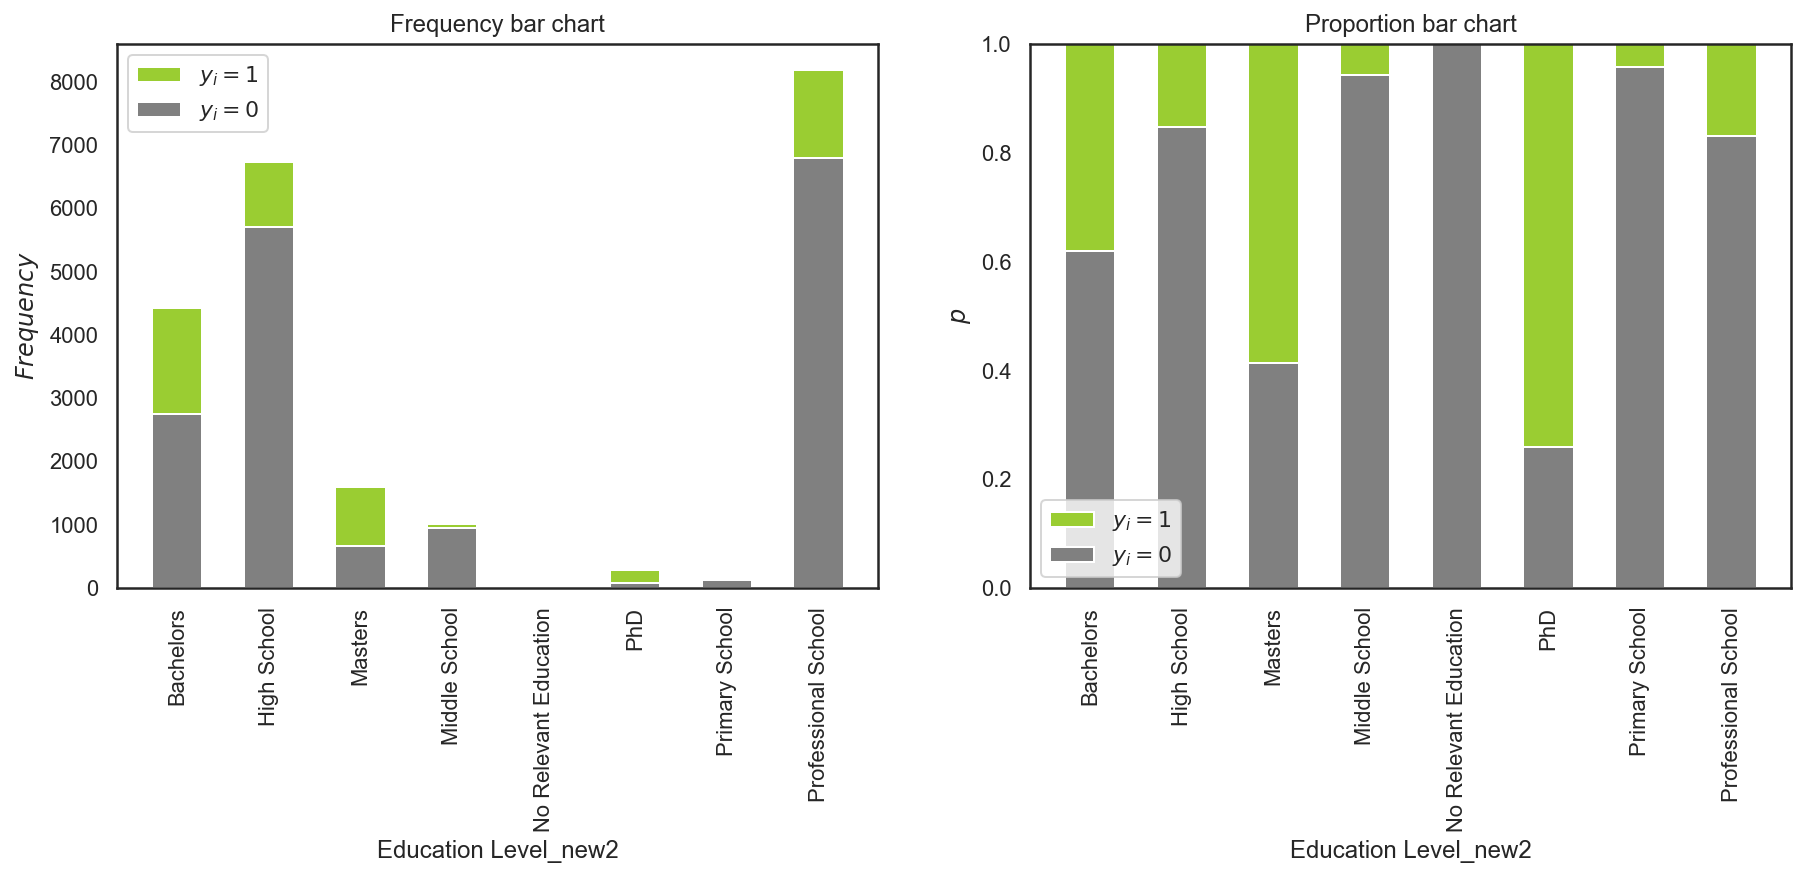

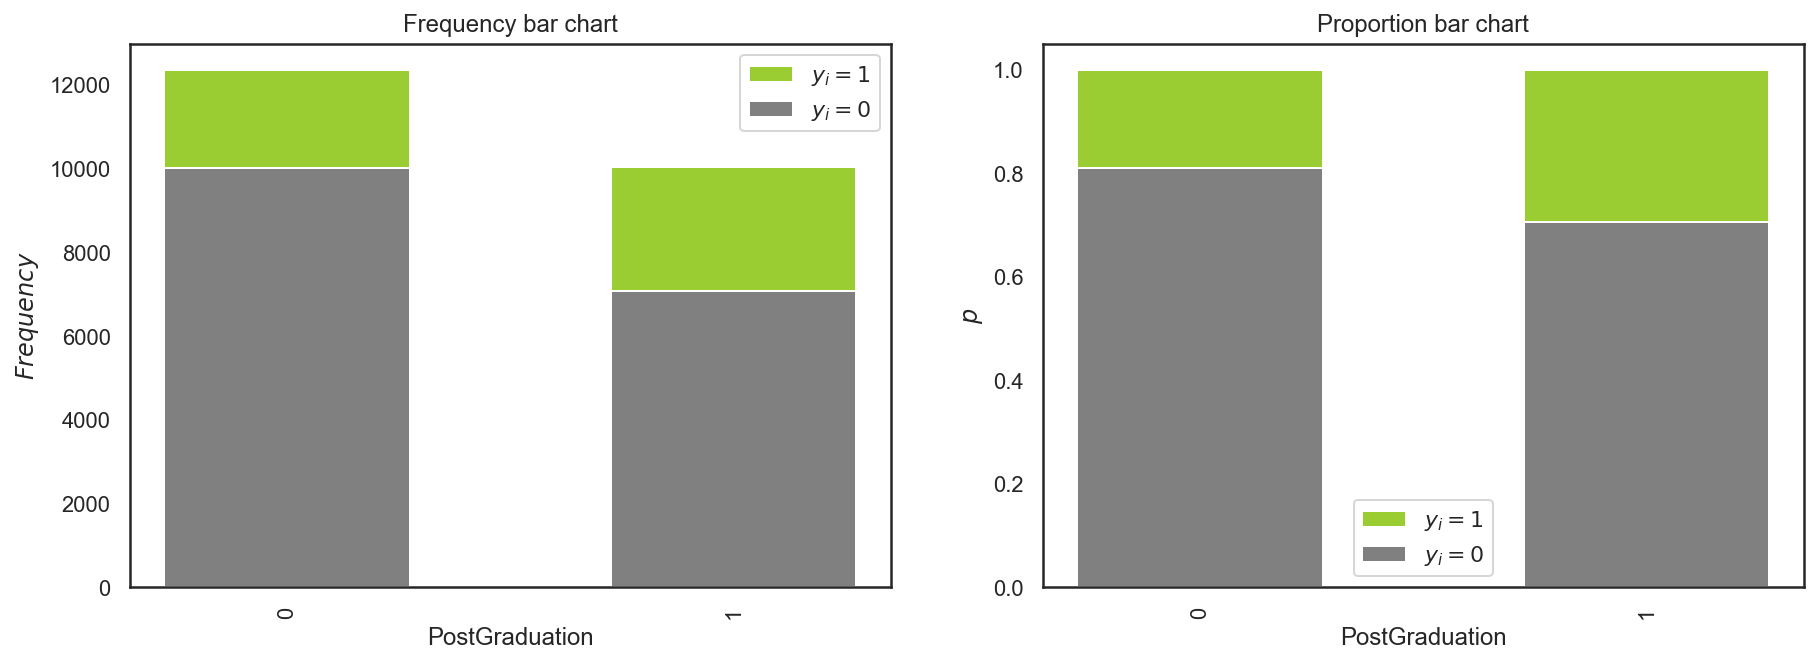

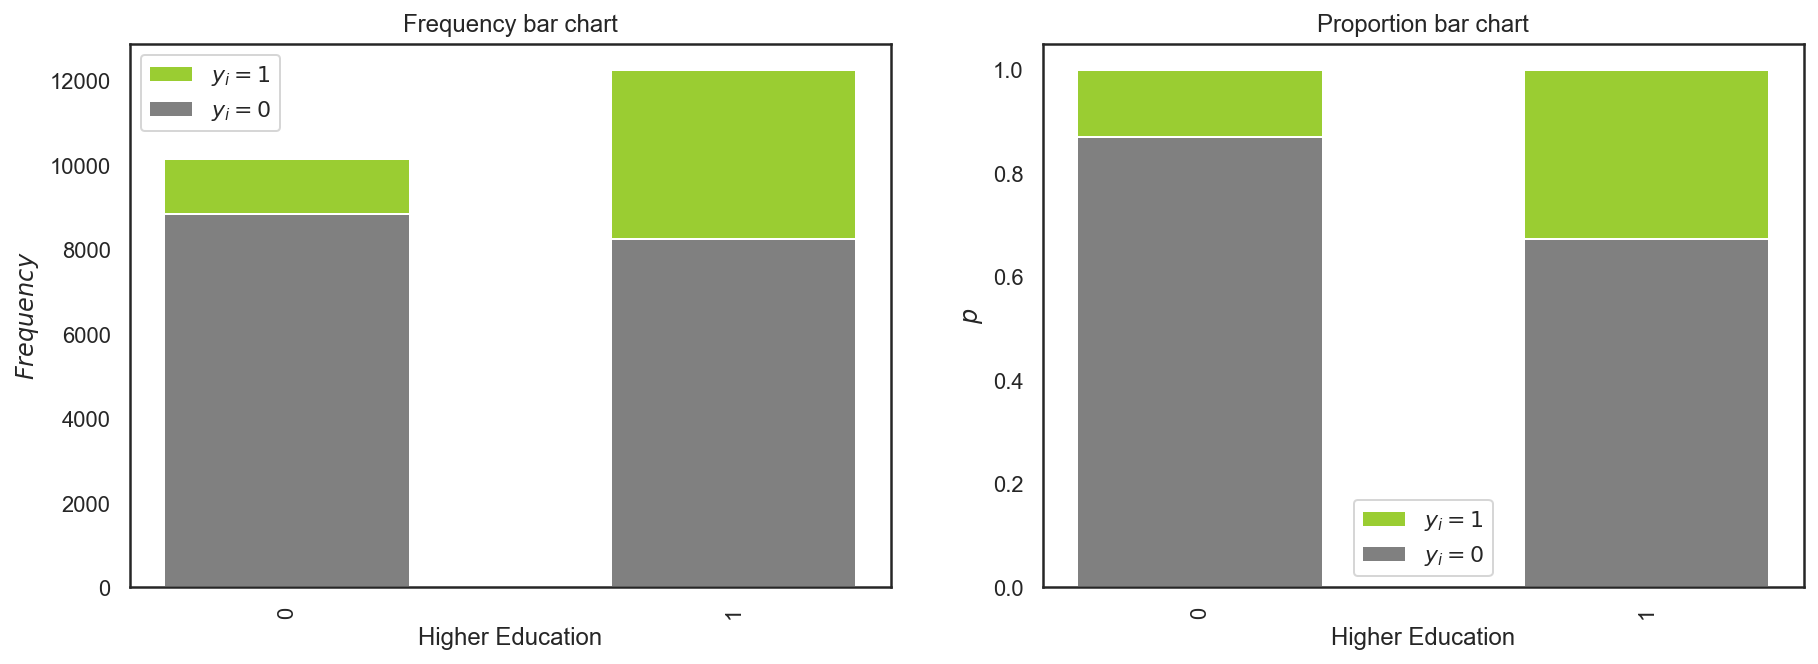

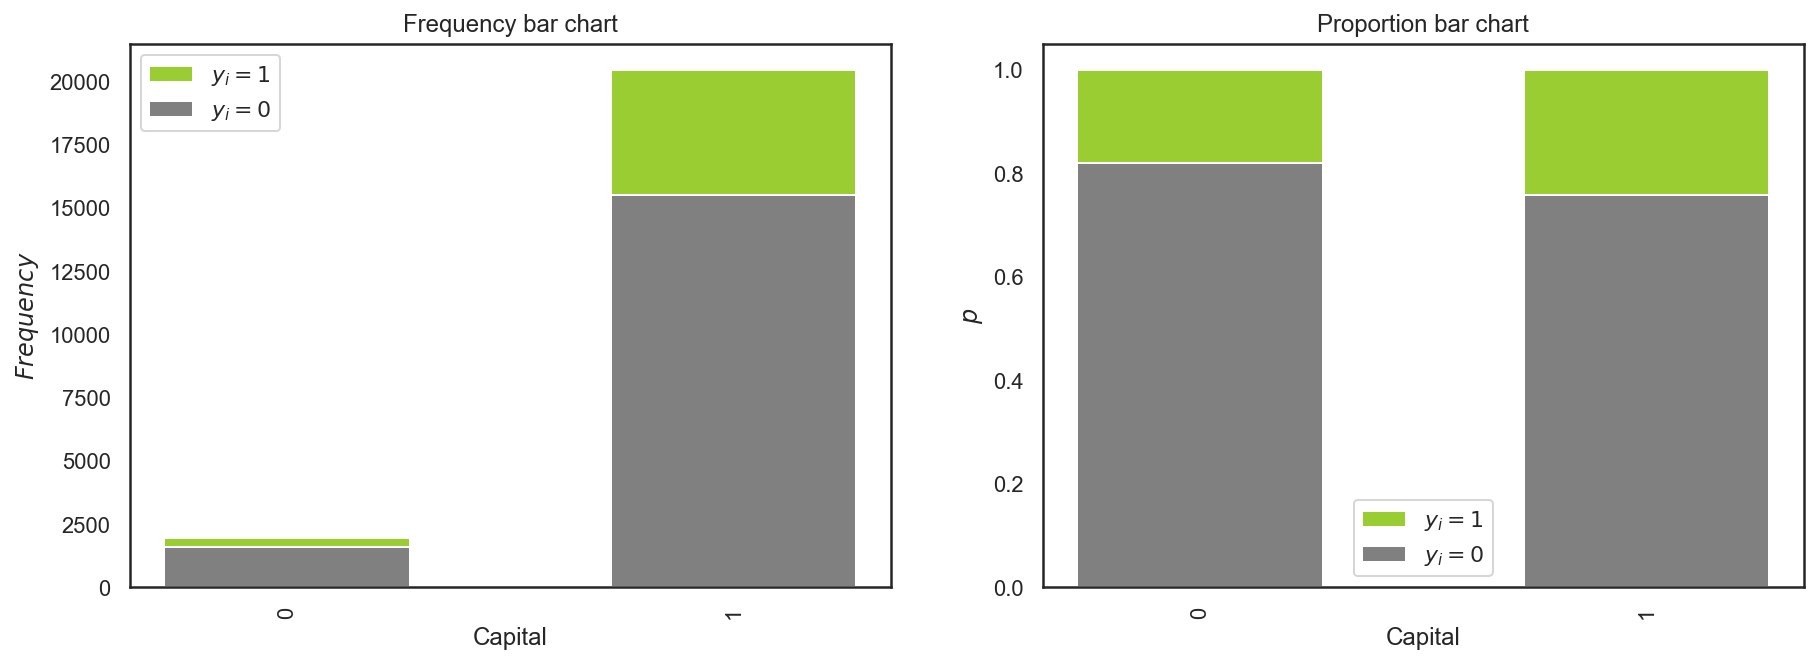

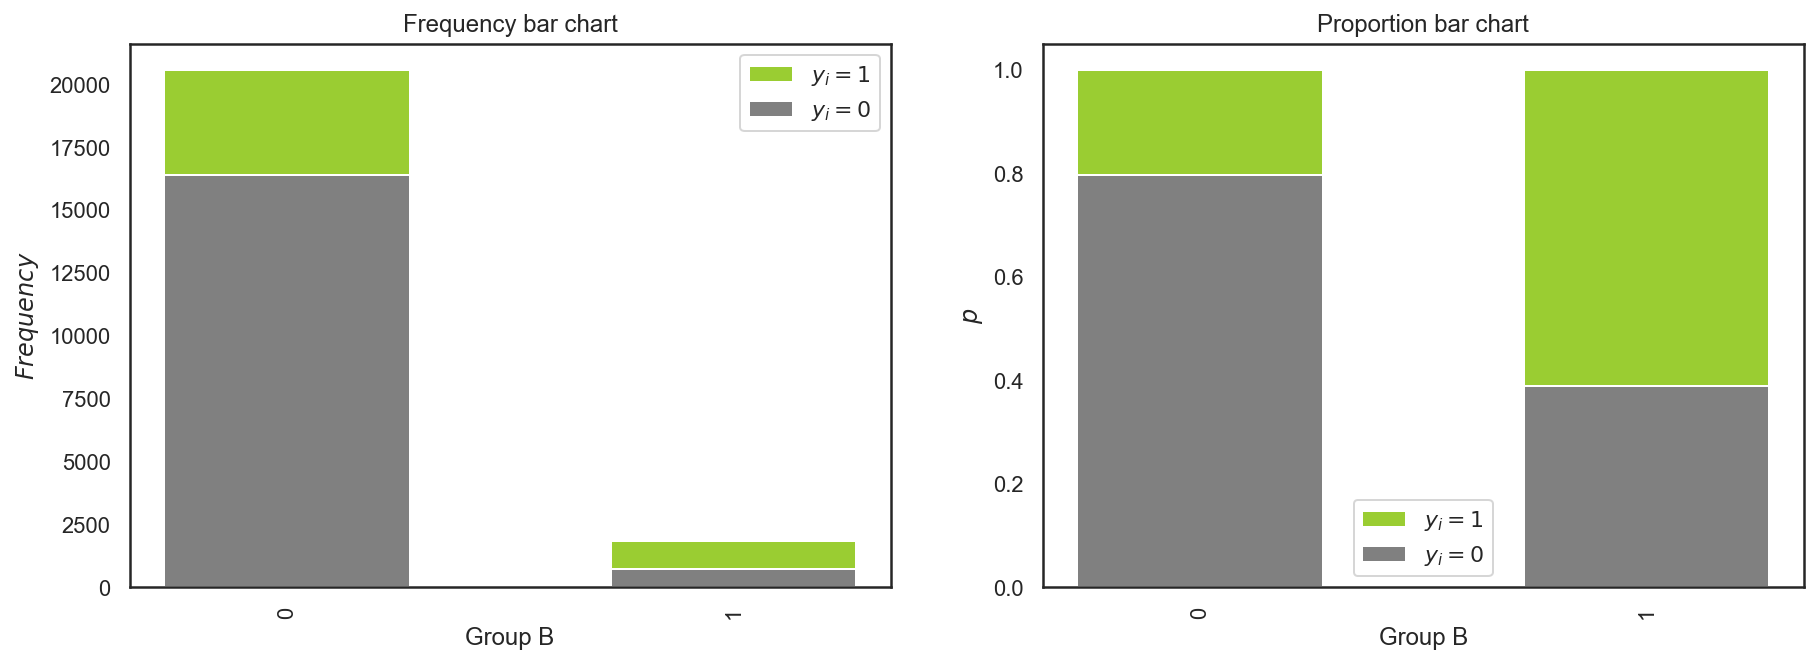

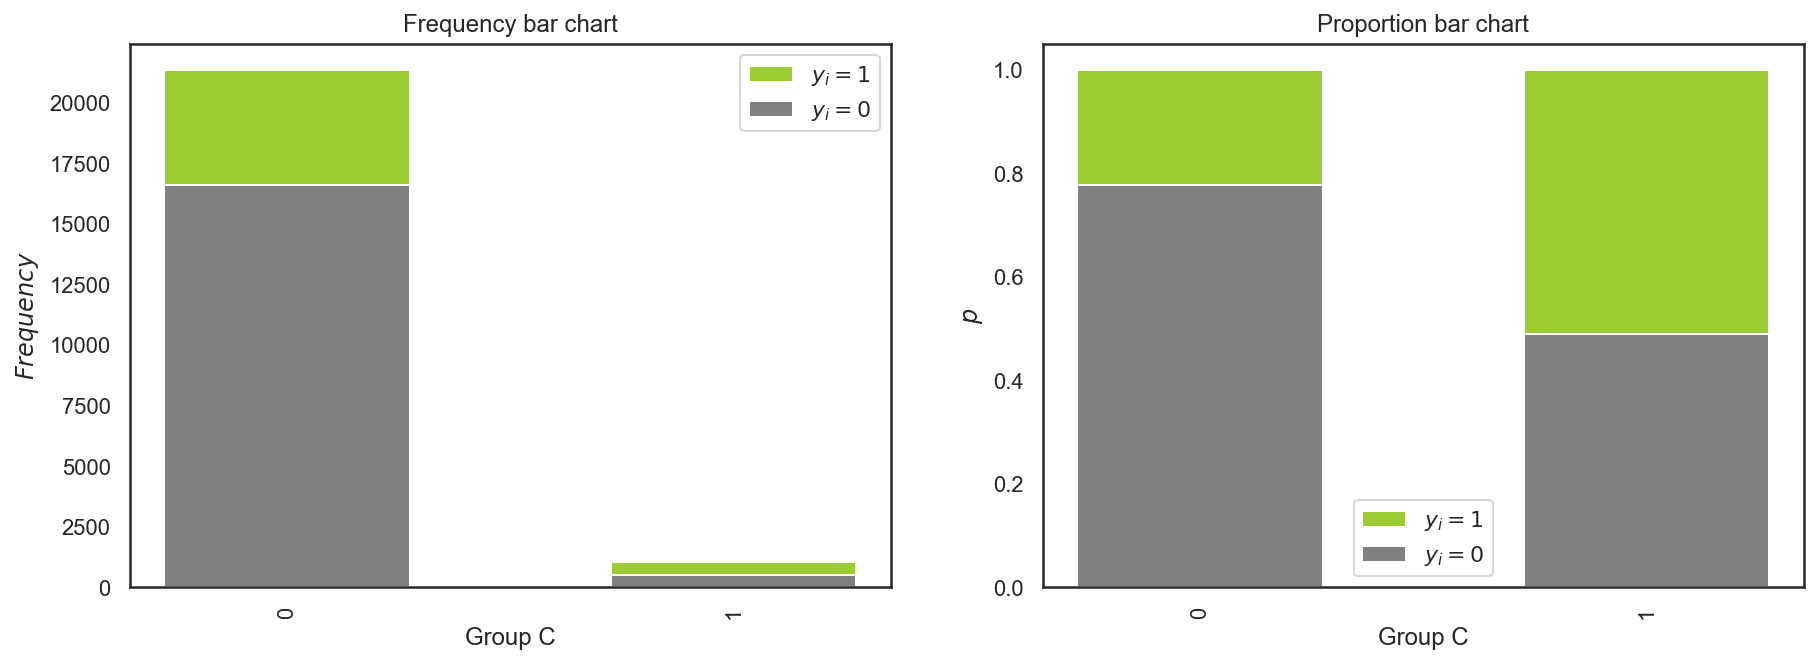

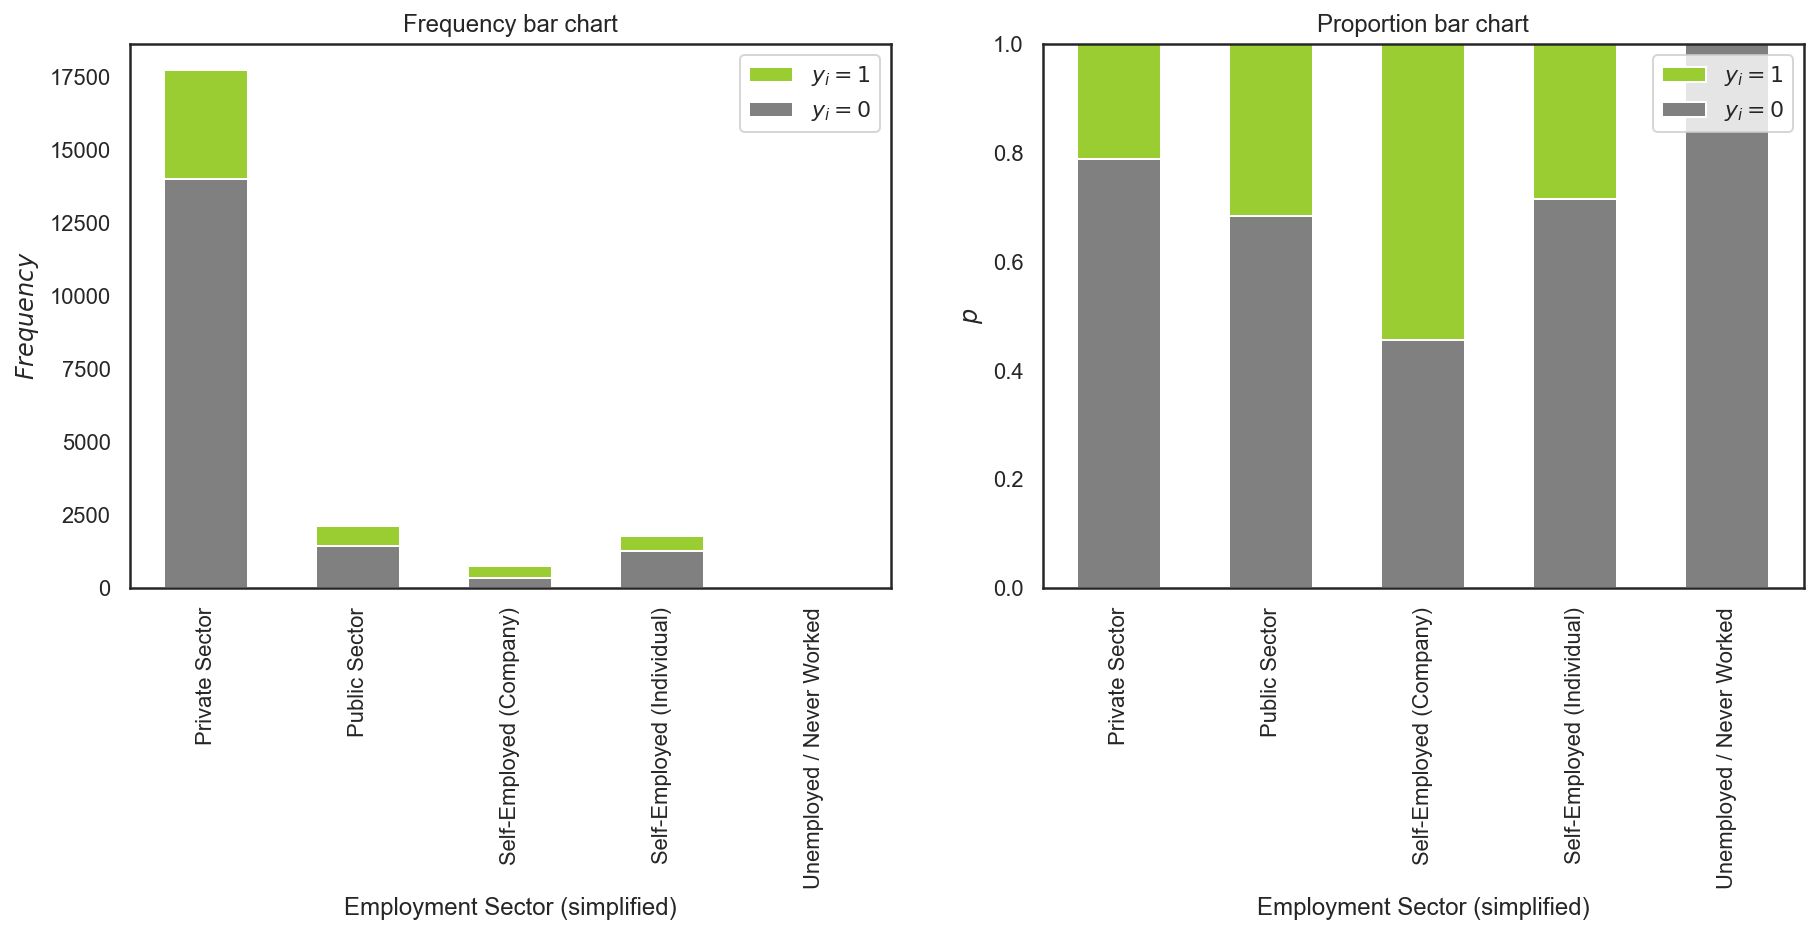

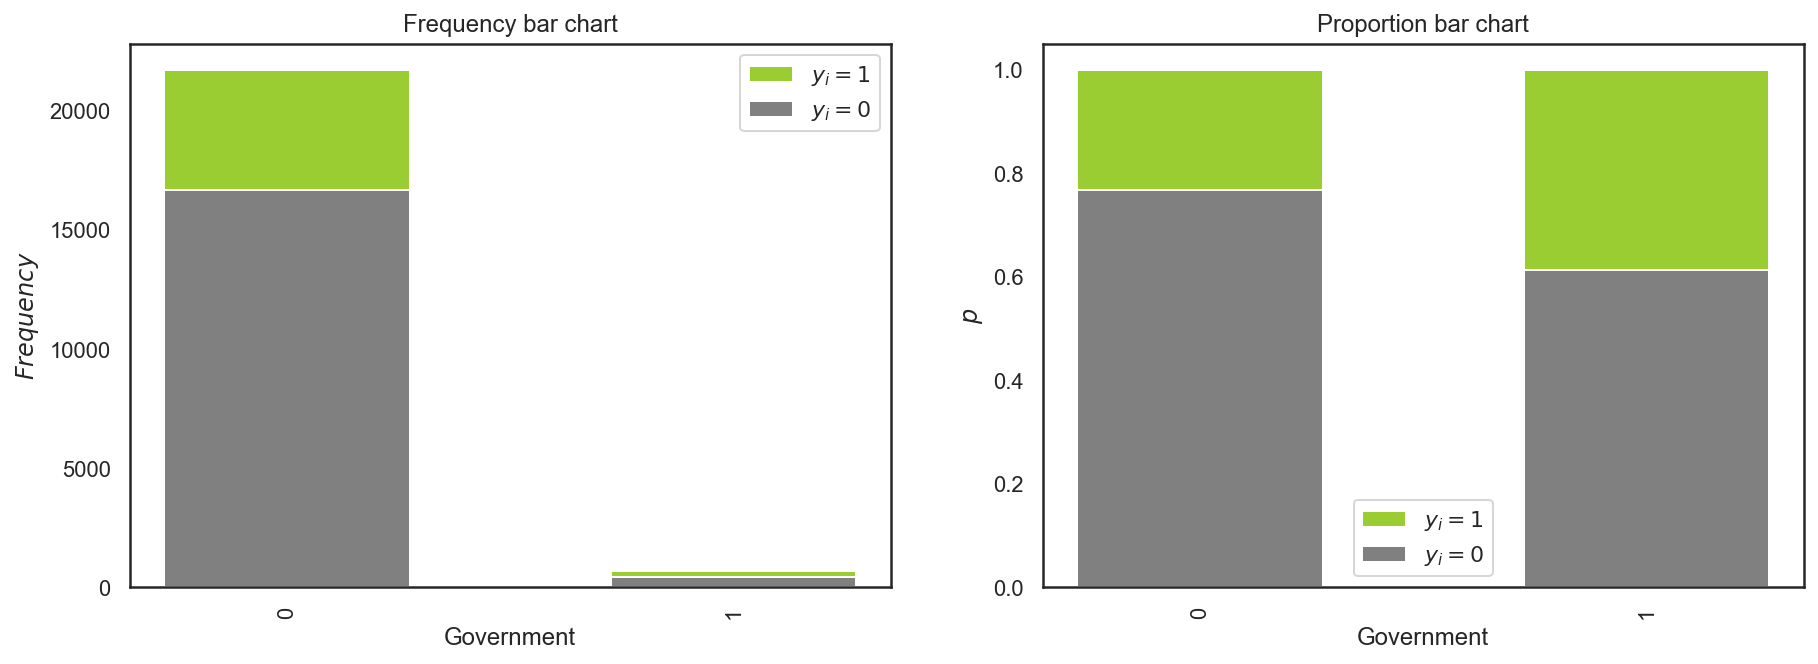

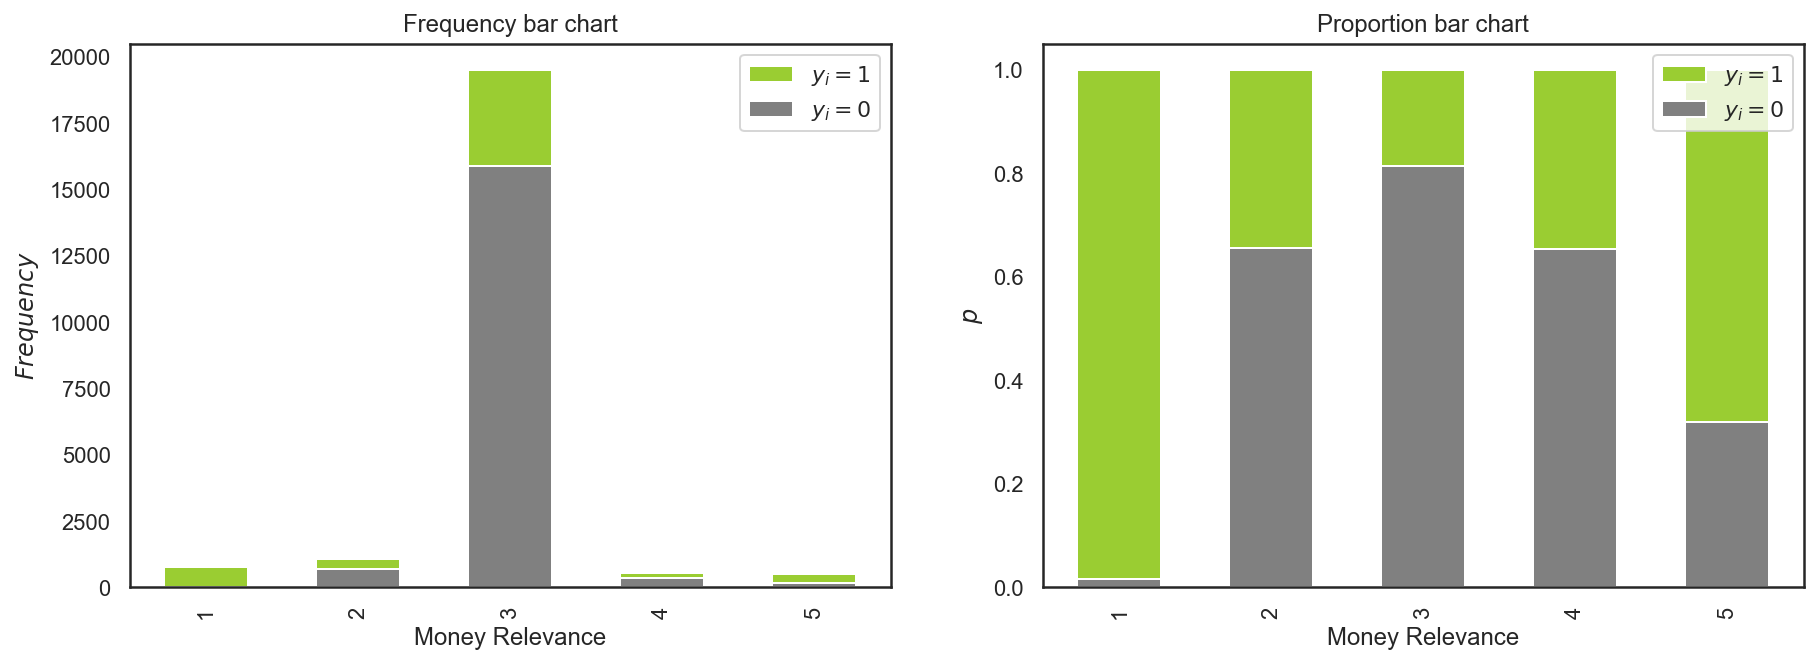

In [111]:
initial_categorical_features = initial_categorical_vars.columns

for i in initial_categorical_features:
    bar_charts_categorical(initial_categorical_vars, i, target)

In [112]:
#por exemplo nas variáveis da Education Level, do Marital Status e assim, há variáveis que são demasiado redundantes entre
#elas, por isso temos de escolher só uma (aquela que distingue melhor os 0s e 1s?)

#as melhores variáveis categ. parecem ser:
#uma das que são do Marital Status
#Lives With é boa, mas parece redudante com as de Marital Status (pq as pessoas que moram com o marido ou a mulher é q tão com 1s) -> mantemos o marital status
#Base Area? fica? por agora não...
#uma das que são do Education Level (a última?)
#uma das que são do Employment Sector?
#Male
#Group B e C!
#Money Relevance

In [113]:
#Binary features that will be droped:
# Base Area
# Lives with

#All these vars will be dropped bc they are too redundant with others:
# Marital Status
# Is Married
# Education Level
# PostGraduation
# Education Level_new
# Employment Sector

df_features = initial_categorical_vars.drop(columns=['Marital Status', 'Is Married', 'Lives with', 'Base Area', 'Education Level', 'Education Level_new', 'Employment Sector'])
df_features.head()
#now, the one hot encoding ->

Native Continent                    Role Male Marital Status_new  \
CITIZEN_ID                                                                    
12486                Europe  Repair & constructions    1            Married   
12487                Europe  Repair & constructions    1            Married   
12488                Europe                   Sales    1            Married   
12489                Europe                Security    1            Married   
12490                Europe               Professor    1             Single   

           Education Level_new2 PostGraduation Higher Education Capital  \
CITIZEN_ID                                                                
12486               High School              1                1       1   
12487       Professional School              0                0       1   
12488       Professional School              0                0       1   
12489               High School              0                0       1   
12490                       PhD              0                1       1   

           Group B Group C Employment Sector (simplified) Government  \
CITIZEN_ID                                                             
12486            0       1                 Private Sector          0   
12487            0       0                  Public Sector          0   
12488            0       1                 Private Sector          0   
12489            1       0                 Private Sector          0   
12490            0       0     Self-Employed (Individual)          0   

           Money Relevance  
CITIZEN_ID                  
12486                    4  
12487                    3  
12488                    4  
12489                    2  
12490                    3

### Encoding

In [114]:
pd.set_option('display.max_columns', None)

df_ohc = df_features.drop(columns=['Male', 'Higher Education', 'Capital', 'Group B', 'Group C', 'PostGraduation','Government']).copy()

# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, dtype=int) #MUDAR os x1_ pelo nome da variável???
ohc_feat = ohc.fit_transform(df_ohc)
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df

x0_Africa  x0_America  x0_Asia  x0_Europe  x0_Oceania  \
CITIZEN_ID                                                          
12486               0           0        0          1           0   
12487               0           0        0          1           0   
12488               0           0        0          1           0   
12489               0           0        0          1           0   
12490               0           0        0          1           0   
...               ...         ...      ...        ...         ...   
34881               0           0        0          1           0   
34882               0           0        0          1           0   
34883               0           0        0          1           0   
34884               0           0        0          1           0   
34885               0           0        1          0           0   

            x1_Administratives  x1_Agriculture and Fishing  x1_Army  \
CITIZEN_ID                                                            
12486                        0                           0        0   
12487                        0                           0        0   
12488                        0                           0        0   
12489                        0                           0        0   
12490                        0                           0        0   
...                        ...                         ...      ...   
34881                        0                           0        0   
34882                        0                           0        0   
34883                        0                           0        0   
34884                        0                           0        0   
34885                        0                           0        0   

            x1_Cleaners & Handlers  x1_Household Services  x1_IT  \
CITIZEN_ID                                                         
12486                            0                      0      0   
12487                            0                      0      0   
12488                            0                      0      0   
12489                            0                      0      0   
12490                            0                      0      0   
...                            ...                    ...    ...   
34881                            1                      0      0   
34882                            0                      0      0   
34883                            0                      0      0   
34884                            0                      0      0   
34885                            0                      0      0   

            x1_Machine Operators & Inspectors  x1_Management  x1_No Role  \
CITIZEN_ID                                                                 
12486                                       0              0           0   
12487                                       0              0           0   
12488                                       0              0           0   
12489                                       0              0           0   
12490                                       0              0           0   
...                                       ...            ...         ...   
34881                                       0              0           0   
34882                                       0              0           0   
34883                                       0              0           0   
34884                                       0              0           0   
34885                                       0              0           0   

            x1_Other services  x1_Professor  x1_Repair & constructions  \
CITIZEN_ID                                                               
12486                       0             0                          1   
12487                       0             0                          1   
12488               

<AxesSubplot:xlabel='Value', ylabel='Col'>

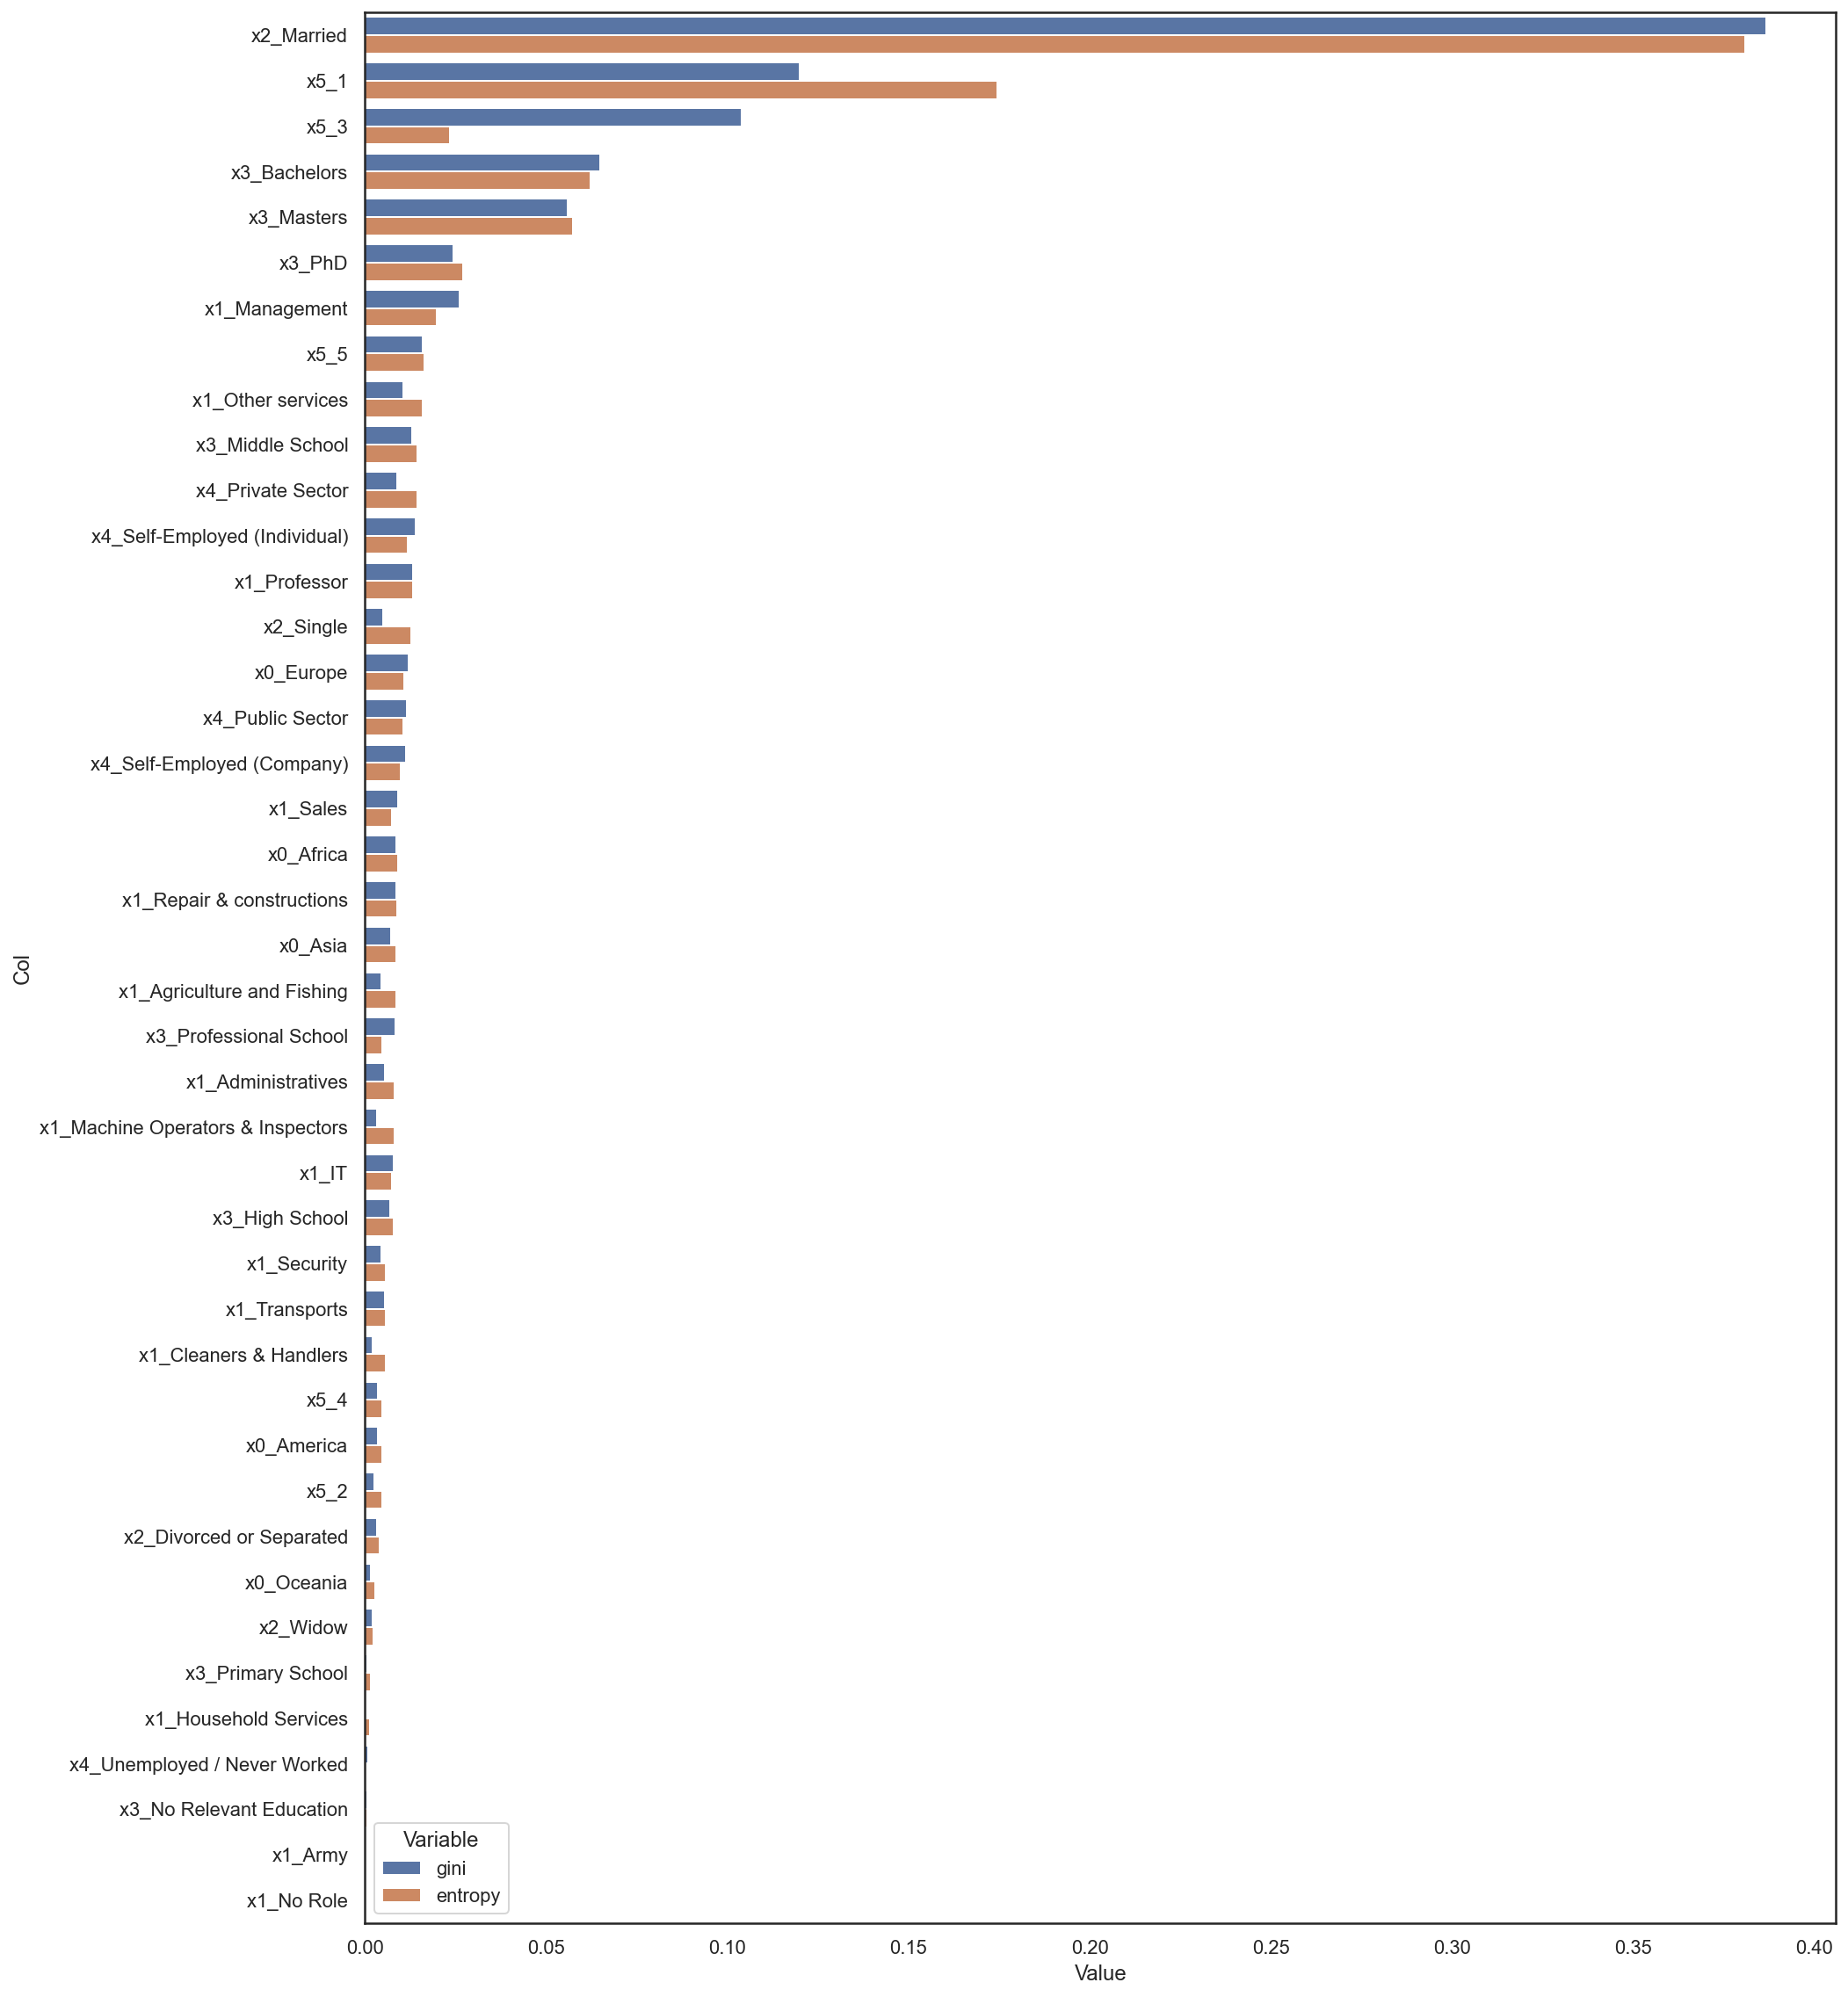

In [115]:
#feature importance with all binaries to check the classes with the lowest feature importance on each categorical

#feature importance using the split criteria 'Gini'
gini_importance = DecisionTreeClassifier().fit(ohc_df, target).feature_importances_

#feature importance using the split criteria 'Entropy'
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(ohc_df, target).feature_importances_

#plotting the feature importances for both criteria
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = ohc_df.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,20))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [116]:
#instead of dropping the first, we drop the less "important" according to frquency and proportion charts,
#and we also checked which class had less feature importance on each categorical feature
ohc_df.drop(columns=['x0_Oceania', 'x1_No Role', 'x2_Widow', 'x3_No Relevant Education', 'x4_Unemployed / Never Worked', 'x5_4'], inplace=True)

In [117]:
# Reassigning df to contain ohc variables
non_metric_binary = pd.concat([df_features.drop(columns=df_ohc.columns), ohc_df], axis=1)
non_metric_binary.head()

Male PostGraduation Higher Education Capital Group B Group C  \
CITIZEN_ID                                                                
12486         1              1                1       1       0       1   
12487         1              0                0       1       0       0   
12488         1              0                0       1       0       1   
12489         1              0                0       1       1       0   
12490         1              0                1       1       0       0   

           Government  x0_Africa  x0_America  x0_Asia  x0_Europe  \
CITIZEN_ID                                                         
12486               0          0           0        0          1   
12487               0          0           0        0          1   
12488               0          0           0        0          1   
12489               0          0           0        0          1   
12490               0          0           0        0          1   

            x1_Administratives  x1_Agriculture and Fishing  x1_Army  \
CITIZEN_ID                                                            
12486                        0                           0        0   
12487                        0                           0        0   
12488                        0                           0        0   
12489                        0                           0        0   
12490                        0                           0        0   

            x1_Cleaners & Handlers  x1_Household Services  x1_IT  \
CITIZEN_ID                                                         
12486                            0                      0      0   
12487                            0                      0      0   
12488                            0                      0      0   
12489                            0                      0      0   
12490                            0                      0      0   

            x1_Machine Operators & Inspectors  x1_Management  \
CITIZEN_ID                                                     
12486                                       0              0   
12487                                       0              0   
12488                                       0              0   
12489                                       0              0   
12490                                       0              0   

            x1_Other services  x1_Professor  x1_Repair & constructions  \
CITIZEN_ID                                                               
12486                       0             0                          1   
12487                       0             0                          1   
12488                       0             0                          0   
12489                       0             0                          0   
12490                       0             1                          0   

            x1_Sales  x1_Security  x1_Transports  x2_Divorced or Separated  \
CITIZEN_ID                                                                   
12486              0            0              0                         0   
12487              0            0              0                         0   
12488              1            0              0                         0   
12489              0            1              0                         0   
12490              0            0              0                         0   

            x2_Married  x2_Single  x3_Bachelors  x3_High School  x3_Masters  \
CITIZEN_ID                                                                    
12486                1          0             0               1           0   
12487                1          0             0               0           0   
12488                1          0             0               0           0   
12489                1          0             0               1           0   
12490                0          1           

In [118]:
non_metric_binary.loc[:, np.array(non_metric_binary.dtypes=="object")] = non_metric_binary.loc[:, np.array(non_metric_binary.dtypes=="object")].astype(int)

In [119]:
all_variables = pd.concat([non_metric_binary, stand_metric], axis=1)
all_variables.head()

Male  PostGraduation  Higher Education  Capital  Group B  Group C  \
CITIZEN_ID                                                                      
12486          1               1                 1        1        0        1   
12487          1               0                 0        1        0        0   
12488          1               0                 0        1        0        1   
12489          1               0                 0        1        1        0   
12490          1               0                 1        1        0        0   

            Government  x0_Africa  x0_America  x0_Asia  x0_Europe  \
CITIZEN_ID                                                          
12486                0          0           0        0          1   
12487                0          0           0        0          1   
12488                0          0           0        0          1   
12489                0          0           0        0          1   
12490                0          0           0        0          1   

            x1_Administratives  x1_Agriculture and Fishing  x1_Army  \
CITIZEN_ID                                                            
12486                        0                           0        0   
12487                        0                           0        0   
12488                        0                           0        0   
12489                        0                           0        0   
12490                        0                           0        0   

            x1_Cleaners & Handlers  x1_Household Services  x1_IT  \
CITIZEN_ID                                                         
12486                            0                      0      0   
12487                            0                      0      0   
12488                            0                      0      0   
12489                            0                      0      0   
12490                            0                      0      0   

            x1_Machine Operators & Inspectors  x1_Management  \
CITIZEN_ID                                                     
12486                                       0              0   
12487                                       0              0   
12488                                       0              0   
12489                                       0              0   
12490                                       0              0   

            x1_Other services  x1_Professor  x1_Repair & constructions  \
CITIZEN_ID                                                               
12486                       0             0                          1   
12487                       0             0                          1   
12488                       0             0                          0   
12489                       0             0                          0   
12490                       0             1                          0   

            x1_Sales  x1_Security  x1_Transports  x2_Divorced or Separated  \
CITIZEN_ID                                                                   
12486              0            0              0                         0   
12487              0            0              0                         0   
12488              1            0              0                         0   
12489              0            1              0                         0   
12490              0            0              0                         0   

            x2_Married  x2_Single  x3_Bachelors  x3_High School  x3_Masters  \
CITIZEN_ID                                                                    
12486                1          0             0               1           0   
12487                1          0             0               0           0   
12488                1          0             0               0           0   
12489                1          0             0               1           0

### With decision trees

<AxesSubplot:xlabel='Value', ylabel='Col'>

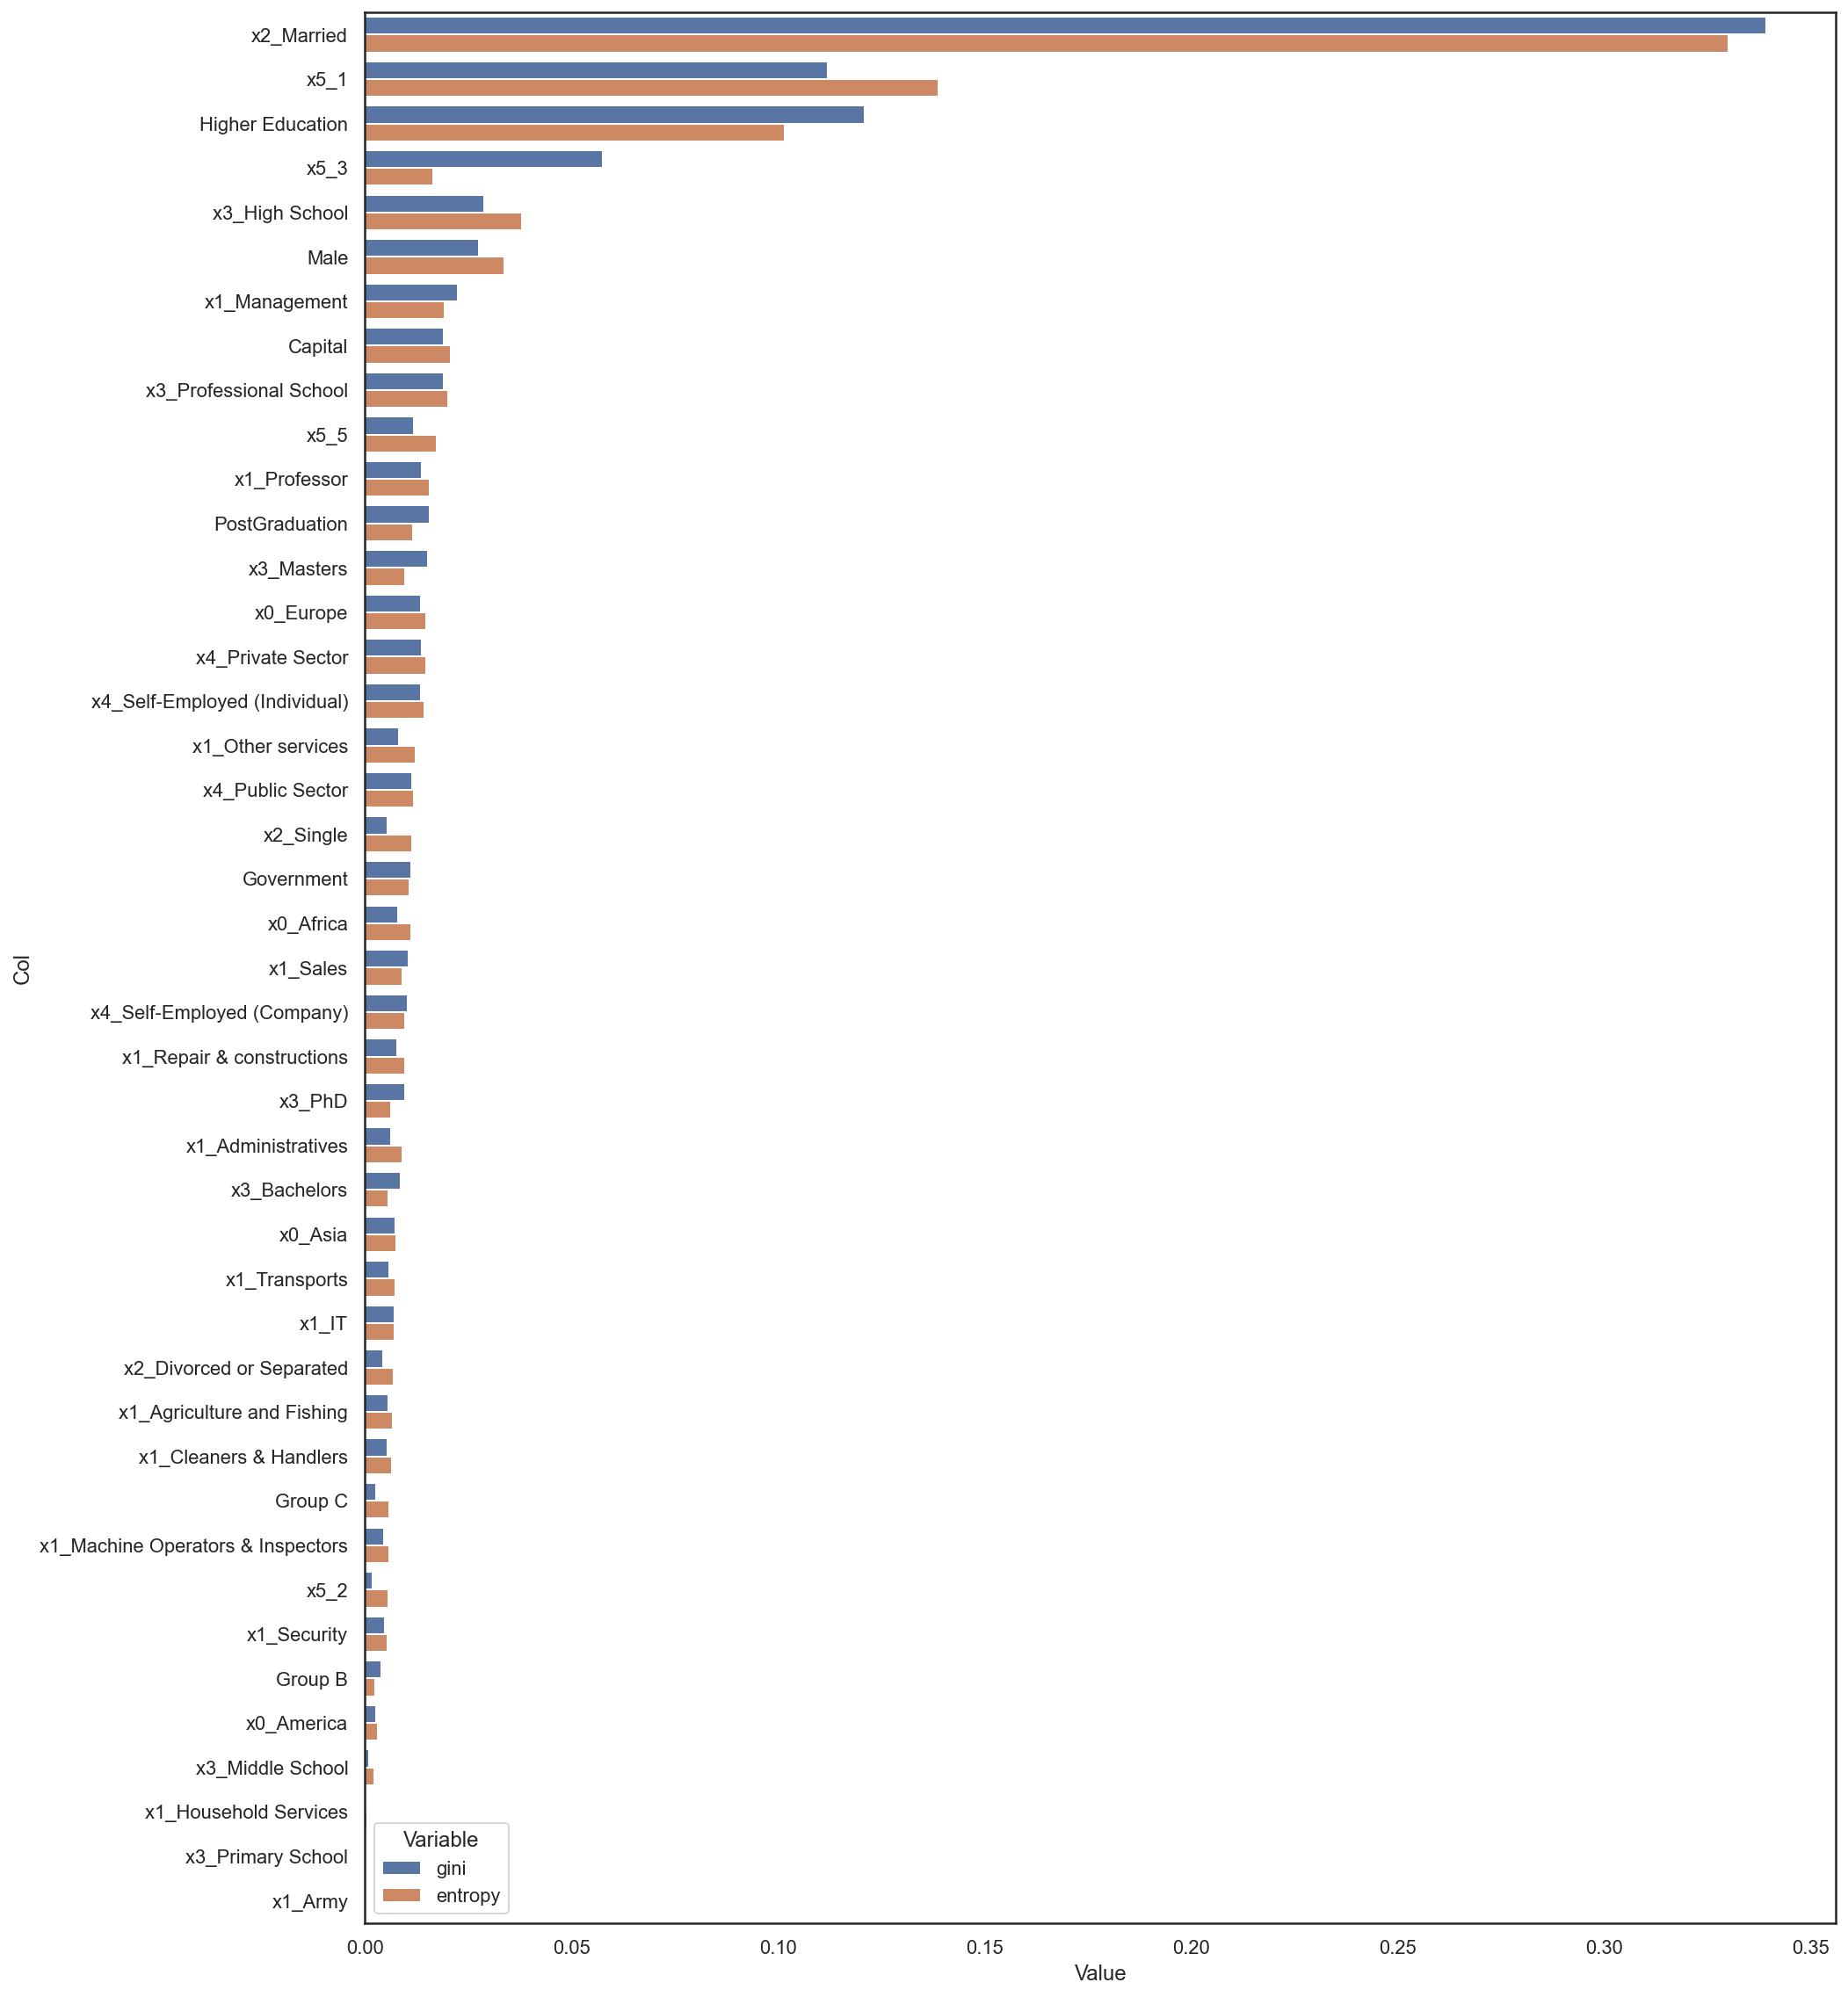

In [120]:
#feature importance using the split criteria 'Gini'
gini_importance = DecisionTreeClassifier().fit(non_metric_binary, target).feature_importances_

#feature importance using the split criteria 'Entropy'
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(non_metric_binary, target).feature_importances_

#plotting the feature importances for both criteria
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = non_metric_binary.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,20))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

#1. x2_Married
#2. x5_1
#3. Higher Education
#4. x5_3
#5. x3_High School
#6. Male
#7. x1_Management
#8. x3_Professional School
#9. Capital
#10. x5_5
#11. x4_Private Sector
#12. PostGraduation
#13. x0_Europe

### With Random Forest

In [121]:
#random forest instance, indicating the number of trees
rf = RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1)

sel = SelectFromModel(rf)

#selectFromModel object from sklearn to automatically select the features.
sel.fit(non_metric_binary, target)

#features with an importance greater than the mean importance of all the features
sel.get_support()

array([ True,  True,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,  True, False, False, False, False,  True,  True,
        True,  True, False,  True, False, False, False, False, False,
       False, False, False,  True, False,  True, False])

In [122]:
rf.fit(non_metric_binary, target)

df_imp = pd.DataFrame(rf.feature_importances_, non_metric_binary.columns).reset_index().rename(columns={'index':'binary_variables', 0:'feature_importance'})
df_imp.sort_values('feature_importance', ascending=False)

#1. x2_Married
#2. x5_1
#3. x2_Single
#4. x5_3
#5. Male
#6. Higher Education
#7. x3_Masters
#8. x1_Professor
#9. Group B
#10. PostGraduation
#11. x2_Divorced or Separated
#12. x3_Bachelors
#13. Capital

binary_variables  feature_importance
26                         x2_Married            0.172748
39                               x5_1            0.086201
27                          x2_Single            0.077245
41                               x5_3            0.053724
0                                Male            0.045061
2                    Higher Education            0.044542
18                      x1_Management            0.036859
30                         x3_Masters            0.034417
20                       x1_Professor            0.029395
4                             Group B            0.029395
1                      PostGraduation            0.026598
25           x2_Divorced or Separated            0.025455
28                       x3_Bachelors            0.023839
3                             Capital            0.021104
29                     x3_High School            0.019840
35                  x4_Private Sector            0.016441
19                  x1_Other services            0.016046
34             x3_Professional School            0.015543
40                               x5_2            0.015060
10                          x0_Europe            0.014326
42                               x5_5            0.014266
38      x4_Self-Employed (Individual)            0.013706
6                          Government            0.013060
37         x4_Self-Employed (Company)            0.011939
5                             Group C            0.011687
11                 x1_Administratives            0.011676
36                   x4_Public Sector            0.011598
32                             x3_PhD            0.011273
22                           x1_Sales            0.011261
21          x1_Repair & constructions            0.010992
7                           x0_Africa            0.010063
16                              x1_IT            0.008705
12         x1_Agriculture and Fishing            0.007913
9                             x0_Asia            0.007866
31                   x3_Middle School            0.007862
24                      x1_Transports            0.007629
17  x1_Machine Operators & Inspectors            0.007310
14             x1_Cleaners & Handlers            0.006952
23                        x1_Security            0.006044
8                          x0_America            0.003160
33                  x3_Primary School            0.000712
15              x1_Household Services            0.000431
13                            x1_Army            0.000056

In [123]:
#get the selected features on a list and count them
selected_feat = non_metric_binary.columns[(sel.get_support())]
len(selected_feat)

13

In [124]:
#names
print(selected_feat)

#estes estão por ordem de importância em cima!

Index(['Male', 'PostGraduation', 'Higher Education', 'Group B',
       'x1_Management', 'x1_Professor', 'x2_Divorced or Separated',
       'x2_Married', 'x2_Single', 'x3_Bachelors', 'x3_Masters', 'x5_1',
       'x5_3'],
      dtype='object')


Fazer teste de chi quadrado para a independência entre as categóricas e a target

In [125]:
df_features_target=df_features.copy()
df_features_target["Target"]=target
df_features_target

Native Continent                    Role Male  \
CITIZEN_ID                                                 
12486                Europe  Repair & constructions    1   
12487                Europe  Repair & constructions    1   
12488                Europe                   Sales    1   
12489                Europe                Security    1   
12490                Europe               Professor    1   
...                     ...                     ...  ...   
34881                Europe     Cleaners & Handlers    0   
34882                Europe          Other services    1   
34883                Europe               Professor    0   
34884                Europe  Repair & constructions    1   
34885                  Asia              Transports    1   

               Marital Status_new Education Level_new2 PostGraduation  \
CITIZEN_ID                                                              
12486                     Married          High School              1   
12487                     Married  Professional School              0   
12488                     Married  Professional School              0   
12489                     Married          High School              0   
12490                      Single                  PhD              0   
...                           ...                  ...            ...   
34881       Divorced or Separated  Professional School              0   
34882                      Single  Professional School              0   
34883                      Single              Masters              0   
34884                      Single            Bachelors              1   
34885                      Single          High School              1   

           Higher Education Capital Group B Group C  \
CITIZEN_ID                                            
12486                     1       1       0       1   
12487                     0       1       0       0   
12488                     0       1       0       1   
12489                     0       1       1       0   
12490                     1       1       0       0   
...                     ...     ...     ...     ...   
34881                     0       1       0       0   
34882                     0       1       0       0   
34883                     1       1       1       0   
34884                     1       1       0       0   
34885                     1       1       0       0   

           Employment Sector (simplified) Government Money Relevance  Target  
CITIZEN_ID                                                                    
12486                      Private Sector          0               4       1  
12487                       Public Sector          0               3       1  
12488                      Private Sector          0               4       1  
12489                      Private Sector          0               2       1  
12490          Self-Employed (Individual)          0               3       1  
...                                   ...        ...             ...     ...  
34881                      Private Sector          0               3       0  
34882                      Private Sector          0               3       0  
34883                       Public Sector          0               2       0  
34884                      Private Sector          0               3       1  
34885                      Private Sector          0               3       0  

[22400 rows x 14 columns]

In [126]:
df_features.head(3)

Native Continent                    Role Male Marital Status_new  \
CITIZEN_ID                                                                    
12486                Europe  Repair & constructions    1            Married   
12487                Europe  Repair & constructions    1            Married   
12488                Europe                   Sales    1            Married   

           Education Level_new2 PostGraduation Higher Education Capital  \
CITIZEN_ID                                                                
12486               High School              1                1       1   
12487       Professional School              0                0       1   
12488       Professional School              0                0       1   

           Group B Group C Employment Sector (simplified) Government  \
CITIZEN_ID                                                             
12486            0       1                 Private Sector          0   
12487            0       0                  Public Sector          0   
12488            0       1                 Private Sector          0   

           Money Relevance  
CITIZEN_ID                  
12486                    4  
12487                    3  
12488                    4

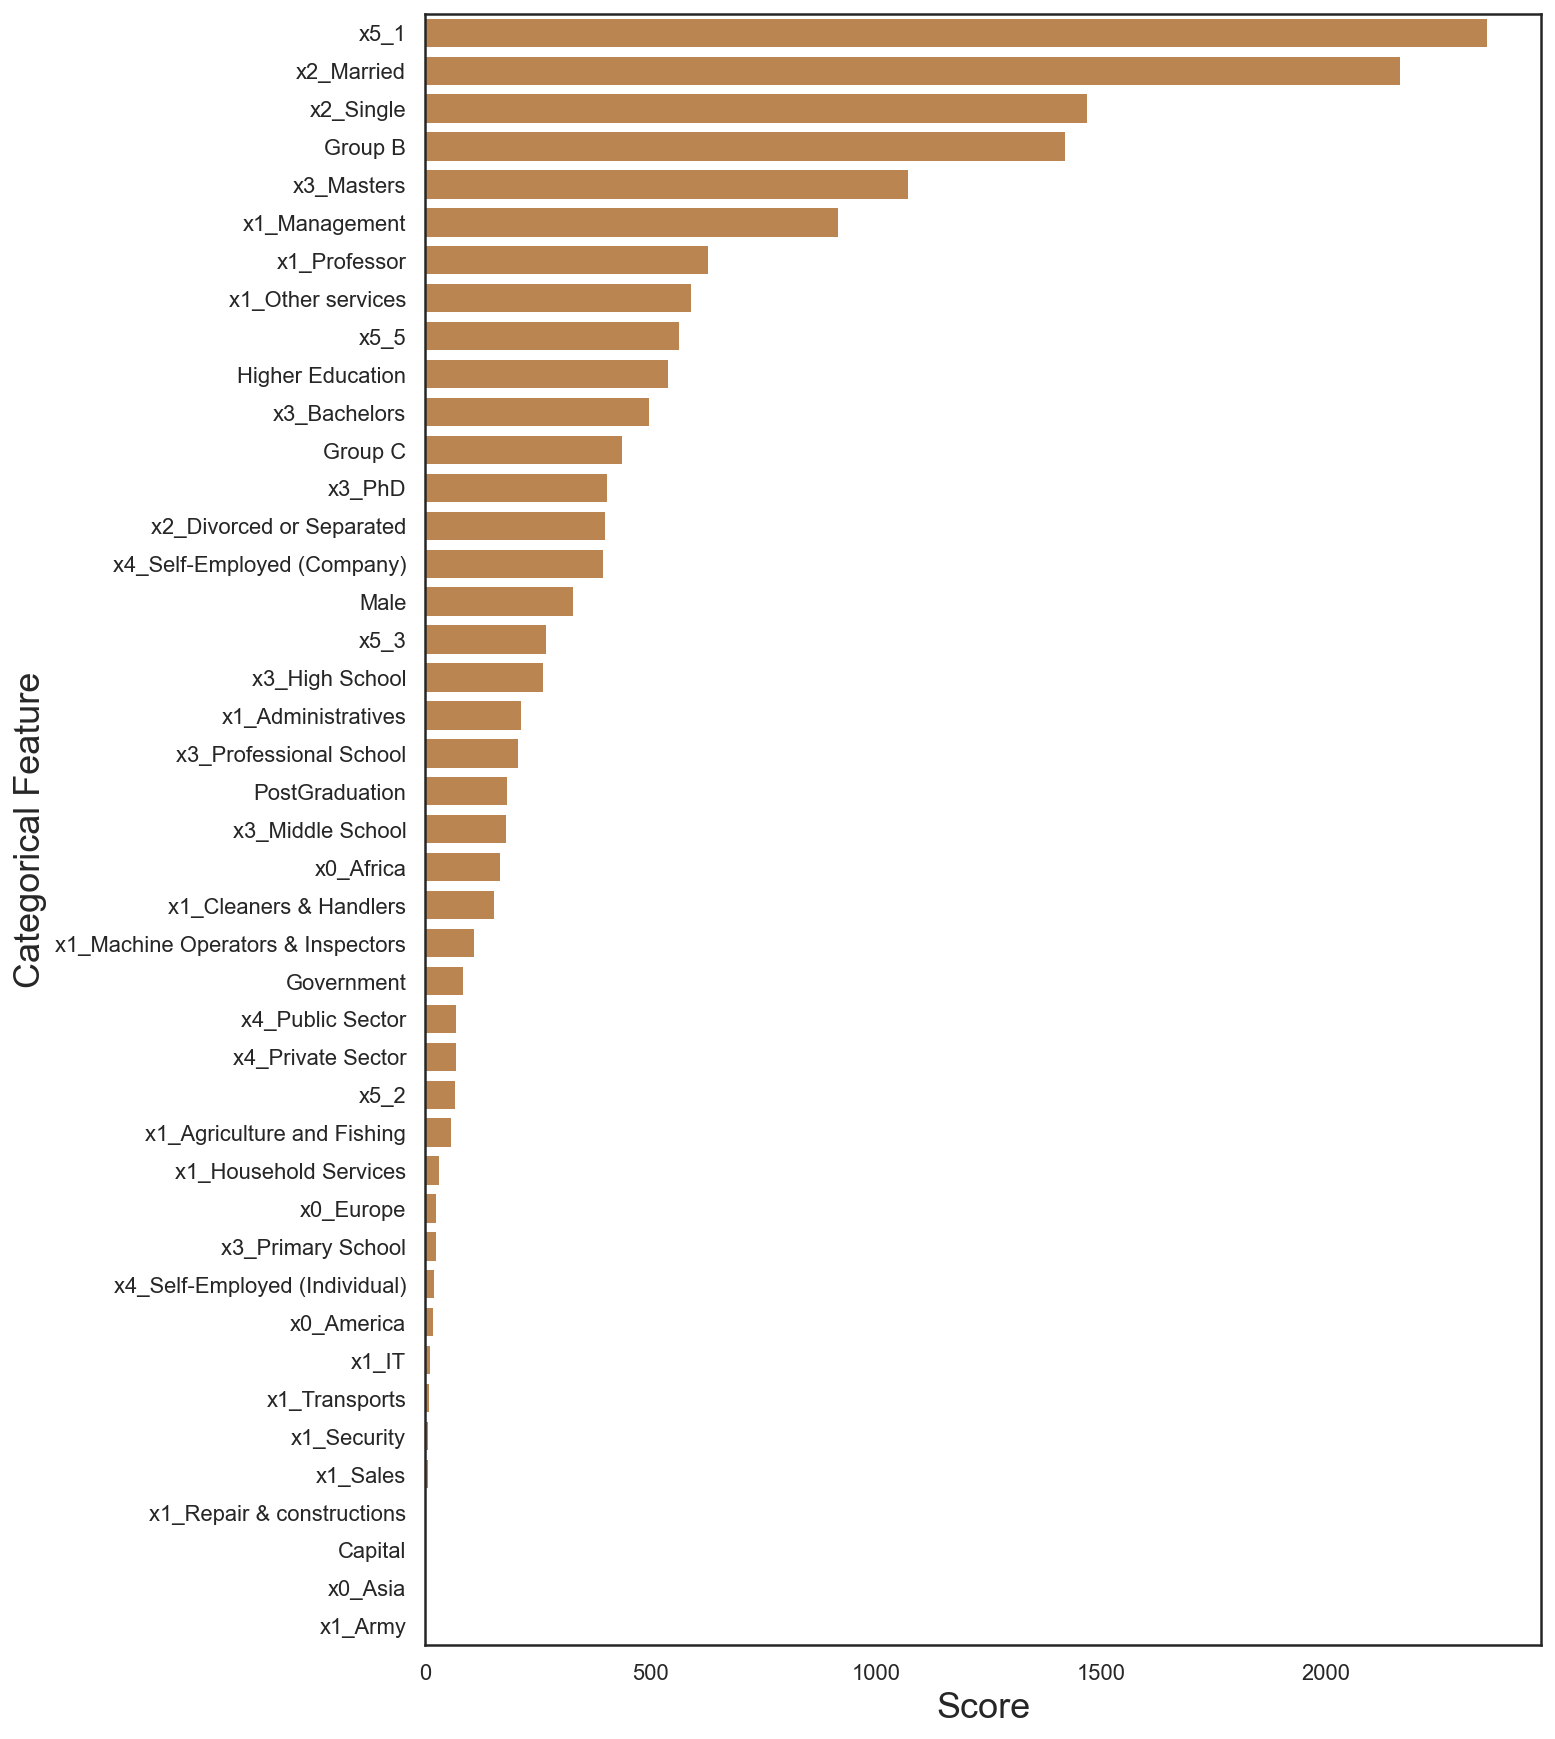

In [127]:
from sklearn.feature_selection import SelectKBest, chi2 # for chi-squared feature selection

X=non_metric_binary
y=target

sf = SelectKBest(chi2, k='all')
sf_fit = sf.fit(X, y)

#for i in range(len(sf_fit.scores_)):
#    print(' %s: %f' % (X.columns[i], sf_fit.scores_[i]))
    
# plot the scores
datset = pd.DataFrame()
datset['feature'] = X.columns[ range(len(sf_fit.scores_))]
datset['scores'] = sf_fit.scores_
datset = datset.sort_values(by='scores', ascending=False)

plt.figure(figsize=(10,15))
sns.barplot(datset['scores'], datset['feature'], color='peru')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()

#valores mais altos= maior importancia/relevancia p a variavel dependente

In [128]:
#MI
from sklearn.feature_selection import mutual_info_classif

feat = []
mi = []

for i in non_metric_binary.columns:
    feat.append(i)
    
    a = np.array(non_metric_binary[i])
    b = np.array(target)

    #mutual information of 0.69, expressed in nats
    mi.append(mutual_info_classif(a.reshape(-1,1), b, discrete_features = True)[0])

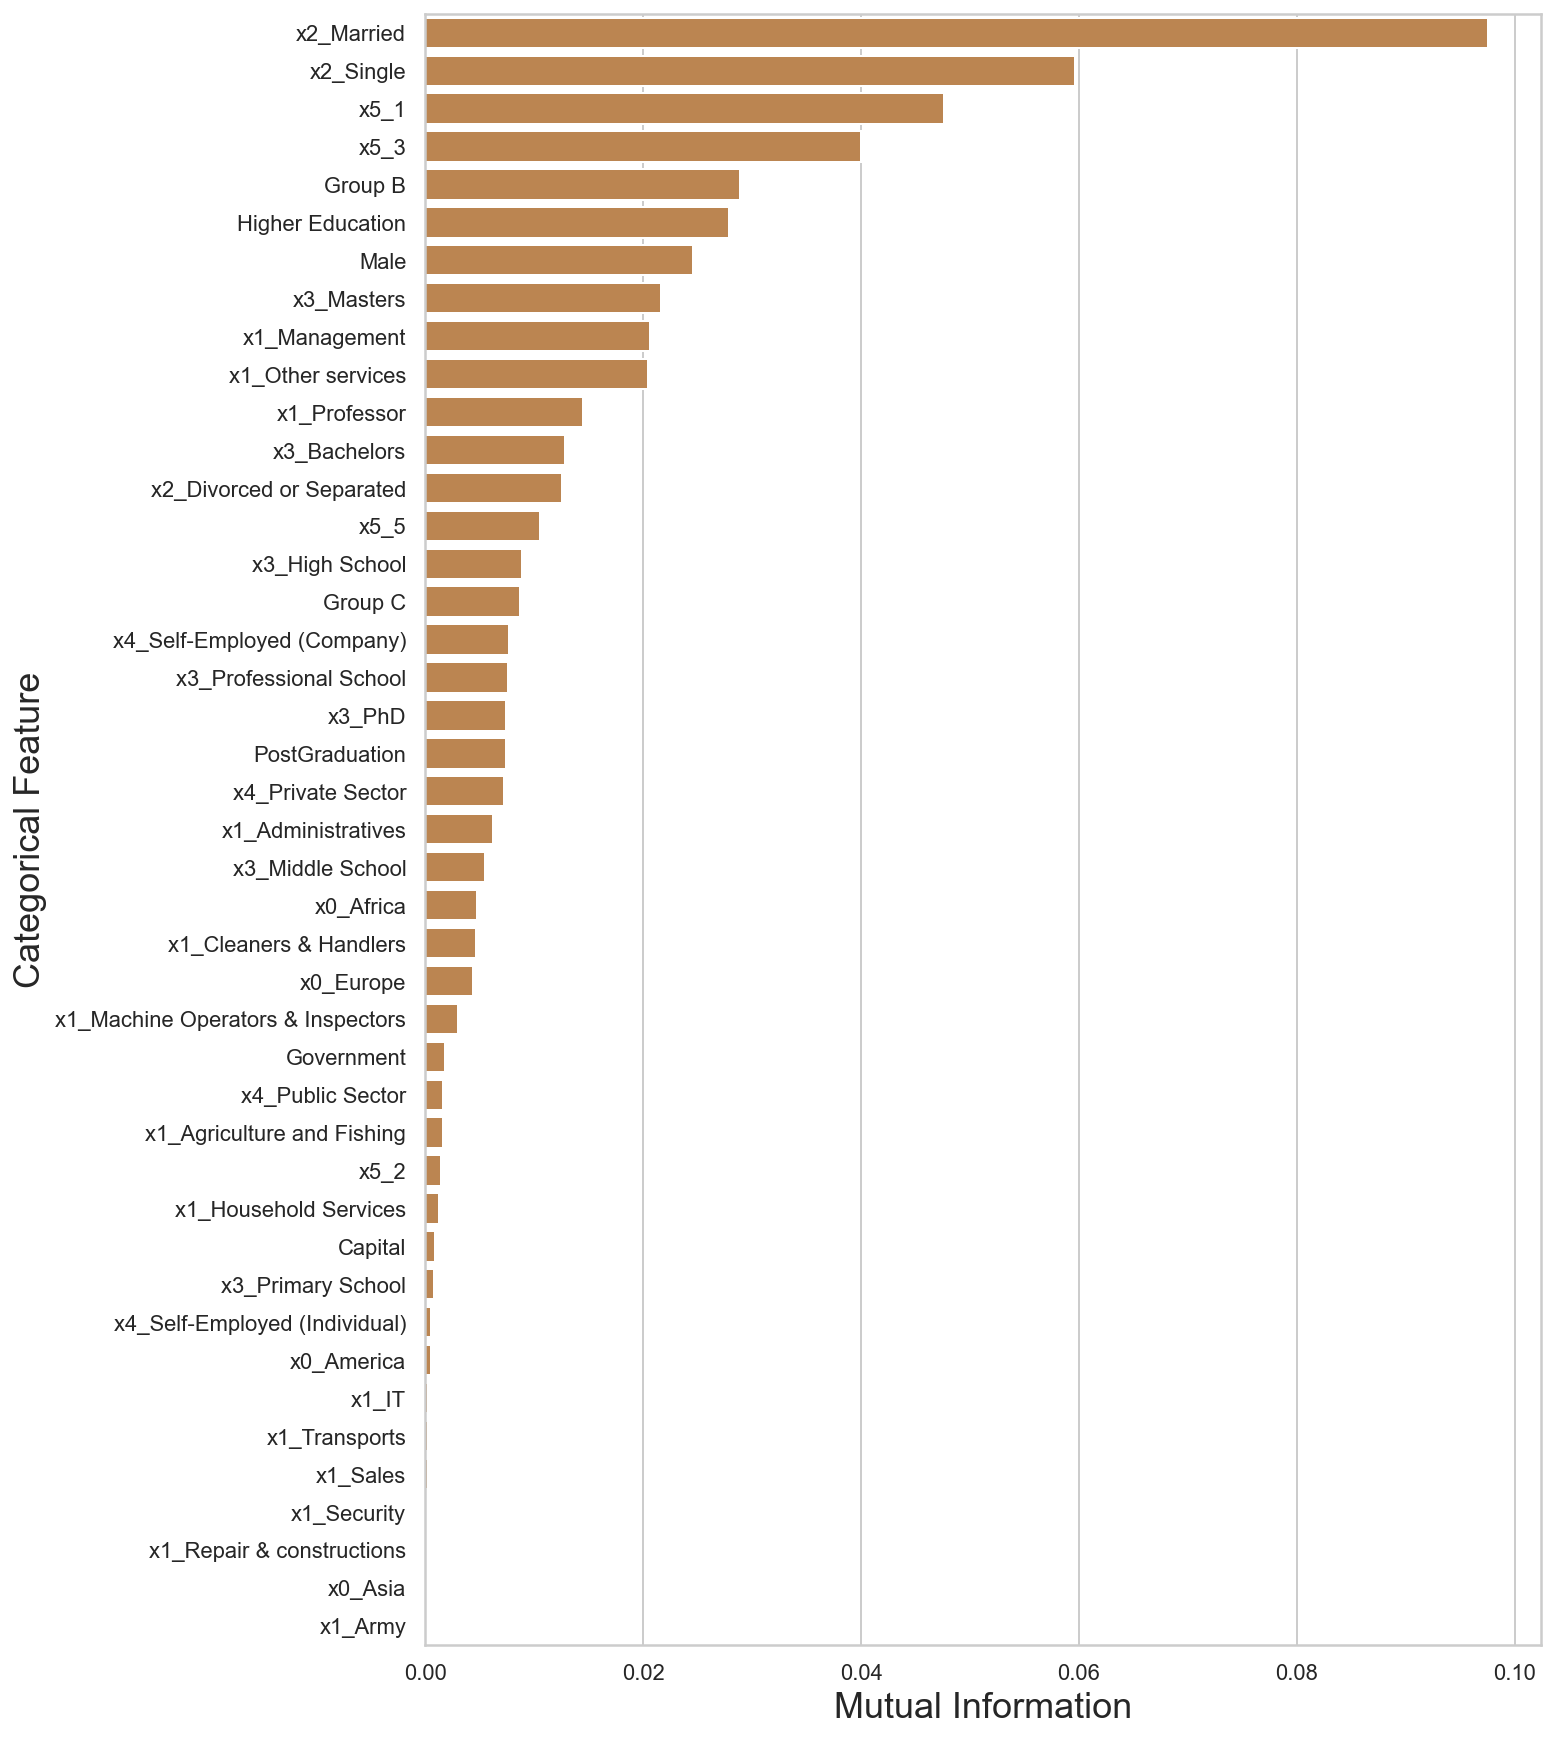

In [129]:
# plot the MI
feat_mi=pd.DataFrame([feat, mi]).T.sort_values(by=1, ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,15))
sns.barplot(x=1, y=0, data=feat_mi, color='peru')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Mutual Information', fontsize=18)
plt.show()

### Mutual Info among binary variables

In [130]:
non_metric_selected = non_metric_binary[['Male', 'Higher Education', 'Group B', 'x1_Management', 'x1_Professor', 'x2_Married', 'x2_Single', 'x3_Bachelors', 'x3_Masters', 'x5_1', 'x5_3', 'x5_5']]

In [131]:
from sklearn.metrics.cluster import normalized_mutual_info_score

print('Normalized mutual information between binary variables (0-1):\n')
for i in non_metric_selected.columns:
    for j in non_metric_selected.columns:
        normal_mi = round(normalized_mutual_info_score(non_metric_selected[i], non_metric_selected[j]), 3)
        
        if i == j: #equals to 1
            pass
        
        elif normal_mi > 0.5:
            print(i, 'and', j, ':', normal_mi)
            
#x3_3 was selected more times than Group B, so we will keep Group x3_3:
non_metric_selected.drop(columns='Group B', inplace=True)

Normalized mutual information between binary variables (0-1):

Group B and x5_3 : 0.594
x5_3 and Group B : 0.594


### Mixing numerical and categorical variables on a Forward and a Backward Feature Selection

In [132]:
stand_metric.drop(columns=['Working Hours per week', 'Money / YE', 'Log 10 of Money Received', 'Log 10 of Ticket Price'], inplace=True)

In [133]:
all_selected_variables = pd.concat([non_metric_selected, stand_metric], axis=1)

In [134]:
all_selected_variables

Male  Higher Education  x1_Management  x1_Professor  x2_Married  \
CITIZEN_ID                                                                    
12486          1                 1              0             0           1   
12487          1                 0              0             0           1   
12488          1                 0              0             0           1   
12489          1                 0              0             0           1   
12490          1                 1              0             1           0   
...          ...               ...            ...           ...         ...   
34881          0                 0              0             0           0   
34882          1                 0              0             0           0   
34883          0                 1              0             1           0   
34884          1                 1              0             0           0   
34885          1                 1              0             0           0   

            x2_Single  x3_Bachelors  x3_Masters  x5_1  x5_3  x5_5  \
CITIZEN_ID                                                          
12486               0             0           0     0     0     0   
12487               0             0           0     0     1     0   
12488               0             0           0     0     0     0   
12489               0             0           0     0     0     0   
12490               1             0           0     0     1     0   
...               ...           ...         ...   ...   ...   ...   
34881               0             0           0     0     1     0   
34882               1             0           0     0     1     0   
34883               1             0           1     0     0     0   
34884               1             1           0     0     1     0   
34885               1             0           0     0     1     0   

            Years of Education  Money Received  Ticket Price       Age  \
CITIZEN_ID                                                               
12486                 0.619048        0.000000      0.424225  0.383562   
12487                 0.571429        0.000000      0.000000  0.342466   
12488                 0.571429        0.000000      0.433184  0.301370   
12489                 0.523810        0.043862      0.000000  0.630137   
12490                 1.000000        0.000000      0.000000  0.219178   
...                        ...             ...           ...       ...   
34881                 0.571429        0.000000      0.000000  0.109589   
34882                 0.571429        0.000000      0.000000  0.082192   
34883                 0.809524        0.021740      0.000000  0.123288   
34884                 0.761905        0.000000      0.000000  0.273973   
34885                 0.619048        0.000000      0.000000  0.068493   

            Working hours * Years of Education  
CITIZEN_ID                                      
12486                                 0.250120  
12487                                 0.230880  
12488                                 0.265512  
12489                                 0.195767  
12490                                 0.454545  
...                                        ...  
34881                                 0.230880  
34882                                 0.202020  
34883                                 0.327080  
34884                                 0.692641  
34885                                 0.250120  

[22400 rows x 16 columns]

In [135]:
model = LogisticRegression()

In [136]:
#Forward:

In [137]:
forward = SFS(model, k_features=16, forward=True, scoring="accuracy", cv = None) #floating=False

forward.fit(all_selected_variables, target)

SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          k_features=16, scoring='accuracy')

In [138]:
forward_table = pd.DataFrame.from_dict(forward.get_metric_dict()).T.drop(columns=['cv_scores', 'ci_bound', 'std_dev', 'std_err'])
forward_table

feature_idx avg_score  \
1                                               (12,)  0.803259   
2                                            (12, 13)  0.816741   
3                                        (10, 12, 13)  0.811652   
4                                     (5, 10, 12, 13)  0.812054   
5                                 (5, 10, 11, 12, 13)  0.818304   
6                              (4, 5, 10, 11, 12, 13)  0.835179   
7                           (2, 4, 5, 10, 11, 12, 13)  0.838973   
8                        (2, 4, 5, 8, 10, 11, 12, 13)  0.840268   
9                    (2, 4, 5, 8, 10, 11, 12, 13, 14)  0.842098   
10                (2, 4, 5, 8, 9, 10, 11, 12, 13, 14)  0.842589   
11            (2, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15)  0.841875   
12         (2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15)  0.842589   
13      (0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15)  0.843527   
14   (0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15)  0.843214   
15  (0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14...  0.843348   
16  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.842946   

                                        feature_names  
1                                   (Money Received,)  
2                      (Money Received, Ticket Price)  
3                (x5_5, Money Received, Ticket Price)  
4     (x2_Single, x5_5, Money Received, Ticket Price)  
5   (x2_Single, x5_5, Years of Education, Money Re...  
6   (x2_Married, x2_Single, x5_5, Years of Educati...  
7   (x1_Management, x2_Married, x2_Single, x5_5, Y...  
8   (x1_Management, x2_Married, x2_Single, x5_1, x...  
9   (x1_Management, x2_Married, x2_Single, x5_1, x...  
10  (x1_Management, x2_Married, x2_Single, x5_1, x...  
11  (x1_Management, x2_Married, x2_Single, x5_1, x...  
12  (x1_Management, x1_Professor, x2_Married, x2_S...  
13  (Male, x1_Management, x1_Professor, x2_Married...  
14  (Male, Higher Education, x1_Management, x1_Pro...  
15  (Male, Higher Education, x1_Management, x1_Pro...  
16  (Male, Higher Education, x1_Management, x1_Pro...

In [139]:
forward_table_max = forward_table['avg_score'].max()
forward_table_max

0.8435267857142857

In [140]:
forward_table[forward_table['avg_score']==forward_table_max]['feature_names'].values

array([('Male', 'x1_Management', 'x1_Professor', 'x2_Married', 'x2_Single', 'x5_1', 'x5_3', 'x5_5', 'Years of Education', 'Money Received', 'Ticket Price', 'Age', 'Working hours * Years of Education')],
      dtype=object)

In [141]:
#Backward:

In [142]:
backward = SFS(model, k_features=1, forward=False, scoring="accuracy", cv = None) #floating=False

backward.fit(all_selected_variables, target)

SequentialFeatureSelector(cv=None, estimator=LogisticRegression(),
                          forward=False, scoring='accuracy')

In [143]:
backward_table = pd.DataFrame.from_dict(backward.get_metric_dict()).T.drop(columns=['cv_scores', 'ci_bound', 'std_dev', 'std_err'])
backward_table

feature_idx avg_score  \
16  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.842946   
15  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14,...  0.843884   
14    (0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15)  0.844018   
13       (0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15)  0.843973   
12          (1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15)  0.843795   
11             (1, 2, 3, 4, 8, 9, 11, 12, 13, 14, 15)  0.843929   
10                 (1, 2, 3, 4, 8, 9, 11, 13, 14, 15)  0.843393   
9                      (1, 2, 3, 4, 8, 9, 11, 14, 15)  0.842768   
8                          (1, 2, 3, 4, 8, 9, 11, 15)  0.842455   
7                             (2, 3, 4, 8, 9, 11, 15)  0.841875   
6                                (2, 4, 8, 9, 11, 15)  0.840804   
5                                    (2, 4, 8, 9, 11)  0.840313   
4                                       (4, 8, 9, 11)  0.838661   
3                                          (4, 8, 11)  0.834107   
2                                             (4, 11)  0.818259   
1                                               (11,)  0.776652   

                                        feature_names  
16  (Male, Higher Education, x1_Management, x1_Pro...  
15  (Male, Higher Education, x1_Management, x1_Pro...  
14  (Male, Higher Education, x1_Management, x1_Pro...  
13  (Male, Higher Education, x1_Management, x1_Pro...  
12  (Higher Education, x1_Management, x1_Professor...  
11  (Higher Education, x1_Management, x1_Professor...  
10  (Higher Education, x1_Management, x1_Professor...  
9   (Higher Education, x1_Management, x1_Professor...  
8   (Higher Education, x1_Management, x1_Professor...  
7   (x1_Management, x1_Professor, x2_Married, x5_1...  
6   (x1_Management, x2_Married, x5_1, x5_3, Years ...  
5   (x1_Management, x2_Married, x5_1, x5_3, Years ...  
4        (x2_Married, x5_1, x5_3, Years of Education)  
3              (x2_Married, x5_1, Years of Education)  
2                    (x2_Married, Years of Education)  
1                               (Years of Education,)

In [144]:
backward_table_max = backward_table['avg_score'].max()
backward_table_max

0.8440178571428572

In [145]:
backward_table[backward_table['avg_score']==backward_table_max]['feature_names'].values

array([('Male', 'Higher Education', 'x1_Management', 'x1_Professor', 'x2_Married', 'x2_Single', 'x3_Masters', 'x5_1', 'x5_3', 'Years of Education', 'Money Received', 'Ticket Price', 'Age', 'Working hours * Years of Education')],
      dtype=object)

In [146]:
#Mantaining the variables that appear on both the forward and backward selections:

In [147]:
non_metric_bf = non_metric_selected.drop(columns=['Higher Education', 'x3_Bachelors', 'x3_Masters', 'x5_5'])

In [148]:
all_selected_variables.drop(columns=['Higher Education', 'x3_Bachelors', 'x3_Masters', 'x5_5'], inplace=True)

### Checking point biserial among the selected numerical and categorical variables

In [149]:
from scipy.stats import pointbiserialr

print('Point biserial between binary and metric variables:\n')
for i in non_metric_bf.columns:
    for j in stand_metric.columns:
        pb = pointbiserialr(non_metric_bf[i], stand_metric[j])
        
        if abs(pb[0]) > 0.5:
            print(i, 'and', j, ':', round(pb[0], 3))

Point biserial between binary and metric variables:

x2_Single and Age : -0.536
x5_1 and Money Received : 0.619
x5_3 and Ticket Price : -0.567


## Data Partition

In [150]:
#o que acham? kfold vale a pena, fazer as funções e assim?

In [151]:
X_train, X_val, y_train, y_val = train_test_split(all_selected_variables,
                                                  target,
                                                  test_size = 0.3,
                                                  random_state = 42,
                                                  shuffle=True,
                                                  stratify=target)

# Predictive Modelling

## Decision Trees

In [152]:
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.model_selection import KFold
from sklearn import tree

In [ ]:
#X = all_selected_variables

In [ ]:
# def avg_score(model):
#     # apply kfold
#     kf = KFold(n_splits=10)
#     # create lists to store the results from the different models 
#     score_train = []
#     score_val = []
#     timer = []
#     n_iter = []
#     for train_index, val_index in kf.split(X):
#         # get the indexes of the observations assigned for each partition
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]
#         # start counting time
#         begin = time.perf_counter()
#         # fit the model to the data
#         model.fit(X_train, y_train)
#         # finish counting time
#         end = time.perf_counter()
#         # check the mean accuracy for the train
#         value_train = model.score(X_train, y_train)
#         # check the mean accuracy for the test
#         value_val = model.score(X_val,y_val)
#         # append the accuracies, the time and the number of iterations in the corresponding list
#         score_train.append(value_train)
#         score_val.append(value_val)
#         timer.append(end-begin)
#         n_iter.append(model.n_iter_)
#     # calculate the average and the std for each measure (accuracy, time and number of iterations)
#     avg_time = round(np.mean(timer),3)
#     avg_train = round(np.mean(score_train),3)
#     avg_val = round(np.mean(score_val),3)
#     std_time = round(np.std(timer),2)
#     std_train = round(np.std(score_train),2)
#     std_val = round(np.std(score_val),2)
#     avg_iter = round(np.mean(n_iter),1)
#     std_iter = round(np.std(n_iter),1)
    
#     return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
# str(avg_val) + '+/-' + str(std_val), str(avg_iter) + '+/-' + str(std_iter)

In [153]:
def avg_score(model):
    # apply kfold
    kf = KFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    for train_index, test_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_test,y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

In [154]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

def plot_tree(model_tree):
    dot_data = export_graphviz(model_tree,
                               feature_names=None,  
                               class_names=["Income lower or equal to avg", "Income higher than avg"],
                               filled=True)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('"20,20"')
    return graphviz.Source(pydot_graph.to_string())

In [155]:
def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1
    return df

In [239]:
#AUC
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

#MUDAR isto de test para validation

def calculate_AUC(interval, x_train, x_test, y_train, y_test, parameter, max_depth = None):
    train_results = []
    test_results = []
    for value in interval:
        if (parameter == 'max_depth'):          
            dt = DecisionTreeClassifier(max_depth = value, random_state=42)
            dt.fit(x_train, y_train)
        elif (parameter == 'max_features'):  
            dt = DecisionTreeClassifier(max_features = value, max_depth = max_depth, random_state=42)
            dt.fit(x_train, y_train)
        elif (parameter == 'min_samples_split'):  
            dt = DecisionTreeClassifier(min_samples_split = value, max_depth = max_depth, random_state=42)
            dt.fit(x_train, y_train)
        elif (parameter == 'min_samples_leaf'):  
            dt = DecisionTreeClassifier(min_samples_leaf = value, max_depth = max_depth, random_state=42)
            dt.fit(x_train, y_train)
        elif (parameter == 'min_weight_fraction_leaf'):  
            dt = DecisionTreeClassifier(min_weight_fraction_leaf = value, max_depth = max_depth, random_state=42)
            dt.fit(x_train, y_train)
        elif (parameter == 'min_impurity_decrease'):  
            dt = DecisionTreeClassifier(min_impurity_decrease = value, max_depth = max_depth, random_state=42)
            dt.fit(x_train, y_train)
        train_pred = dt.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous train results
        train_results.append(roc_auc)
        y_pred = dt.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # Add auc score to previous test results
        test_results.append(roc_auc)
    value_train = train_results.index(max(train_results))
    value_test = test_results.index(max(test_results))
    print('The best train value is ',interval[value_train])
    print('The best test value is ',interval[value_test])
    

    import matplotlib.pyplot as plt
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(interval, train_results, 'b', label="Train AUC")
    line2, = plt.plot(interval, test_results, 'r', label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("AUC score")
    plt.xlabel(str(parameter))
    plt.show()

The best train value is  15.0
The best test value is  10.0


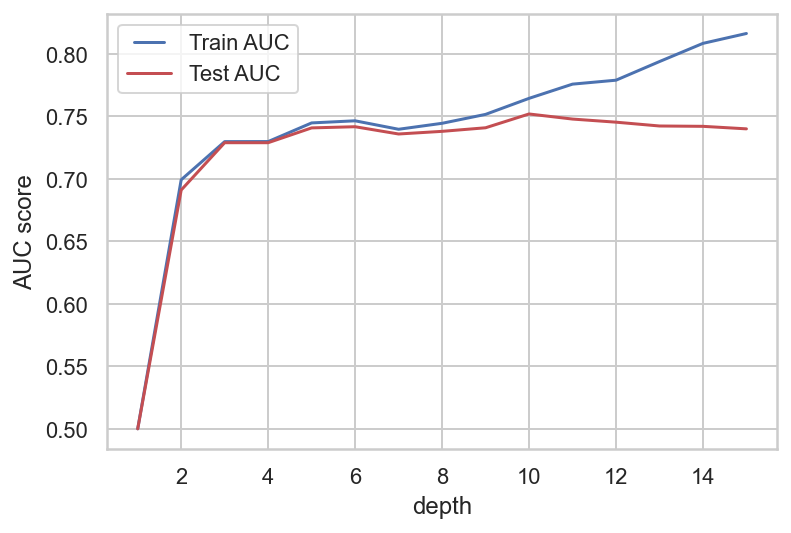

In [224]:
max_depths = np.linspace(1, 15, 15, endpoint=True)  
calculate_AUC(max_depths, X_train, X_val, y_train, y_val, 'max_depth')

The best train value is  5
The best test value is  7


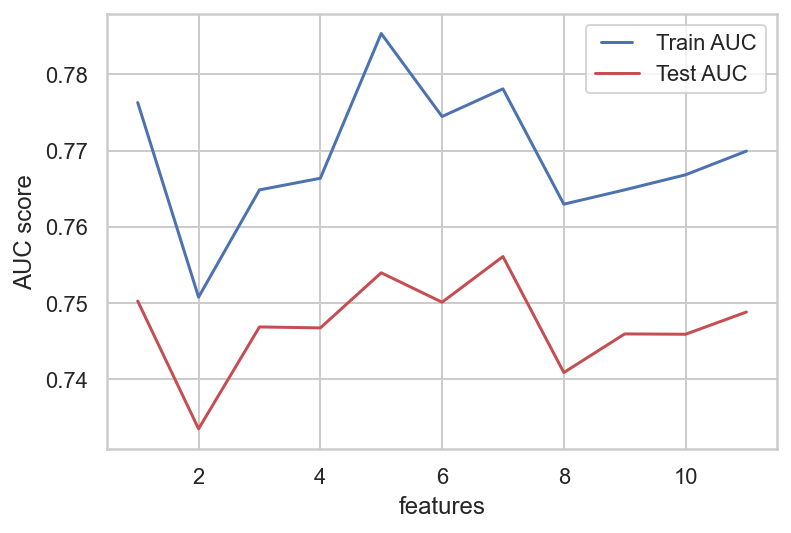

In [232]:
max_features = list(range(1,len(X_train.columns)))
calculate_AUC(max_features, X_train, X_val, y_train, y_val,'max_features', 10)

The best train value is  10
The best test value is  17


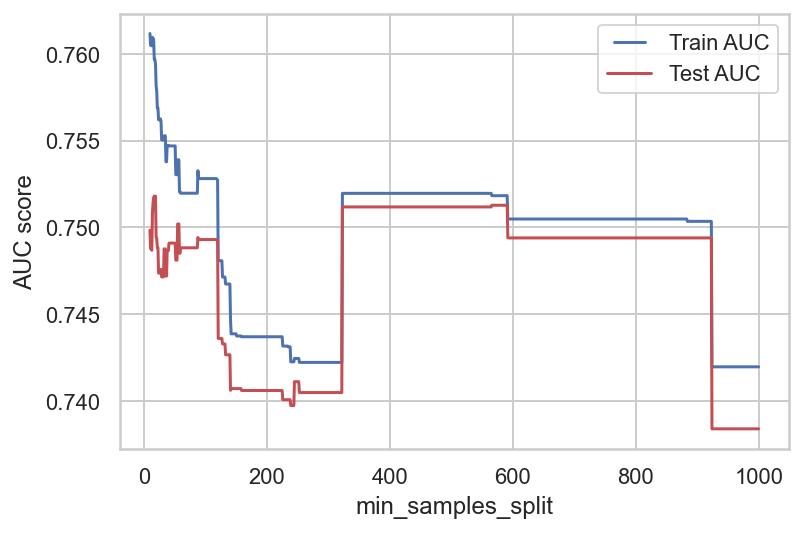

In [242]:
min_samples_split = list(range(10,1001))
calculate_AUC(min_samples_split, X_train, X_val, y_train, y_val,'min_samples_split', 10)

The best train value is  55
The best test value is  38


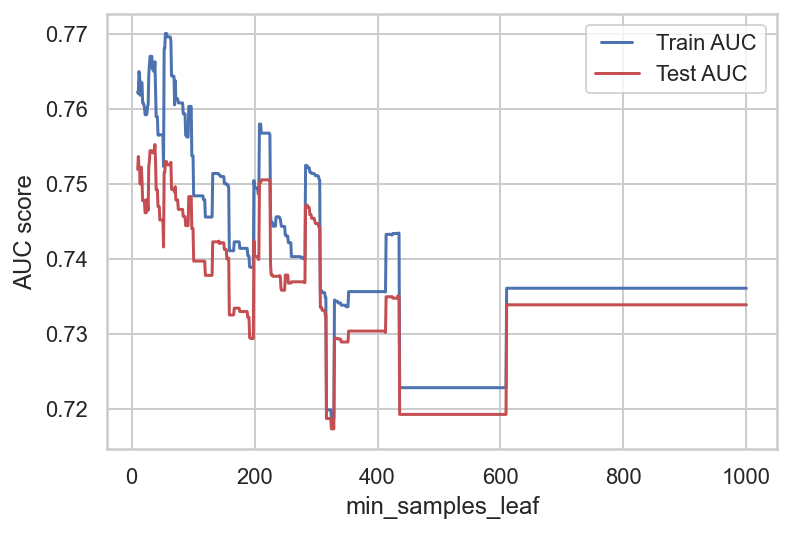

In [243]:
min_samples_leaf = list(range(10,1001))
calculate_AUC(min_samples_leaf, X_train, X_val, y_train, y_val,'min_samples_leaf', 10)

The best train value is  0.004016064257028112
The best test value is  0.002008032128514056


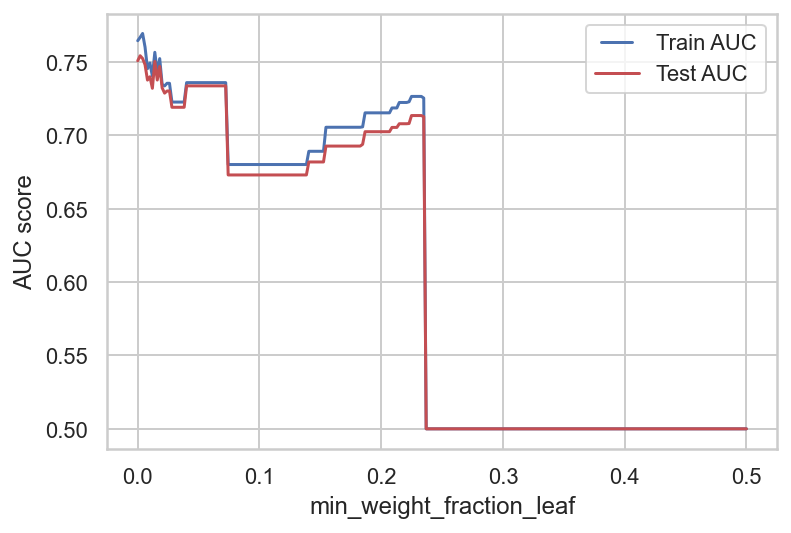

In [250]:
min_weight_fraction_leaf = np.linspace(0, 0.5, 250, endpoint=True)
calculate_AUC(min_weight_fraction_leaf, X_train, X_val, y_train, y_val,'min_weight_fraction_leaf', 10)

The best train value is  0.0
The best test value is  0.0001002004008016032


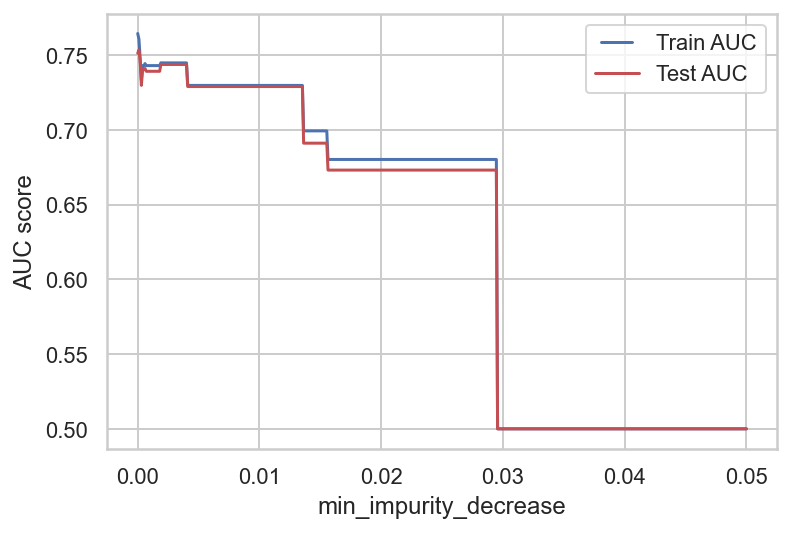

In [252]:
min_impurity_decrease = np.linspace(0, 0.05, 500, endpoint=True)
calculate_AUC(min_impurity_decrease, X_train, X_val, y_train, y_val,'min_impurity_decrease', 10)

In [253]:
#ccp_alpha
dt_alpha = DecisionTreeClassifier(random_state=42)
path = dt_alpha.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

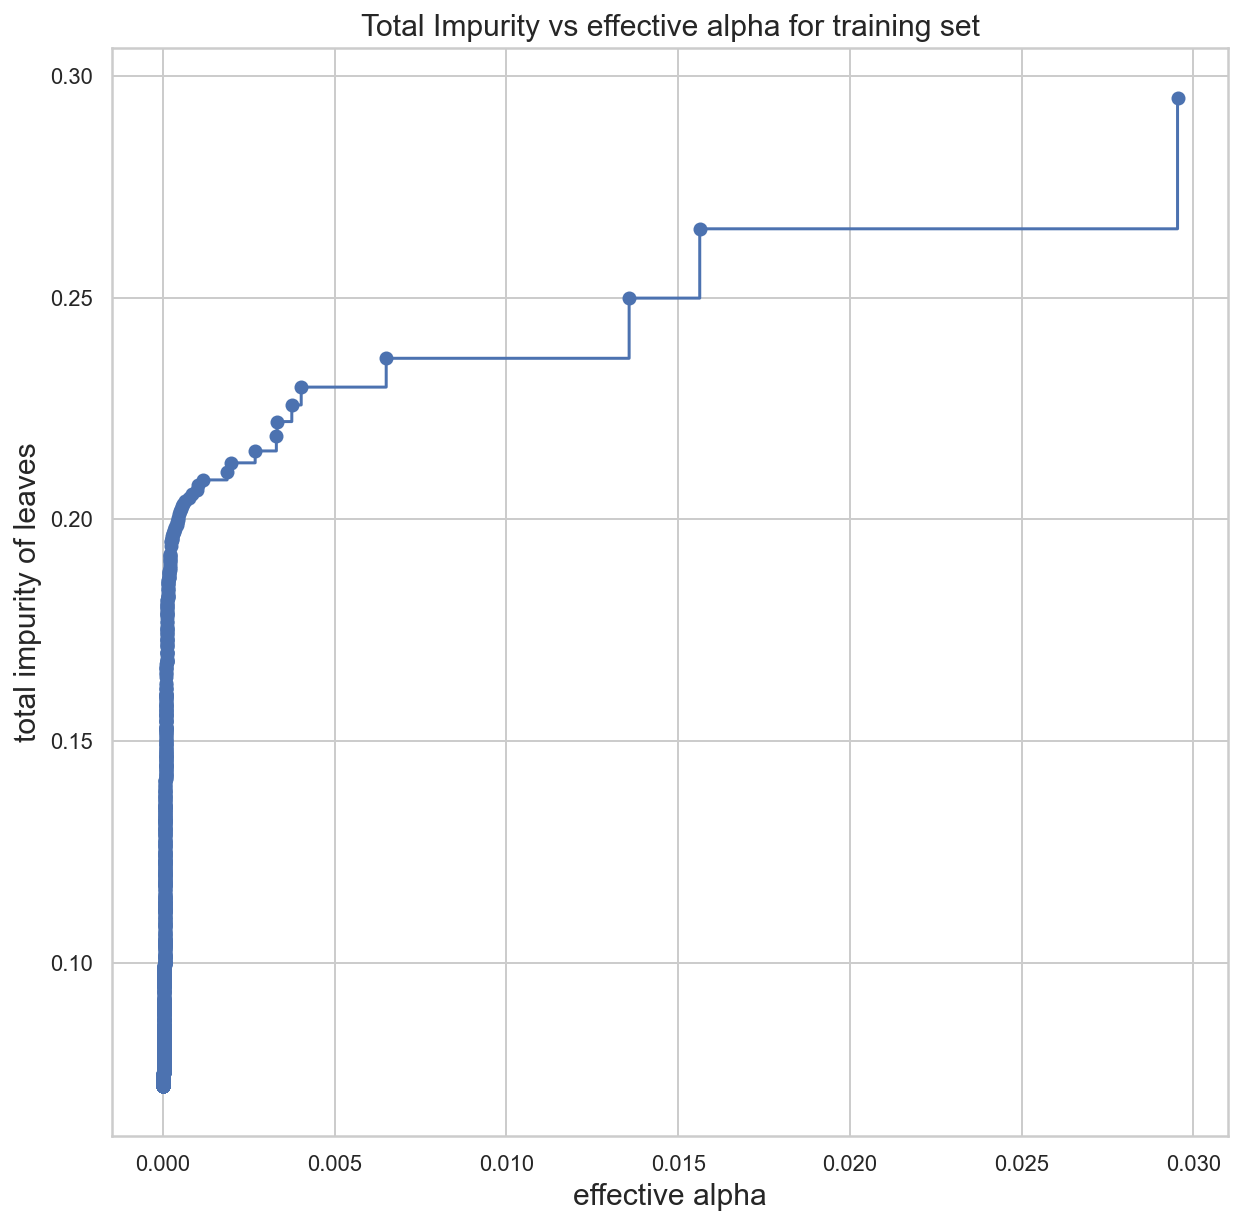

In [256]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha", fontsize=15)
ax.set_ylabel("total impurity of leaves", fontsize=15)
ax.set_title("Total Impurity vs effective alpha for training set", fontsize=15)

In [272]:
#a função abaixo não aceitava ccp_alphas menores que 0
ccp_alphas=ccp_alphas[ccp_alphas>0]

In [273]:
trees = []
for ccp_alpha in ccp_alphas:
    dt_alpha = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    trees.append(dt_alpha)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(trees[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0667089762462657


In [274]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

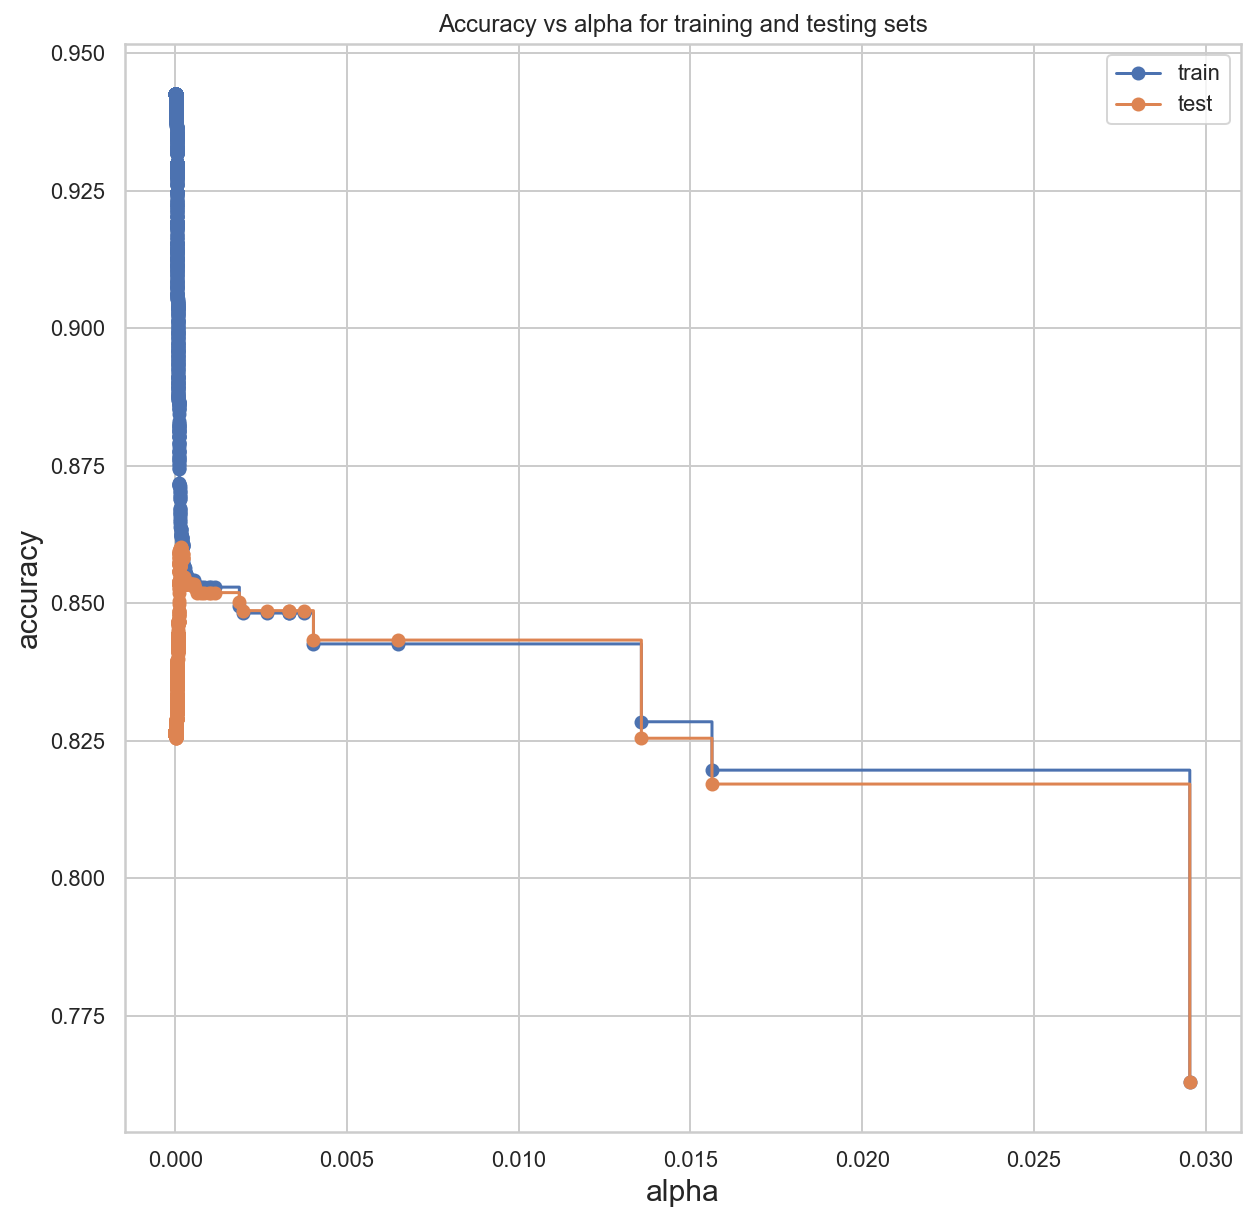

In [275]:
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_val, y_val) for tree in trees]

fig, ax = plt.subplots(figsize = (10,10))
ax.set_xlabel("alpha", fontsize=15)
ax.set_ylabel("accuracy", fontsize=15)
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [278]:
index_best_model = np.argmax(test_scores)
best_model = trees[index_best_model]
print('ccp_alpha of best model: ',trees[index_best_model])
print('_____________________________________________________________')
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Validation accuracy of best model: ',best_model.score(X_val, y_val))

ccp_alpha of best model:  DecisionTreeClassifier(ccp_alpha=0.00015941340116873795, random_state=42)
_____________________________________________________________
Training accuracy of best model:  0.8626913265306122
Validation accuracy of best model:  0.8602678571428571


In [225]:
#Now, coding 4 decision trees:
dt_basic = DecisionTreeClassifier().fit(X_train, y_train)
dt_1 = DecisionTreeClassifier(min_samples_leaf=38).fit(X_train, y_train)
dt_2 = DecisionTreeClassifier(ccp_alpha=0.000159).fit(X_train, y_train)
dt_3 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=38, min_samples_split=17).fit(X_train, y_train)
dt_4 = DecisionTreeClassifier(max_features=10, min_samples_split=17).fit(X_train, y_train)

In [226]:
df = pd.DataFrame(columns = ['Time','Train','Validation'], index = ['dt_basic','dt_1', 'dt_2', 'dt_3', 'dt_4'])
show_results(df, dt_basic, dt_1, dt_2, dt_3, dt_4)

Time        Train    Validation
dt_basic  0.157+/-0.03  0.876+/-0.0   0.83+/-0.01
dt_1       0.19+/-0.03  0.846+/-0.0    0.84+/-0.0
dt_2      0.305+/-0.04  0.846+/-0.0  0.838+/-0.01
dt_3       0.17+/-0.04  0.845+/-0.0  0.838+/-0.01
dt_4      0.071+/-0.03   0.86+/-0.0  0.835+/-0.01

In [ ]:
#changing the threshold improves or not the accuracy......?
from sklearn.metrics import accuracy_score

threshold = 0.4

predicted_proba = dt_1.predict_proba(X_val)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_val, predicted)
accuracy

In [ ]:
prob_model1 = dt_1.predict_proba(X_val)
prob_model2 = dt_2.predict_proba(X_val)
prob_model3 = dt_3.predict_proba(X_val)
prob_model4 = dt_4.predict_proba(X_val)

In [ ]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_val, prob_model1[:, 1])
fpr_2, tpr_2, thresholds_2 = roc_curve(y_val, prob_model2[:, 1])
fpr_3, tpr_3, thresholds_3 = roc_curve(y_val, prob_model3[:, 1])
fpr_4, tpr_4, thresholds_4 = roc_curve(y_val, prob_model4[:, 1])

In [ ]:
plt.plot(fpr_1, tpr_1,label="ROC Curve model 1")
plt.plot(fpr_2, tpr_2, label="ROC Curve model 2")
plt.plot(fpr_3, tpr_3, label="ROC Curve model 3")
plt.plot(fpr_4, tpr_4, label="ROC Curve model 4")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [ ]:
# plot_tree(dt_1)
# plot_tree(dt_2)
# plot_tree(dt_3)
# plot_tree(dt_4)

In [ ]:
# dt_1.predict(X_val)
# dt_1.predict_proba(X_val)
# print('The defined three has a depth of ' + str(dt_1.get_depth()) + ', ' + str(dt_1.tree_.node_count) + 
#       ' nodes and a total of ' + str(dt_1.get_n_leaves()) + ' leaves.')

## Random Forests

In [369]:
random = 42

ensemble_clfs = [
    ("RandomForestClassifier, max_features='auto'",
        RandomForestClassifier(oob_score=True,
                               max_features='auto',
                               random_state=random)),
    ("RandomForestClassifier, max_features=10",
        RandomForestClassifier(max_features=10,
                               oob_score=True,
                               random_state=random)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(max_features=None,
                               oob_score=True,
                               random_state=random))
]

In [370]:
from collections import OrderedDict

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175 #225

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

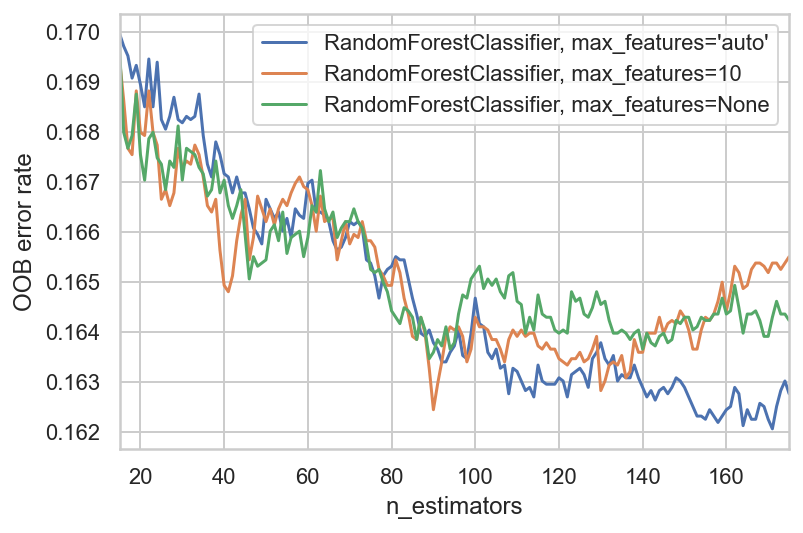

In [371]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [417]:
rf_1 = RandomForestClassifier(n_estimators=170, ccp_alpha=0.000159, max_depth=10, random_state = 42)
rf_2 = RandomForestClassifier(n_estimators=170, ccp_alpha=0.000159, max_depth=10, max_features = 10, random_state = 42)
rf_3 = RandomForestClassifier(n_estimators=170, ccp_alpha=0.000159, max_depth=10, max_samples = 0.7, random_state = 42)

In [418]:
rf_1.fit(X_train, y_train)
rf_2.fit(X_train, y_train)
rf_3.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.000159, max_depth=10, max_samples=0.7,
                       n_estimators=170, random_state=42)

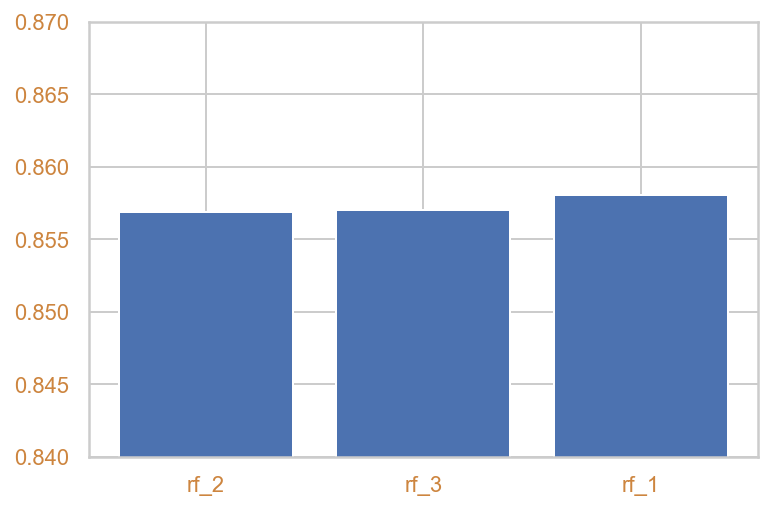

In [419]:
models = ['rf_1', 'rf_2', 'rf_3']

accuracies = [rf_1.score(X_val, y_val), rf_2.score(X_val, y_val), rf_3.score(X_val, y_val)]

data_tuples = list(zip(models,accuracies))

data = pd.DataFrame(data_tuples)
data = data.sort_values(1)

plt.bar(data[0], data[1])
plt.xticks(color='peru')
plt.yticks(color='peru')
plt.ylim(0.84, 0.87)
plt.show()

In [420]:
#highest score
rf_1.score(X_val, y_val)

0.8580357142857142

In [423]:
#changing the threshold does not seem to improve the accuracy of the best random forest!
from sklearn.metrics import accuracy_score

threshold = 0.4

predicted_proba = rf_1.predict_proba(X_val)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_val, predicted)
accuracy

0.8569940476190476

### Logistic Regression

In [231]:
#importing and defining the model
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()

In [232]:
log_model.fit(X_train,y_train) #fit model to our train data

LogisticRegression()

In [233]:
labels_train = log_model.predict(X_train)
log_model.score(X_train, y_train)

0.8422831632653062

In [234]:
#Predict class labels for samples in X
labels_val = log_model.predict(X_val) 
labels_val
#predict values for X_test, ex: p o citizen em X_test [0] estamos a prever y[0]->0

array([0, 0, 1, ..., 0, 1, 0])

In [235]:
pred_prob = log_model.predict_proba(X_val) 
pred_prob 
#o cutoff normalmente é de 0.5, mas as vezes é preferivel considerar menos

array([[0.77539968, 0.22460032],
       [0.98820754, 0.01179246],
       [0.48078694, 0.51921306],
       ...,
       [0.77977821, 0.22022179],
       [0.2111217 , 0.7888783 ],
       [0.92778066, 0.07221934]])

In [236]:
X_train.columns

Index(['Male', 'x1_Management', 'x1_Professor', 'x2_Married', 'x2_Single',
       'x5_1', 'x5_3', 'Years of Education', 'Money Received', 'Ticket Price',
       'Age', 'Working hours * Years of Education'],
      dtype='object')

In [237]:
log_model.coef_
#since we dont have the residuals, we cannot use the OLS, not applied to logistic regression
#c estes valores so conseguimos dizer q se for + a curva é p cima, - para baixo

array([[ 0.20713477,  0.79360677,  0.49667638,  2.15371552, -0.46836093,
         4.25245138, -0.42555478,  4.23855478,  2.37394443,  1.86944684,
         1.59418237,  4.05710623]])

In [238]:
#apagar
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import precision_score #The best value is 1, and the worst value is 0
#from sklearn.metrics import f1_score #F1 score reaches its best value at 1 and worst score at 0

In [239]:
from sklearn.metrics import classification_report, confusion_matrix #confusion_matrix to evaluate the accuracy of a classification
def metrics(y_train, pred_train , y_val, pred_val):
    print('_____________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train)) #true neg and true pos, false positives and false neg
    print('__________________________+_________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

metrics(y_train, labels_train, y_val, labels_val)

#(X_train, X_test, y_train, y_test) + y_pred
#pred p train e test e score p test e train

#ability of the classifier to not label a sample as positive if it is negative
#recall: ability of the classifier to find all the positive samples
#bad model: from all the dataset, what are the ones we are getting right
#f1: weighted harmonic mean of the precision and recall

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     11962
           1       0.73      0.53      0.62      3718

    accuracy                           0.84     15680
   macro avg       0.80      0.74      0.76     15680
weighted avg       0.83      0.84      0.83     15680

[[11225   737]
 [ 1736  1982]]
__________________________+_________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      5127
           1       0.74   

### Gaussian Naive Bayes

In [273]:
from sklearn.naive_bayes import GaussianNB
modelNB = GaussianNB()
#modelNB = GaussianNB(var_smoothing=0.0001) #train score: 0.8126913265306123 & validation score: 0.8175595238095238
modelNB.fit(X = X_train, y = y_train)
labels_train = modelNB.predict(X_train)
labels_val = modelNB.predict(X_val)
modelNB.predict_proba(X_val)

array([[9.99835338e-01, 1.64661721e-04],
       [9.99999637e-01, 3.62999179e-07],
       [8.86520722e-01, 1.13479278e-01],
       ...,
       [9.99964308e-01, 3.56924641e-05],
       [3.86537855e-01, 6.13462145e-01],
       [9.99978886e-01, 2.11137106e-05]])

In [274]:
print("train score:", modelNB.score(X_train, y_train))
print("validation score:",modelNB.score(X_val, y_val))

train score: 0.8126913265306123
validation score: 0.8175595238095238


In [279]:
# Para ver unbalancedness, média e variância para cada 
print(modelNB.class_prior_) #prob 0, prob 1
print(modelNB.class_count_)#n 0, n 1
modelNB.theta_
modelNB.sigma_

[0.76288265 0.23711735]
[11962.  3718.]


array([[2.37079724e-01, 8.11301700e-02, 9.09465126e-02, 2.28229071e-01,
        2.42436912e-01, 9.43653939e-04, 6.79652576e-02, 1.25361533e-02,
        1.40732241e-04, 5.33300858e-03, 3.69148443e-02, 8.46708915e-03],
       [1.30760398e-01, 1.91298868e-01, 1.85968823e-01, 1.23022212e-01,
        6.25112305e-02, 1.17597835e-01, 2.12731681e-01, 1.45583013e-02,
        2.25468996e-02, 1.94364050e-02, 2.11303207e-02, 1.02237087e-02]])

In [276]:
metrics(y_train, labels_train, y_val, labels_val)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     11962
           1       0.70      0.37      0.48      3718

    accuracy                           0.81     15680
   macro avg       0.76      0.66      0.68     15680
weighted avg       0.80      0.81      0.79     15680

[[11370   592]
 [ 2345  1373]]
__________________________+_________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      5127
           1       0.72   

### Neural Networks

In [280]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
model.fit(X_train, y_train)
labels_train = model.predict(X_train)
labels_val = model.predict(X_val)

In [281]:
metrics(y_train, labels_train, y_val, labels_val)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     11962
           1       0.72      0.63      0.67      3718

    accuracy                           0.85     15680
   macro avg       0.80      0.78      0.79     15680
weighted avg       0.85      0.85      0.85     15680

[[11032   930]
 [ 1373  2345]]
__________________________+_________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      5127
           1       0.71   

In [289]:
model = MLPClassifier(hidden_layer_sizes = (3), verbose = True)

In [290]:
model.fit(X_train, y_train)

Iteration 1, loss = 0.56774204
Iteration 2, loss = 0.54966472
Iteration 3, loss = 0.53287155
Iteration 4, loss = 0.51765071
Iteration 5, loss = 0.49983151
Iteration 6, loss = 0.46938016
Iteration 7, loss = 0.43739918
Iteration 8, loss = 0.41433711
Iteration 9, loss = 0.39924253
Iteration 10, loss = 0.38935480
Iteration 11, loss = 0.38267177
Iteration 12, loss = 0.37802512
Iteration 13, loss = 0.37480653
Iteration 14, loss = 0.37157731
Iteration 15, loss = 0.36605849
Iteration 16, loss = 0.36301568
Iteration 17, loss = 0.36058620
Iteration 18, loss = 0.35875289
Iteration 19, loss = 0.35684799
Iteration 20, loss = 0.35543422
Iteration 21, loss = 0.35430935
Iteration 22, loss = 0.35306314
Iteration 23, loss = 0.35172916
Iteration 24, loss = 0.35058572
Iteration 25, loss = 0.34973205
Iteration 26, loss = 0.34909097
Iteration 27, loss = 0.34803020
Iteration 28, loss = 0.34730261
Iteration 29, loss = 0.34657454
Iteration 30, loss = 0.34599418
Iteration 31, loss = 0.34517387
Iteration 32, los

MLPClassifier(hidden_layer_sizes=3, verbose=10)

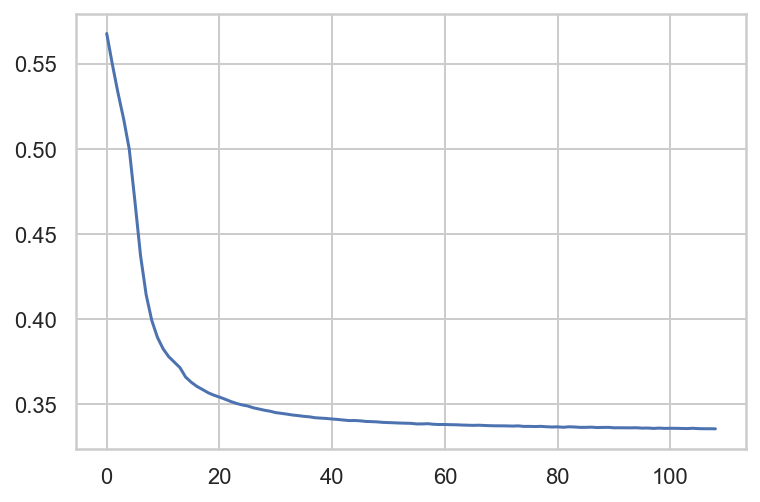

In [291]:
losses = model.loss_curve_
iterations = range(model.n_iter_)
sns.lineplot(iterations, losses)

In [292]:
model.loss_

0.33567077836660986

In [294]:
#Get the weight matrix by calling the attribute coefs_:
#(TENHO A INTERPRETAÇÃO DESTA MATRIZ NO CADERNO)
model.coefs_

[array([[ 0.49814275, -0.02470779,  1.06901257],
        [ 0.66801846, -0.27297763,  0.18267753],
        [ 0.53637824, -0.07620779,  0.06275272],
        [ 0.86877525, -1.14297723,  0.22063654],
        [ 0.24524722,  0.56454443,  0.27626423],
        [ 2.23174621, -1.56703456, -0.24104037],
        [ 0.1623953 ,  1.2070742 , -0.19912881],
        [ 1.07100952,  0.5207573 , -1.08476358],
        [ 1.38150866,  0.90193156, -1.72840889],
        [ 0.75691283,  0.10102371, -0.35237918],
        [ 1.12652568,  0.11398384, -0.16538626],
        [ 1.55345023, -0.96185199, -1.39046748]]),
 array([[ 1.36947099],
        [-0.99046431],
        [-2.79142839]])]

In [295]:
#Get the bias vector by calling the attribute intercepts_:
model.intercepts_

[array([-1.18229199,  0.99032183,  0.18649286]), array([-1.67226929])]

In [299]:
#FAZER
#all_selected_variables min max 0 1 
#testar min max -1 1
#testar all_selected_variables robust scaller

In [308]:
X=all_selected_variables

In [309]:
def avg_score(model):
    # apply kfold
    kf = KFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_val = []
    timer = []
    n_iter = []
    for train_index, val_index in kf.split(X):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_val = model.score(X_val,y_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_val.append(value_val)
        timer.append(end-begin)
        n_iter.append(model.n_iter_)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)
    avg_iter = round(np.mean(n_iter),1)
    std_iter = round(np.std(n_iter),1)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_val) + '+/-' + str(std_val), str(avg_iter) + '+/-' + str(std_iter)

In [310]:
def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_val, avg_iter = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_val, avg_iter
        count+=1
    return df

In [311]:
model = MLPClassifier()
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ['Raw'])
show_results(df, model)

Time        Train           Val    Iterations
Raw  22.252+/-5.35  0.855+/-0.0  0.852+/-0.01  150.2+/-29.8

In [313]:
model_1 = MLPClassifier(hidden_layer_sizes=(1))
model_2 = MLPClassifier(hidden_layer_sizes=(3))
model_3 = MLPClassifier(hidden_layer_sizes=(9))
model_4 = MLPClassifier(hidden_layer_sizes=(3, 3))
model_5 = MLPClassifier(hidden_layer_sizes=(5, 5))
model_6 = MLPClassifier(hidden_layer_sizes=(3, 3, 3)) #3 layers each one with 3 units

In [314]:
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ['M_1','M_2','M_3', 'M_4','M_5','M_6'])
show_results(df, model_1, model_2, model_3, model_4, model_5, model_6)

Time        Train           Val    Iterations
M_1  10.011+/-1.37  0.844+/-0.0  0.843+/-0.01  161.4+/-20.1
M_2  10.733+/-2.25  0.845+/-0.0  0.846+/-0.01  158.8+/-30.6
M_3  12.601+/-2.78  0.848+/-0.0  0.848+/-0.01  175.2+/-36.4
M_4  13.341+/-3.25  0.846+/-0.0  0.847+/-0.01  146.4+/-36.3
M_5  13.094+/-4.57  0.846+/-0.0  0.845+/-0.01  141.9+/-49.5
M_6  20.541+/-6.86  0.848+/-0.0  0.846+/-0.01  169.4+/-35.9

In [315]:
model_7 = MLPClassifier(hidden_layer_sizes=(4, 4))
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ['M_7'])
show_results(df, model_7)

Time        Train           Val    Iterations
M_7  13.875+/-5.6  0.846+/-0.0  0.845+/-0.01  143.8+/-53.3

1, 5, 6, 7 -> overfitting
O melhor é o 3

In [316]:
model_logistic = MLPClassifier(activation = 'logistic')

In [317]:
model_tanh = MLPClassifier(activation = 'tanh')

In [318]:
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ['logistic','tanh']) #relu
show_results(df, model_logistic, model_tanh)

Time        Train           Val    Iterations
logistic   19.396+/-9.0  0.844+/-0.0  0.844+/-0.01  105.8+/-46.2
tanh      38.834+/-8.76   0.85+/-0.0  0.848+/-0.01   200.0+/-0.0

Logistic is better: same score in less iterations
Logistic has less overfitting than tanh, eventhough not significant

Logistic provides a nomalized output between 0 and 1
Logistic provides a nomalized output between -1 and 1

In [319]:
model_lbfgs = MLPClassifier(solver = 'lbfgs') #low dim and sparce data
model_sgd = MLPClassifier(solver = 'sgd') #accuracy > processing time
model_adam = MLPClassifier(solver = 'adam') # big dataset but might fail to converge

In [320]:
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ['lbfgs','sgd','adam'])
show_results(df, model_lbfgs, model_sgd, model_adam)

Time        Train           Val    Iterations
lbfgs  17.449+/-1.83  0.853+/-0.0   0.85+/-0.01   200.0+/-0.0
sgd    30.866+/-1.31  0.843+/-0.0  0.842+/-0.01   191.8+/-8.4
adam   28.731+/-5.21  0.855+/-0.0  0.852+/-0.01  164.6+/-24.1

Adam is the best however it has a little overfitting, therefore we will test adam and sgd (less overfitt)

In [321]:
model_constant = MLPClassifier(solver = 'sgd', learning_rate = 'constant')
model_invscaling = MLPClassifier(solver = 'sgd', learning_rate = 'invscaling')
model_adaptive = MLPClassifier(solver = 'sgd', learning_rate = 'adaptive')

In [323]:
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ['constant','invscaling','adaptive'])
show_results(df, model_constant, model_invscaling, model_adaptive)

Time        Train           Val   Iterations
constant    39.646+/-10.41  0.843+/-0.0  0.843+/-0.01  189.9+/-9.6
invscaling    2.434+/-0.56  0.763+/-0.0  0.763+/-0.01   21.6+/-3.1
adaptive     21.286+/-2.87  0.843+/-0.0  0.842+/-0.01  200.0+/-0.0

Constant is the better

In [325]:
model_a = MLPClassifier(solver = 'adam', learning_rate_init = 0.5) #qt maior mais rapido aprende o modelo
model_b = MLPClassifier(solver = 'adam', learning_rate_init = 0.1)
model_c = MLPClassifier(solver = 'adam', learning_rate_init = 0.01) #se for mt pequeno pode ficar preso numa solucao subotima e pode nunca convergir
model_d = MLPClassifier(solver = 'adam', learning_rate_init = 0.001)

In [327]:
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ['M_a','M_b','M_c', "M_d"])
show_results(df, model_a, model_b, model_c, model_d)

Time         Train           Val    Iterations
M_a    2.932+/-1.28  0.834+/-0.02  0.833+/-0.02   27.8+/-11.4
M_b    4.143+/-1.06   0.848+/-0.0  0.847+/-0.01   41.6+/-10.8
M_c  14.617+/-10.14   0.855+/-0.0  0.852+/-0.01   92.0+/-28.8
M_d    21.692+/-3.3   0.855+/-0.0  0.851+/-0.01  154.1+/-15.5

The best is 0.1(!!!!) or 0.01 so test

In [328]:
model_e = MLPClassifier(solver = 'adam', learning_rate_init = 0.005)
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ["M_e"])
show_results(df, model_e)

Time        Train           Val   Iterations
M_e  12.4+/-6.37  0.855+/-0.0  0.851+/-0.01  97.2+/-33.1

In [329]:
model_batch20 = MLPClassifier(solver = 'sgd', batch_size = 20)
model_batch50 = MLPClassifier(solver = 'sgd', batch_size = 50)
model_batch100 = MLPClassifier(solver = 'sgd', batch_size = 100)
model_batch200 = MLPClassifier(solver = 'sgd', batch_size = 200)
model_batch500 = MLPClassifier(solver = 'sgd', batch_size = 500)

In [330]:
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ['batch 20','batch 50','batch 100', 'batch 200', 'batch 500'])
show_results(df, model_batch20, model_batch50, model_batch100,  model_batch200, model_batch500)

Time        Train           Val    Iterations
batch 20   102.81+/-14.54  0.848+/-0.0  0.846+/-0.01  184.7+/-15.2
batch 50    49.94+/-10.26  0.844+/-0.0  0.844+/-0.01  155.8+/-31.1
batch 100    33.183+/-4.5  0.844+/-0.0  0.843+/-0.01  146.8+/-16.1
batch 200    20.157+/-6.0  0.843+/-0.0  0.842+/-0.01   196.2+/-4.3
batch 500   11.546+/-1.41  0.835+/-0.0  0.835+/-0.01   200.0+/-0.0

The best one is batch 50

In [331]:
model_maxiter_50 = MLPClassifier(max_iter = 50)
model_maxiter_100 = MLPClassifier(max_iter = 100)
model_maxiter_200 = MLPClassifier(max_iter = 200)
model_maxiter_300 = MLPClassifier(max_iter = 300)

In [332]:
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ['max iter 50','max iter 100','max iter 200', 'max iter 300'])
show_results(df, model_maxiter_50, model_maxiter_100, model_maxiter_200, model_maxiter_300)

Time        Train           Val    Iterations
max iter 50    3.875+/-0.18   0.85+/-0.0  0.849+/-0.01    50.0+/-0.0
max iter 100   7.574+/-0.08  0.853+/-0.0  0.851+/-0.01   100.0+/-0.0
max iter 200  10.555+/-1.23  0.855+/-0.0  0.851+/-0.01  137.8+/-14.9
max iter 300  12.143+/-2.28  0.854+/-0.0  0.852+/-0.01  156.0+/-24.4

In [333]:
model_maxiter_150 = MLPClassifier(max_iter = 150)
df = pd.DataFrame(columns = ['Time','Train','Val', 'Iterations'], index = ['max iter 150'])
show_results(df, model_maxiter_150)

Time        Train           Val    Iterations
max iter 150  18.174+/-3.61  0.854+/-0.0  0.852+/-0.01  142.7+/-10.4

In [334]:
# from sklearn.model_selection import GridSearchCV
# parameter_space = {
#     'hidden_layer_sizes': [(9), (3,3)],
#     'activation': ['tanh', 'logistic'],
#     'solver': ['sgd', 'adam'],
#     'learning_rate_init': list(np.linspace(0.1,0.01)),
#     'learning_rate': ['constant','adaptive'], 
#     'batch_size': [(50),(100)], 
#     'max_iter': [(150),(100)],
# }

In [335]:
# clf = GridSearchCV(model, parameter_space)

In [ ]:
# clf.fit(X_train, y_train)

In [ ]:
# clf.best_params_

In [ ]:
# # Best parameter set
# print('------------------------------------------------------------------------------------------------------------------------')
# print('Best parameters found:\n', clf.best_params_)
# print('------------------------------------------------------------------------------------------------------------------------')

# # All results
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))